# World Data League 2023

## 🎯 Challenge
Energy communities inclusive of residents vulnerable to energy poverty

## Team: AI Wonder Girls
## 👥 Authors
* Ernitia Paramasari
* Pankaja Shankar
* Emma Roscow
* Divya Kamat

## 💻 Development



Ghent has taken great strides towards meeting sustainability objectives, acknowledged when the city won the 2018 Transformative Action Award for sustainability in Europe. Part of these efforts include the promotion of energy communities for local residents to generate their own renewable electricity, particularly through the use of rooftop solar panels. With recent changes including climate change, high inflation and increased cost of energy, there is now an even greater opportunity for energy communities to benefit local people economically, socially, and environmentally.

Many residents of Ghent have enthusiastically opted in to energy communities, but some sectors of the population are underrepresented. In particular, those living in energy poverty who stand to gain the most form cheaper bills are left out when members of energy communities tend to be older, more educated and wealthier. Research has found that there are social and economic barriers to energy-poor residents joining energy communities, which a well designed programme to promote adoption of energy communities, which particularly benefits those in energy poverty, could address.

Given data provided to us by the World Data League for Ghent, and a number of assumptions which are explained in this notebook, we have developed a model which recommends clusters of households that could form energy communities together. Not only would these clusters optimise their financial, social and environmental benefits, but we make it easy for residents to get recommendations, convince their neighbours, and get access to the resources they need to form an energy community. The results of our modelling efforts are available as a web app for any resident of Ghent to use to access their personalised recommendations, making it as easy as possible for time-poor and resource-poor householders. Through our modelling and review of the relevant academic literature, we also propose to the city of Ghent some approaches that could increase participation in energy communities, and particularly among energy-poor residents.

### Initial Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Set up folder for run path and also for libraries install in this context...
import os
import sys

base_path = "/content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final"
curr_run_path = f"{base_path}/EDA"
os.chdir(curr_run_path)
sys.path.append(curr_run_path)
cwd = os.getcwd()
print(f"Current working dir: {cwd}")

Current working dir: /content/drive/.shortcut-targets-by-id/1vbcXcAGkBXwUUB-BjE-f7WOFObK5wAGG/World Data League 2023 - AI Wonder Girls/Phase3 - Final/EDA


**Install and import libraries**

In [3]:
%pip install -U kaleido
%pip install geopandas
%pip install googletrans==3.1.0a0
%pip install urllib3
# ast is included in python by default, No need to install it. https://docs.python.org/3/library/ast.html
# %pip install AST
%pip install tqdm
%pip install haversine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import os, re
import warnings
import matplotlib.pyplot as plt

# **** Begin - For street - sector/post codes via display_name from openstreetmap
import numpy as np
import urllib3
import json
import time
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
# **** End -  For street - sector/post codes via display_name from openstreetmap

# *** Begin - for street - accesspoint locations
import ast
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
# *** ENd - for street - accesspoint locations

from googletrans import Translator
import plotly.express as px
from pandas.plotting import register_matplotlib_converters

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopandas as gpd
from glob import glob
from pathlib import Path
import time
from datetime import datetime, timezone, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

from pandas.testing import assert_frame_equal
from haversine import haversine, Unit
from itertools import combinations

# *** Begin -  For spatial calculation in gent sol_v3
import csv
import pyproj
from shapely.ops import transform
from shapely import wkt
from shapely.geometry import Polygon
# *** End -  For spatial calculation in gent sol_v3

register_matplotlib_converters()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


**Reusable Functions**

In [5]:
# Functions to translate a text using Google Translate
def translate_text(text, target_language):
    """
    Function which translates and returns translated text
    """
    translator = Translator()
    translation = translator.translate(text, dest=target_language)
    return translation.text


def translate_data(df_in, columns=[]):
    """
    Function which identifies unique values in the data and applies translation
    """
    # make a copy of the incoming dataframe
    df = df_in[df_in.columns].copy()

    # Translate the unique values in each column from Dutch to English
    if len(columns) == 0:
        columns = list(df.columns)
    for column in columns:
        unique_values = df[column].unique()
        translations = {}

        for value in unique_values:
            translated_value = translate_text(value, 'en')
            translations[value] = translated_value

        # apply the translated values to the column data, so it replaces with
        # the tranlated data
        df[column] = df[column].map(translations)

    # return the dataframe with converted to English column values
    return df


def translate_column_names(df):
    """
    Function which translates dataframe column names
    """
    pre_cols = df.columns
    translator = Translator()
    tr_cols = [translator.translate(pre_col.strip().replace('\r','').replace('\n','')).text for pre_col in pre_cols if not pre_col is None and pre_col.strip() != ""]
    return tr_cols


def get_data_from_file(filepath):
    """
    Function which reads the source data from raw files
    """
    step = ""
    df = None
    try:
        if filepath.endswith('.shp'):
            step = " reading shp "
            # Read the shp file into a dataframe
            print(f"filepath: {filepath}")
            df = gpd.read_file(filepath)

        if filepath.endswith('.csv'):
            step = " reading csv "
            # Read the csv file into a dataframe
            with open(filepath, mode="r") as fp:
                df = pd.read_csv(fp)

        if filepath.endswith('.xlsx'):
            step = " reading xlsx "
            # Read the excel file into a dataframe
            with open(filepath, mode="rb") as fp:
                df = pd.read_excel(fp)
    except Exception as ex:
        print(f"Error load file: {filepath} and fetch data: {ex}")
    return df


def extract_data(path):
    dfs = []
    step = ""
    subpath = ""

    try:
      # Iterate over the subdirectories in the path
      for subdir in os.listdir(path):
            subpath = os.path.join(path, subdir)
            if os.path.isdir(subpath):
                step = " dir walk "
                # Iterate over the csv files in the subdirectory
                for filename in os.listdir(subpath):
                    df = None
                    step = " dir-file "
                    file_path = os.path.join(subpath, filename)
                    df = get_data_from_file(file_path)
                    if df is not None:
                        # Append the dataframe to the list
                        dfs.append(df)
            else:
                step = " file "
                file_path = subpath
                df = None
                df = get_data_from_file(file_path)

                if df is not None:
                    # Append the dataframe to the list
                    dfs.append(df)
    except Exception as ex:
      print(f"Error occurred loading dataset path: {path}, \n{ex} at step: {step}")

    return dfs


def update_street_level_data(df_in, base_url="https://nominatim.openstreetmap.org",
                                          lookup_column='Street', create_columns=[]):
    """
    Search openstreetmap by street name and from the results
    'display_name' key-values, extract sector(s) ONLY and apply as unique, concatenated,
    comma delimited string to create a new column 'sector_names' in the result dataframe.
    Args:
        df_in: input consumption by street dataframe
        base_url: currently openstreetmap url is used
        lookup_column: lookup column to pass as input to openstreetmap
        create_columns: for now we create sector_names only as post code is not consistent
                        in the openstreetmap results - display_name key
    """
    results = None

    # make a copy of the incoming dataframe
    df = df_in[df_in.columns].copy()
    step = ""

    st_issues = []
    sector_names = {}
    sector_pos_idx = 1

    try:
        # define a poolmanager , headers
        http = urllib3.PoolManager()
        headers = {
            'Content-Type': 'application/json',
            'Accept': 'application/json'
            }

        # find unique values
        unique_values = df[lookup_column].unique()
        apply_column = create_columns[0]
        # set default values of the new column to be the lookup_column values
        # - so we can map with sector names, basically replace...
        df[apply_column] = df[lookup_column]

        sec_count = 0
        cnt = 0
        sector_names = {}

        for value in tqdm(unique_values, desc="applying openstreetmap sector name(s).."):
            sector_name_arr = []
            # cnt += 1
            # print(f"{cnt}: {value}")
            curr_url = f"{base_url}/search?q={value},%20Ghent,%20Belgium&format=json"
            resp = http.request('GET', curr_url, headers=headers)
            # print(f"status: {resp.status}")
            if resp.status == 200:
                if resp.data is not None:
                    curr_results = json.loads(resp.data)
                    # print(f"curr_results: {curr_results}")
                    display_names_str = ""
                    display_names_obj = []
                    display_names_arr = []
                    if curr_results is not None:
                        display_names_obj = [it['display_name'] for it in curr_results]
                    if len(display_names_obj) > 0:
                        sec_count += 1
                        for display_name_obj in display_names_obj:
                            display_names = display_name_obj.split(",")
                            display_names_arr = [i.strip() for i in display_names]
                            sector_name = display_names_arr[sector_pos_idx]
                            sector_name_arr.append(sector_name)

            # set the sector names concatenated string to the corresponding value
            if len(sector_name_arr) > 0:
                sector_name_arr = list(set(sector_name_arr))
                sector_names[value] = ",".join(sector_name_arr)
            else:
                sector_names[value] = ''
                st_issues.append(value)

        # print(f"\napply_sector\n: {sector_names}")
        # apply the sectors to 'sector_names' column
        df[apply_column] = df[apply_column].map(sector_names)
    except Exception as ex:
        print(f"Error occurred: {ex} at step: {step}")
    # return the dataframe with sector names
    return df, sec_count, st_issues


def get_access_point_locations(street_name, n_access_points, street_data=None):
    """
    Function which returns n_access_points evenly-spaced points along a street defined by a line.
    Use this to assume household locations given a street name but no addresses
    """
    access_point_locations = []

    # Load data with coordinates of streets
    if street_data is None:
      street_data = pd.read_excel("../Raw data/straten-gent.xlsx")

    # Check if the street name appears in the data
    assert street_name.lower() in street_data["naam"].str.lower().values, f"'{street_name}' does not appear as a street name in the street data"

    # Get coordinates of street as a LineString
    coordinates = ast.literal_eval(street_data["Geometry"].loc[street_data["naam"].str.lower()==street_name.lower()].values[0])["coordinates"]

    # Check that the coordinates are a single list of pairs of points
    assert len(coordinates) > 0, f"No coordinates associated with '{street_name}'"
    while (not all([len(x)==2 for x in coordinates])) or (not isinstance(coordinates[0][0], float)):
      longest_street_segment = np.argmax([len(x) for x in coordinates])
      coordinates = coordinates[longest_street_segment]

    # Convert coordinates to a LineString
    street_longitude = [x[0] for x in coordinates]
    street_latitude = [x[1] for x in coordinates]
    line = LineString([Point(lon, lat) for lon, lat in zip(street_longitude, street_latitude)])

    # Calculate distance between evenly-spaced access points
    street_length = geodesic(line.coords[0], line.coords[-1]).kilometers
    distance_between_points = 1 / (n_access_points-1)

    # Define locations of access points
    access_point_locations = []
    current_point = line.coords[0]
    for i in range(1, n_access_points+1):
        next_point = line.interpolate(distance_between_points * i, normalized=True)
        access_point_locations.append([next_point.x, next_point.y])

    return access_point_locations


def apply_accesspoint_locations(df_in, df_strat_gent, grp_column='Street',
                                seek_column='Number of access points',
                                new_column="accesspt_location"):
    access_locations = {}
    df = df_in[df_in.columns].copy()

    # Initialize the new_column as a copy of seek_column
    df[new_column] = df[seek_column].copy()

    # group by group_column and get seek_column - first match
    #df_grp_pre = df.groupby(grp_column)[seek_column].first()
    #df_grp = df_grp_pre.reset_index()
    #print(df_grp)
    #for idx, row in tqdm(df_grp.iterrows(), desc="applying accesspoint - location mapping.."):
    #    print(row)
    #    access_location_value = get_access_point_locations(row[grp_column], row[seek_column], street_data=df_strat_gent)
    #    print(len(access_location_value))
    #    df[new_column].loc[df[grp_column]==row[grp_column]] = access_location_value
    #    access_locations[df_grp["Number of Access Points"].values[idx]] = access_location_value[idx]

    df_grp_pre = df.groupby(grp_column)[seek_column].first()
    df_grp = df_grp_pre.reset_index()
    print(df_grp)
    for idx, row in tqdm(df_grp.iterrows(), desc="applying accesspoint - location mapping.."):
        access_location_value = get_access_point_locations(row[grp_column], row[seek_column], street_data=df_strat_gent)
        access_locations[seek_column] = access_location_value
        try:
          df[new_column].loc[df[seek_column]==row[seek_column]] = access_location_value
        except:
          n = sum(df[seek_column]==row[seek_column])
          access_location_value = get_access_point_locations(row[grp_column], n, street_data=df_strat_gent)
          df[new_column].loc[df[seek_column]==row[seek_column]] = access_location_value

    print(access_locations)
    # apply the access locations - values to the new_column data, so it replaces with
    # the access locations data
    #df[new_column] = df[new_column].map(access_locations)


    print(access_locations)

    return df


#### Read and clean data

**Load raw data**

A number of datasets have been provided to us by the World Data League. These are:

- energy_consumption_sectors: Consumption data are aggregated per market (electricity/gas), direction (in/out), statistical sector, NACE sector and NACE subsector 2018-2021
- energy_consumption_monthly: 12 months of consumption data per energy (electricity/gas), main municipality and per synthetic load profile (SLP) 9/2020-9/2021
- energy_consumption_street_level: Consumption data per street: consumption data per energy (electricity/gas), (in/out) and per main municipality at street level per year. 2011-2021
- ev_charging_points: Electric vehicle charging points (some data 2004-2016, mostly 2017-2021)
- energy_storage_systems: Energy storage systems connected to the distribution network (some data 2018-2020, mostly 2021-2022)
- energy_decentral_production: List of decentralized energy production installations linked to the distribution network (some data 1984-2007, mostly 2008-2021)
- energy_local_production: Local energy production installations connected to the Fluvius network per municipality.
- average_income_per_sector:	Average net taxeable income per inhabitant in Euro per year (one column per year, one row per sector)

In [6]:
datapath='/content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final'

In [ ]:
df_energy_consumption_sector = pd.read_csv(os.path.join(datapath,'Raw data/energy_consumption_sectors.csv'),sep=';')
df_avg_income_per_sector = pd.read_csv(os.path.join(datapath,'Raw data/average_income_per_sector.csv'),sep=';')
df_energy_consumption_monthly = pd.read_csv(os.path.join(datapath,'Raw data/energy_consumption_monthly.csv'),sep=';')
df_energy_consumption_street_level = pd.read_csv(os.path.join(datapath,'Raw data/energy_consumption_street_level.csv'),sep=';')
df_energy_decentral_production = pd.read_csv(os.path.join(datapath,'Raw data/energy_decentral_production.csv'),sep=';')
df_energy_local_production = pd.read_csv(os.path.join(datapath,'Raw data/energy_local_production.csv'),sep=';')
df_energy_storage_systems = pd.read_csv(os.path.join(datapath,'Raw data/energy_storage_systems.csv'),sep=';')
df_ev_points = pd.read_csv(os.path.join(datapath,'Raw data/ev_points.csv'),sep=';')
df_ghent_rent_prices = pd.read_csv(os.path.join(datapath,'Raw data/ghent_rent_prices.csv'))


**Load additional data**

We also acquired two additional datasets which helped us prepare data for modelling:
- proportion of Belgium's national electricity production from each type of source and corresponding carbon emissions
- geographical coordinates of streets in Ghent

In [ ]:
# carbon-emission factor for electricity - in Belgium
# Ref: https://www.facteursdemissionco2.be/facteurs
df_ce_factor_for_electricity = pd.read_csv(os.path.join(datapath,'Additional data/ce_factor_for_electricite.csv'),sep=';')

# gent-street
# Using the excel file instead of csv as csv is not loading correctly, has issues
df_straten_gent = None
straten_gent_path = os.path.join(datapath, "Raw data", "straten-gent.xlsx")
with open(straten_gent_path, mode="rb") as fp:
    df_straten_gent = pd.read_excel(fp)

**Load Gent_sol_v3 shp file and download the data, if need be**

In [ ]:
# set data paths
ghent_3d_path = os.path.join(datapath, "Raw data/pv_data")
pdata_path = os.path.join(datapath, "Processed data")

**No need to run this, if the ghent_sol_v3.shp is already processed**

In [ ]:
shp_file_list = glob(f"{ghent_3d_path}/*.shp")
dfs_loaded = extract_data(ghent_3d_path)
# save the loaded csv files from the .shp file
for i in range(len(dfs_loaded)):
    df = dfs_loaded[i]
    curr_file_name = Path(shp_file_list[i]).stem
    curr_pdata_path = os.path.join(pdata_path, f"{curr_file_name}.csv")
    with open(curr_pdata_path, "w") as fp:
        df.to_csv(fp, index=False)


filepath: /content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final/Raw data/pv_data/Gent_SLO.shp
filepath: /content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final/Raw data/pv_data/Gent_SOL_Max.shp
filepath: /content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final/Raw data/pv_data/Gent_SLO_Max.shp
filepath: /content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final/Raw data/pv_data/Gent_SOL_v2.shp
filepath: /content/drive/MyDrive/World Data League 2023 - AI Wonder Girls/Phase3 - Final/Raw data/pv_data/Gent_SOL_v3.shp


**Translation**

Raw data is in Dutch, below we translate raw data columns and rows to English using Google translate API

In [ ]:
# Translate column names for all datasets from Dutch to English
du_ev_cols = list(df_ev_points.columns)
ev_cols = translate_column_names(df_ev_points)
df_ev_points.columns = ev_cols
# store the ENGLISH TO DUTCH column name mappings
ev_cols_json = dict(zip(ev_cols, du_ev_cols))

du_es_cols = list(df_energy_storage_systems.columns)
es_cols = translate_column_names(df_energy_storage_systems)
df_energy_storage_systems.columns = es_cols
# store the ENGLISH TO DUTCH column name mappings
es_cols_json = dict(zip(es_cols, du_es_cols))

du_elp_cols = list(df_energy_local_production.columns)
elp_cols = translate_column_names(df_energy_local_production)
df_energy_local_production.columns = elp_cols
# store the ENGLISH TO DUTCH column name mappings
elp_cols_json = dict(zip(elp_cols, du_elp_cols))

du_edp_cols = list(df_energy_decentral_production.columns)
edp_cols = translate_column_names(df_energy_decentral_production)
df_energy_decentral_production.columns = edp_cols
# store the ENGLISH TO DUTCH column name mappings
edp_cols_json = dict(zip(edp_cols, du_edp_cols))

du_ecs_cols = list(df_energy_consumption_sector.columns)
ecs_cols = translate_column_names(df_energy_consumption_sector)
df_energy_consumption_sector.columns = ecs_cols
# store the ENGLISH TO DUTCH column name mappings
ecs_cols_json = dict(zip(ecs_cols, du_ecs_cols))

du_ecsl_cols = list(df_energy_consumption_street_level.columns)
ecsl_cols = translate_column_names(df_energy_consumption_street_level)
df_energy_consumption_street_level.columns = ecsl_cols
# store the ENGLISH TO DUTCH column name mappings
ecsl_cols_json = dict(zip(ecsl_cols, du_ecsl_cols))

du_ecm_cols = list(df_energy_consumption_monthly.columns)
ecm_cols = translate_column_names(df_energy_consumption_monthly)
df_energy_consumption_monthly.columns = ecm_cols
# store the ENGLISH TO DUTCH column name mappings
ecm_cols_json = dict(zip(ecm_cols, du_ecm_cols))

du_ghrp_cols = list(df_ghent_rent_prices.columns)
ghrp_cols = translate_column_names(df_ghent_rent_prices)
df_ghent_rent_prices.columns = ghrp_cols
# store the ENGLISH TO DUTCH column name mappings
ghrp_cols_json = dict(zip(ghrp_cols, du_ghrp_cols))

du_aips_cols = list(df_avg_income_per_sector.columns)
aips_cols = translate_column_names(df_avg_income_per_sector)
df_avg_income_per_sector.columns = aips_cols
# store the ENGLISH TO DUTCH column name mappings
aips_cols_json = dict(zip(aips_cols, du_aips_cols))

# additional data
# carbon-emission factor for electricity in Belgium
du_cef_cols = list(df_ce_factor_for_electricity.columns)
cef_cols = translate_column_names(df_ce_factor_for_electricity)
df_ce_factor_for_electricity.columns = cef_cols
# store the ENGLISH TO DUTCH column name mappings
cef_cols_json = dict(zip(cef_cols, du_cef_cols))

du_strg_cols = list(df_straten_gent.columns)
strg_cols = translate_column_names(df_straten_gent)
df_straten_gent.columns = strg_cols
# store the ENGLISH TO DUTCH column name mappings
strg_cols_json = dict(zip(strg_cols, du_strg_cols))

# save the file
curr_pdata_path = os.path.join(datapath, "Processed data/ce_factor_for_electricity_cnames_translated.csv")
with open(curr_pdata_path, "w") as fp:
    df_ce_factor_for_electricity.to_csv(fp, index=False)

In [ ]:
# load saved file
df_sol_v3 = pd.read_csv(os.path.join(datapath, "Processed data", "Gent_SOL_v3_converted.csv"))
df_sol_v3.head(2)

,GRB_UIDN,GRB_OIDN,ENTITY,TYPE,LBLTYPE,DATA_GRB,DATE_MEMBER,TOP FL,LENGTH,STREET MIDDLE,STREET NM,NISCODE,LOCAL AUTHORITY,POSTCODE,HNRLABEL,SUN_RISE,SUN_RISE_3D,SLOPE,ASPECT,IRR_SqM,IRR_Tot,Type_Dak,Awaken_E,geometry
0,149248,109594,buildings,1,main building,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021.0,Gent,9052,5-15,72,72,6,252,932,67573,plat,5989,POLYGON ((103665.50003486726 187983.4999928058...
1,149248,109594,buildings,1,main building,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021.0,Gent,9052,5-15,140,140,1,-9999,976,137162,plat,12195,POLYGON ((103650.50003486726 187988.9999928058...


Everytime translation generated different column names, for eg: 'Direction', 'direction', so we are saving Translated columns to be used for futher processing.

In [ ]:
# Translate column names for all datasets from Dutch to English

df_ev_points.to_csv(os.path.join(datapath, 'Processed data/df_ev_points_transcolumns.csv'), index=False)
df_energy_storage_systems.to_csv(os.path.join(datapath, 'Processed data/df_energy_storage_systems_transcolumns.csv'), index=False)
df_energy_local_production.to_csv(os.path.join(datapath, 'Processed data/df_energy_local_production_transcolumns.csv'), index=False)
df_energy_decentral_production.to_csv(os.path.join(datapath, 'Processed data/df_energy_decentral_production_transcolumns.csv'), index=False)
df_energy_consumption_sector.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_sector_transcolumns.csv'), index=False)
df_energy_consumption_street_level.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_street_level_transcolumns.csv'), index=False)
df_energy_consumption_monthly.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_monthly_transcolumns.csv'), index=False)
df_ghent_rent_prices.to_csv(os.path.join(datapath, 'Processed data/df_ghent_rent_prices_transcolumns.csv'), index=False)
df_avg_income_per_sector.to_csv(os.path.join(datapath, 'Processed data/df_avg_income_per_sector_transcolumns.csv'), index=False)


#### 1. Assess data quality

Some background around Belgium as per [Wiki](https://en.wikipedia.org/wiki/Provinces_of_Belgium):

The Kingdom of Belgium is divided into three regions. Two of these regions, Flanders and Wallonia, are each subdivided into five provinces. The third region, Brussels, does not belong to any province and nor is it subdivided into provinces.

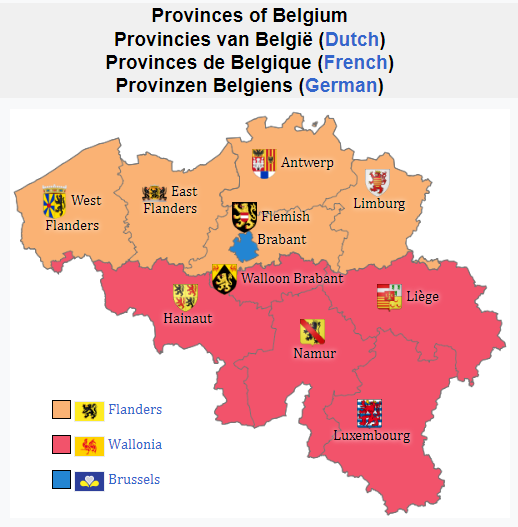

Provinces of Flander:
- Antwerp, East Flanders, Flemish Brabant, Limburg and West Flanders.
- Ghent is capital of East Flanders


Provinces of Wallonia:
- Hainaut, Liege, Luxembourg, Namur, Walloon Brabant

Brussels Capital Region falls under Brussels Region


Based on this information, we need to only consider data for East Flanders province. Also within East Flanders province, there are multiple muncipalities, we need to consider only Gent municipality. So, we would be filtering the data specific to Ghent Muncipality only for our challenge.

**Load dataframe from files**

In [ ]:
# Translate column names for all datasets from Dutch to English

df_ev_points = pd.read_csv(os.path.join(datapath,'Processed data/df_ev_points_transcolumns.csv'))
df_energy_storage_systems = pd.read_csv(os.path.join(datapath,'Processed data/df_energy_storage_systems_transcolumns.csv'))
df_energy_local_production = pd.read_csv(os.path.join(datapath,'Processed data/df_energy_local_production_transcolumns.csv'))
df_energy_decentral_production =  pd.read_csv(os.path.join(datapath,'Processed data/df_energy_decentral_production_transcolumns.csv'))
df_energy_consumption_sector = pd.read_csv(os.path.join(datapath,'Processed data/df_energy_consumption_sector_transcolumns.csv'))
df_energy_consumption_street_level = pd.read_csv(os.path.join(datapath,'Processed data/df_energy_consumption_street_level_transcolumns.csv'))
df_energy_consumption_monthly = pd.read_csv(os.path.join(datapath,'Processed data/df_energy_consumption_monthly_transcolumns.csv'))
df_ghent_rent_prices = pd.read_csv(os.path.join(datapath,'Processed data/df_ghent_rent_prices_transcolumns.csv'))
df_avg_income_per_sector =  pd.read_csv(os.path.join(datapath,'Processed data/df_avg_income_per_sector_transcolumns.csv'))


**Street Level Energy Consumption Data**

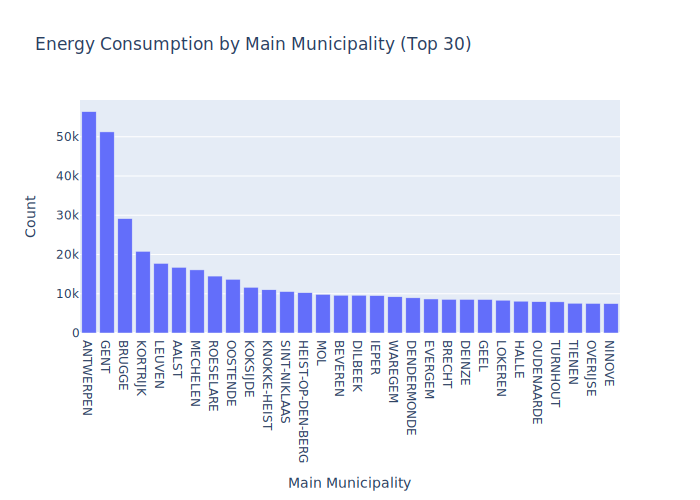

In [ ]:
# Calculate the value counts
value_counts = df_energy_consumption_street_level[df_energy_consumption_street_level['Regio']=='Regio 1']['Main municipality'].value_counts().head(30)

# Create the bar chart
fig = go.Figure(data=[go.Bar(x=value_counts.index, y=value_counts.values)])

# Set the chart title and axes labels
fig.update_layout(title='Energy Consumption by Main Municipality (Top 30)',
                  xaxis_title='Main Municipality',
                  yaxis_title='Count')

# Display the chart
fig.show("svg")


The source file contains data for all the municipalities within Belgium, we will only consider Gent specific data for our work.

**Filter only Gent Muncipality data**

In [ ]:
df_energy_consumption_street_level_gent_pre = df_energy_consumption_street_level[df_energy_consumption_street_level['Main municipality']=='GENT']
columns = ['Energy','direction']
# Display the DataFrame with translated column values
df_energy_consumption_street_level_gent = translate_data(df_energy_consumption_street_level_gent_pre, columns)
df_energy_consumption_street_level_gent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51238 entries, 1 to 1278333
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumption year               51238 non-null  int64  
 1   Main municipality              51238 non-null  object 
 2   Energy                         51238 non-null  object 
 3   direction                      51238 non-null  object 
 4   Street                         51233 non-null  object 
 5   Regio                          51238 non-null  object 
 6   Number of Access Points        51238 non-null  int64  
 7   Approximate consumption (kWh)  51223 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.5+ MB


There are missing values in Street and Approximate consumption (kWh),
- there are just 5 rows with Street as Nan and
- 15 rows with Approximate Consumption (kWh),

we would drop the rows with Street as Nan and impute Approximate Consumption (kWh).

Upon analysis we found that, the data missing is for a specific year for a street, so we consider same street information for another subsequent year which is close to inmpute. Below is the imputation strategy we used:

- consider  the street name, year,  access points which has missing Approximate consumption (kWh)
- look for rows with same street name without missing Approximate consumption (kWh)
- consider the rows which is close to missing year, if data is missing for 2011 then consider 2012 for imputation.
- divide the Approximate consumption (kWh) with Access points to get single consumption say for eg 2012
- multiply that value with access points for missing rows (i.e for 2011) and impute the value.

Number indicates Access points, for which consumption is aggregated. each access point is identified by unique [EAN code](https://www.energyprice.be/blog/ean-code/#ean)

For a particular sector, number indicates how many access points are considered for energy consumption


In [ ]:
df_energy_consumption_street_level_gent[df_energy_consumption_street_level_gent.Street.isnull()]

,Consumption year,Main municipality,Energy,direction,Street,Regio,Number of Access Points,Approximate consumption (kWh)
1361,2011,GENT,Electricity,Decrease,NaN,Regio 1,2,1.321069e+04
2979,2011,GENT,Electricity,Injection,NaN,Regio 1,2,2.066983e+07
242976,2014,GENT,Electricity,Decrease,NaN,Regio 1,14,7.837621e+06
244492,2014,GENT,Natural gas,Decrease,NaN,Regio 1,5,1.407501e+07
1264631,2014,GENT,Electricity,Injection,NaN,Regio 1,1,9.767433e+05


In [ ]:
# Iterate over the rows with missing consumption
for index, row in df_energy_consumption_street_level_gent[df_energy_consumption_street_level_gent['Approximate consumption (kWh)'].isnull()].iterrows():
    street = row['Street']
    year = row['Consumption year']
    access_points = row['Number of Access Points']
    energy = row['Energy']

    # Find the closest available year
    closest_year = df_energy_consumption_street_level_gent[(df_energy_consumption_street_level_gent['Street'] == street) &
                                                            (df_energy_consumption_street_level_gent['Energy'] == energy)
                                                            & (~df_energy_consumption_street_level_gent['Approximate consumption (kWh)'].isnull())]['Consumption year'].min()
    # Find the corresponding row with the closest year
    closest_row = df_energy_consumption_street_level_gent[(df_energy_consumption_street_level_gent['Street'] == street) &
                                                          (df_energy_consumption_street_level_gent['Consumption year'] == closest_year) &
                                                          (~df_energy_consumption_street_level_gent['Approximate consumption (kWh)'].isnull()) &
                                                          (df_energy_consumption_street_level_gent['Energy'] == energy)]

    # Check if the closest_row dataframe is empty
    if closest_row.empty:
        continue
    # Calculate the single consumption value based on access points
    single_consumption = closest_row['Approximate consumption (kWh)'] / closest_row['Number of Access Points']


    # Multiply single consumption by access points to impute the missing value
    imputed_value = (single_consumption * access_points).item()

    # Update the missing value with the imputed value
    df_energy_consumption_street_level_gent.loc[index, 'Approximate consumption (kWh)'] = imputed_value

In [ ]:
df_energy_consumption_street_level_gent.dropna(subset=['Street','Approximate consumption (kWh)'], inplace=True)
df_energy_consumption_street_level_gent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51232 entries, 1 to 1278333
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumption year               51232 non-null  int64  
 1   Main municipality              51232 non-null  object 
 2   Energy                         51232 non-null  object 
 3   direction                      51232 non-null  object 
 4   Street                         51232 non-null  object 
 5   Regio                          51232 non-null  object 
 6   Number of Access Points        51232 non-null  int64  
 7   Approximate consumption (kWh)  51232 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.5+ MB


**Energy Consumption Data for Sector**

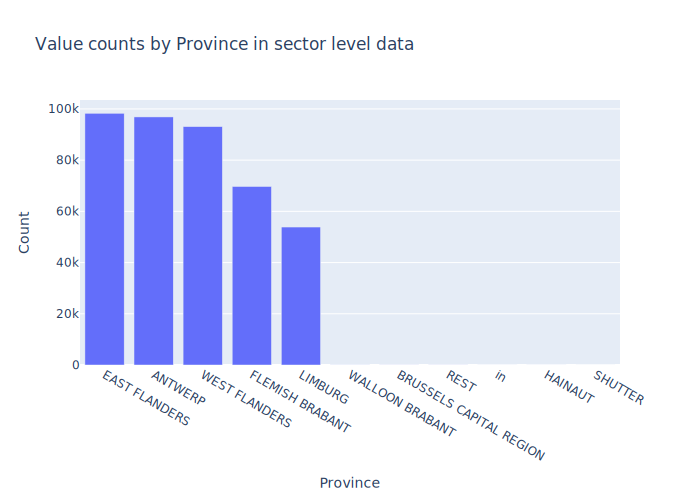

In [ ]:
df_energy_consumption_sector = translate_data(df_energy_consumption_sector, ['Province'])
# Calculate the value counts
value_counts = df_energy_consumption_sector['Province'].value_counts()

# Create the bar chart
fig = go.Figure(data=[go.Bar(x=value_counts.index, y=value_counts.values)])

# Set the chart title and axes labels
fig.update_layout(title='Value counts by Province in sector level data',
                  xaxis_title='Province',
                  yaxis_title='Count')

# Display the chart
fig.show("svg")


There are muliple Provinces in the dataset, and we will be considering EAST FLANDERS specific to Ghent

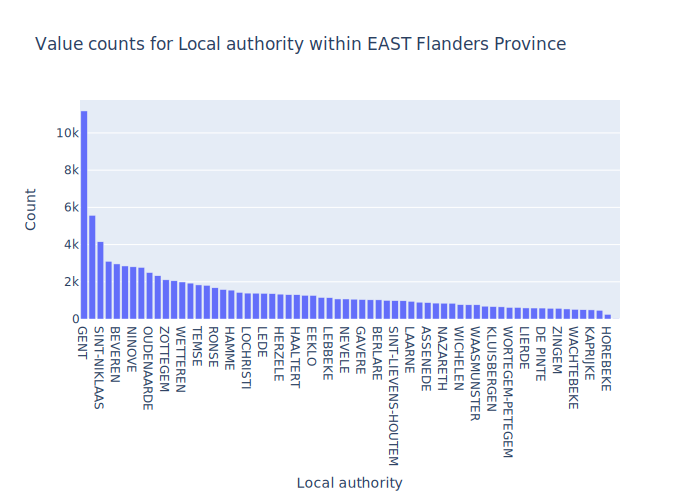

In [ ]:
# Calculate the value counts
value_counts = df_energy_consumption_sector[df_energy_consumption_sector['Province']=='EAST FLANDERS']['Local authority'].value_counts()

# Create the bar chart
fig = go.Figure(data=[go.Bar(x=value_counts.index, y=value_counts.values)])

# Set the chart title and axes labels
fig.update_layout(title='Value counts for Local authority within EAST Flanders Province',
                  xaxis_title='Local authority',
                  yaxis_title='Count')

# Display the chart
fig.show("svg")


Filter only Gent municipality data

In [ ]:
df_energy_consumption_sector_gent_pre = df_energy_consumption_sector[df_energy_consumption_sector['Local authority']=='GENT']

columns = ['Market', 'direction', 'Subsector', 'Sector', 'Rol Contact']
# Display the DataFrame with translated column values
df_energy_consumption_sector_gent=translate_data(df_energy_consumption_sector_gent_pre, columns)

In [ ]:
df_energy_consumption_sector_gent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 13990 to 397451
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumption year               11182 non-null  int64  
 1   Market                         11182 non-null  object 
 2   direction                      11182 non-null  object 
 3   Statistical Sector             11182 non-null  object 
 4   Province                       11182 non-null  object 
 5   Local authority                11182 non-null  object 
 6   Subsector                      11182 non-null  object 
 7   Sector                         11182 non-null  object 
 8   Rol Contact                    11182 non-null  object 
 9   Number                         11182 non-null  float64
 10  Approximate Consumption (kWh)  11179 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB


There are missing values in Approximate consumption (kWh) for 3 rows.

In [ ]:
df_energy_consumption_sector_gent[df_energy_consumption_sector_gent['Approximate Consumption (kWh)'].isna()]

,Consumption year,Market,direction,Statistical Sector,Province,Local authority,Subsector,Sector,Rol Contact,Number,Approximate Consumption (kWh)
28320,2020,Natural gas,Decrease,44021E29-,EAST FLANDERS,GENT,other industry,Industry,Company,5.0,NaN
164740,2018,Natural gas,Decrease,44021D084,EAST FLANDERS,GENT,Offices and administrations,Tertiary sector,Company,25.0,NaN
389834,2021,Natural gas,Decrease,44021H310,EAST FLANDERS,GENT,Rest,Industry,Company,3.0,NaN


For a specific statistical sector and the Sector/Subsector/energy, we dont have a same statistical sector for another year, which can be used for imputation and since they are just three rows, we would be dropping them

In [ ]:
df_energy_consumption_sector_gent[(df_energy_consumption_sector_gent['Statistical Sector']=='44021E29-') &
                                  (df_energy_consumption_sector_gent['Subsector']=='other industry')]

,Consumption year,Market,direction,Statistical Sector,Province,Local authority,Subsector,Sector,Rol Contact,Number,Approximate Consumption (kWh)
28320,2020,Natural gas,Decrease,44021E29-,EAST FLANDERS,GENT,other industry,Industry,Company,5.0,NaN
35615,2020,Electricity,Decrease,44021E29-,EAST FLANDERS,GENT,other industry,Industry,Company,7.0,21762.13694
257582,2018,Electricity,Decrease,44021E29-,EAST FLANDERS,GENT,other industry,Industry,Company,4.0,33449.97558


In [ ]:
df_energy_consumption_sector_gent.dropna(subset=['Approximate Consumption (kWh)'], inplace=True)
df_energy_consumption_sector_gent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11179 entries, 13990 to 397451
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consumption year               11179 non-null  int64  
 1   Market                         11179 non-null  object 
 2   direction                      11179 non-null  object 
 3   Statistical Sector             11179 non-null  object 
 4   Province                       11179 non-null  object 
 5   Local authority                11179 non-null  object 
 6   Subsector                      11179 non-null  object 
 7   Sector                         11179 non-null  object 
 8   Rol Contact                    11179 non-null  object 
 9   Number                         11179 non-null  float64
 10  Approximate Consumption (kWh)  11179 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB


**Local energy production installations connected to the Fluvius network per municipality.**

Local energy production refers to the generation of energy resources within a local community or geographic area. It emphasizes the idea of communities taking control of their energy supply and becoming self-sufficient in meeting their energy needs

Filter data for GENT Municipality

In [ ]:
df_energy_local_production_gent_pre = df_energy_local_production[df_energy_local_production['MAIN MUNICIPALITY']=='GENT']
columns = ['DNB','MAIN MUNICIPALITY','Technology']
df_energy_local_production_gent = translate_data(df_energy_local_production_gent_pre, columns)
df_energy_local_production_gent

,Reference date,DNB,MAIN MUNICIPALITY,Technology,Number of installations,Installed power (kVA)
172,2022-10,IMEWOR,GENT,BIOMASS (NO CHP),2,26644.00
173,2022-10,IMEWOR,GENT,DIESEL (NO CHP),5,10850.00
174,2022-10,IMEWOR,GENT,EMERGENCY GROUP TYPE1,1,800.00
175,2022-10,IMEWOR,GENT,EMERGENCY GROUP TYPE2,10,16350.00
176,2022-10,IMEWOR,GENT,WKK BIOMASS/BIOGAS,4,1770.00
445,2022-10,IMEWOR,GENT,WIND ENERGY,19,76754.00
446,2022-10,IMEWOR,GENT,CHP NATURAL GAS,34,60645.63
766,2022-10,IMEWOR,GENT,FUEL CELL,6,18.25
767,2022-10,IMEWOR,GENT,SOLAR ENERGY,16738,117824.53


Majority of the local production is via SOLAR ENERGY for GENT Muncipality

**List of decentralized energy production installations linked to the distribution network** (some data 1984-2007, mostly 2008-2021)

Decentralized energy production refers to the generation of energy at smaller-scale, distributed locations that are closer to the point of consumption. Instead of relying solely on large centralized power plants located far away from the end users, decentralized energy production aims to bring energy generation closer to the demand centers.

- Filter only Gent Muncipality data based on [NIS code](https://en.wikipedia.org/wiki/NIS_code). The NIS code (Dutch: NIS-code, French: code INS) is a numeric code for regional areas of Belgium. This code is used for statistical data treatment in Belgium.

- Translate rows from Dutch to English
- Drop irrelevant columns (as per data dictonary provided)
    - hierarchical version of the postal code, for visualization purposes, can be disregarded
    - Internal ID, can be disregarded.

In [ ]:
columns_with_nis = [column for column in df_energy_decentral_production if 'nis' in column.lower()]
df_energy_decentral_production_gent_pre = df_energy_decentral_production[df_energy_decentral_production[columns_with_nis[0]]==44021]
columns = ['Type of technology']
# Display the DataFrame with translated column values
df_energy_decentral_production_gent = translate_data(df_energy_decentral_production_gent_pre, columns)

# Drop columns by specifying column names
columns_to_drop = ['Postal code (hierarchical)', 'Unique_order_ID']
df_energy_decentral_production_gent = df_energy_decentral_production_gent.drop(columns=columns_to_drop)

In [ ]:
df_energy_decentral_production_gent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14479 entries, 107751 to 554377
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year of commissioning     14453 non-null  float64
 1   Type of technology        14479 non-null  object 
 2   Power (kVA)               14479 non-null  float64
 3   Voltage level connection  14479 non-null  object 
 4   Municipality Nis Code     14479 non-null  float64
 5   Postcode                  14479 non-null  float64
dtypes: float64(4), object(2)
memory usage: 791.8+ KB


In [ ]:
df_energy_decentral_production_gent.head()

,Year of commissioning,Type of technology,Power (kVA),Voltage level connection,Municipality Nis Code,Postcode
107751,2020.0,Solar Energy (PV),4.0,LS,44021.0,9040.0
107752,2011.0,Solar Energy (PV),5.3,LS,44021.0,9040.0
107753,2011.0,Solar Energy (PV),9.0,LS,44021.0,9040.0
107754,2011.0,Solar Energy (PV),3.6,LS,44021.0,9040.0
107755,2011.0,Solar Energy (PV),4.2,LS,44021.0,9040.0


In [ ]:
df_energy_decentral_production_gent['Type of technology'].value_counts()

Solar Energy (PV)    14479
Name: Type of technology, dtype: int64

In [ ]:
df_energy_decentral_production_gent['Year of commissioning'].value_counts()

2020.0    3787
2019.0    1758
2011.0    1516
2018.0    1498
2009.0    1175
2017.0    1064
2021.0     753
2012.0     748
2010.0     699
2016.0     622
2015.0     233
2008.0     232
2014.0     193
2013.0     101
2007.0      70
2005.0       4
Name: Year of commissioning, dtype: int64

**Sector with lowest average income**

In [ ]:
# Calculate the average net taxable income per sector
numeric_columns = df_avg_income_per_sector.columns[1:]
df_avg_income_per_sector['Average Income'] = df_avg_income_per_sector[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce')).mean(axis=1)

# Sort the DataFrame based on the average income in ascending order
df_sorted = df_avg_income_per_sector.sort_values('Average Income')

# Select the sectors with the lowest average incomes
sectors_low_income = df_sorted.head(10)

# Display the sectors with low income
sectors_low_income[['Sectors', 'Average Income']]


,Sectors,Average Income
119,Rekencentrum,6522.750000
88,Malem,8747.357143
13,Blaisantvest,9350.800000
161,Wondelgemstraat,9404.733333
143,Tolhuis,9761.866667
2,Afrikalaan,10682.066667
96,Muidebrug,10757.733333
99,Nieuw Gent,11067.133333
51,Groendreef,11412.066667
121,Rooigem,11454.200000


**Sector with highest average income**

In [ ]:
# Select the sectors with the lowest average incomes
sectors_high_income = df_sorted.tail(10)

# Display the sectors with low income
sectors_high_income[['Sectors', 'Average Income']]

,Sectors,Average Income
150,Visserij,25146.466667
35,Drongen - Industriepark,25715.466667
32,Drie Sleutels,25883.266667
142,Ter Rivieren,25937.800000
120,Rijvissche,26721.400000
109,Paolalaan,26848.769231
61,Hoedjen,27423.466667
27,De Smet - De Naeyer,28141.266667
114,Port Arthur,480844.000000
153,Wafelijzer,505349.666667


Save processed and cleaned files

In [ ]:
df_energy_consumption_street_level_gent.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_street_level_gent.csv'), index=False)
df_energy_consumption_sector_gent.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_sector_gent.csv'), index=False)
df_energy_storage_systems.to_csv(os.path.join(datapath, 'Processed data/df_energy_storage_systems.csv'), index=False)
df_energy_local_production_gent.to_csv(os.path.join(datapath, 'Processed data/df_energy_local_production_gent.csv'), index=False)
df_energy_decentral_production_gent.to_csv(os.path.join(datapath, 'Processed data/df_energy_decentral_production_gent.csv'), index=False)


#### 2. EDA with insights

**Energy Consumption By Year**

Energy Consumption Trend:


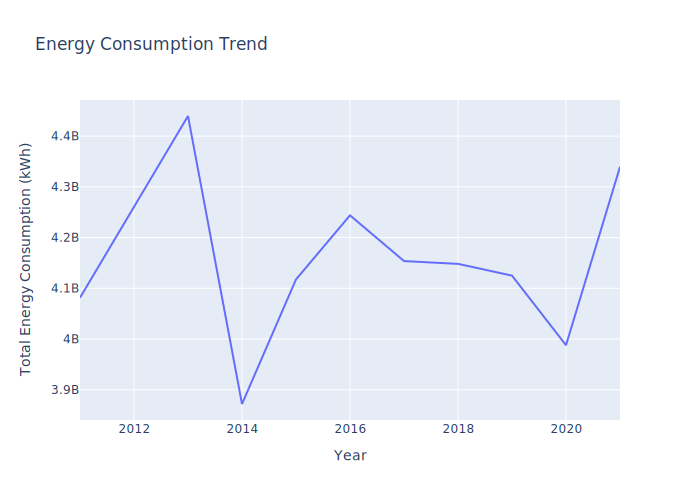

In [ ]:
total_consumption_per_year = df_energy_consumption_street_level_gent.groupby('Consumption year')['Approximate consumption (kWh)'].sum().reset_index()
# Print the trend of energy consumption over the years
print("Energy Consumption Trend:")
# Plot the trend of energy consumption
fig = px.line(total_consumption_per_year, x='Consumption year', y='Approximate consumption (kWh)', title='Energy Consumption Trend')
fig.update_traces(marker=dict(symbol='circle', size=8))
fig.update_layout(xaxis_title='Year', yaxis_title='Total Energy Consumption (kWh)')
fig.show("svg")

**Energy Poverty Assessment**

Rent prices can be correlated with energy poverty, where households struggle to afford energy bills. Rent price data can be used in conjunction with energy consumption data to identify areas where energy poverty is prevalent.
Identify streets with highest energy poverty

In [ ]:
# Merge the rent and energy data based on common region/area column

rent_prices = df_ghent_rent_prices.copy()
#rent_prices = rent_prices[rent_prices['locality'] == 'Gent']
rent_prices['street_name'] = rent_prices['street'].str.lower().replace(' ', '', regex=True)

energy_street_lvl = df_energy_consumption_street_level_gent.copy()
#energy_street_lvl = energy_street_lvl[(energy_street_lvl['Consumption year'] == 2021 )]
energy_street_lvl['street_name'] = energy_street_lvl['Street'].str.lower().replace(' ', '', regex=True)

merged_rental_data = pd.merge(rent_prices, energy_street_lvl, on='street_name')
merged_rental_data.drop_duplicates(inplace=True)

# Calculate energy poverty indicator by dividing energy consumption by rent price
merged_rental_data['energy_poverty_indicator'] = merged_rental_data['Approximate consumption (kWh)'] / (merged_rental_data['price_main_value']+ merged_rental_data['price_additional_value'])

# Sort the data in descending order based on energy poverty indicator
sorted_data = merged_rental_data.sort_values('energy_poverty_indicator', ascending=False)

# Print the regions with highest energy poverty
top_energy_poverty_regions = sorted_data.head(15)[['locality', 'postal_code', 'street_name','street_number','energy_poverty_indicator','Consumption year','Energy']]
print("Steeets with the highest energy poverty:")
top_energy_poverty_regions

Steeets with the highest energy poverty:


,locality,postal_code,street_name,street_number,energy_poverty_indicator,Consumption year,Energy
8114,Gent,9000,depintelaan,"209,",70575.131317,2018,Electricity
8122,Gent,9000,depintelaan,"209,",70497.833238,2016,Electricity
8129,Gent,9000,depintelaan,"209,",69765.849524,2017,Electricity
8131,Gent,9000,depintelaan,"209,",68286.744079,2015,Electricity
8125,Gent,9000,depintelaan,"209,",68073.072048,2019,Electricity
8127,Gent,9000,depintelaan,"209,",66596.079238,2020,Electricity
8126,Gent,9000,depintelaan,"209,",64474.808222,2021,Electricity
2732,Gent,9000,corneelheymanslaan,9a,44918.812448,2013,Natural gas
1406,Gent,9000,kortrijksesteenweg,390,44246.543908,2013,Natural gas
1384,Gent,9000,kortrijksesteenweg,390,44246.543908,2013,Natural gas


Higher rent prices combined with high energy costs can create a burden on low-income households, leading to energy poverty.Energy community initiatives can then be designed to alleviate energy poverty by providing affordable and sustainable energy solutions.

**merge sol_v3 with street energy consumption data**

In [ ]:
df_sol_v3['NISCODE'].value_counts()

44021.0    122965
Name: NISCODE, dtype: int64

Data within SOL_V3 is for Gent municipality

In [ ]:
print(f'length of dataset df_energy_consumption_street_level_gent: {len(df_energy_consumption_street_level_gent)}')
print(f'length of dataset df_sol_v3: {len(df_sol_v3)}')

df_sol_v3['STREET NM'] = df_sol_v3['STREET NM'].str.lower().replace(' ', '', regex=True)
df_energy_consumption_street_level_gent['Street'] = df_energy_consumption_street_level_gent['Street'].str.lower().replace(' ', '', regex=True)
energy_consumptio_with_sol = pd.merge(df_energy_consumption_street_level_gent, df_sol_v3,  left_on='Street', right_on='STREET NM')
energy_consumptio_with_sol = energy_consumptio_with_sol.drop(columns=['Regio','GRB_UIDN', 'GRB_OIDN','TYPE','DATA_GRB', 'DATE_MEMBER', 'TOP FL', 'LENGTH',
       'STREET MIDDLE','NISCODE', 'LOCAL AUTHORITY','HNRLABEL', 'SLOPE', 'ASPECT', 'IRR_SqM',
       'IRR_Tot', 'Type_Dak', 'Awaken_E', 'geometry'])

print(f'length of dataset after merging: {len(energy_consumptio_with_sol)}')
print(f'There are {len(energy_consumptio_with_sol["Street"].unique())} streets within this dataset')


length of dataset df_energy_consumption_street_level_gent: 51232
length of dataset df_sol_v3: 164301
length of dataset after merging: 2624093
There are 2281 streets within this dataset


In [ ]:
energy_consumptio_with_sol['ENTITY'].value_counts()

buildings                        2623430
man-made objects like bridges        354
building attachments                 309
Name: ENTITY, dtype: int64

In [ ]:
energy_consumptio_with_sol['Consumption year'].value_counts()

2021    241219
2020    239992
2019    239884
2018    239341
2017    238638
2016    237849
2015    237740
2014    237571
2013    237527
2012    237268
2011    237064
Name: Consumption year, dtype: int64

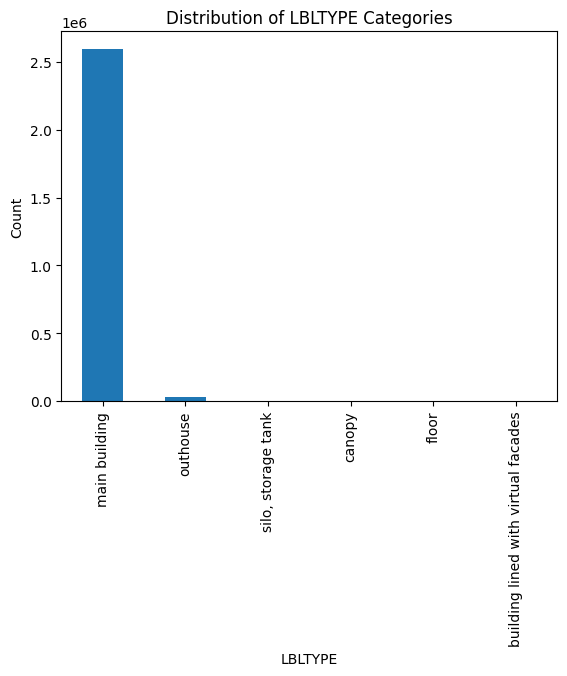

In [ ]:
# Count the occurrences of each unique value in LBLTYPE
lbltype_counts = energy_consumptio_with_sol['LBLTYPE'].value_counts()

# Plot a bar chart to visualize the distribution of LBLTYPE categories
lbltype_counts.plot(kind='bar')
plt.xlabel('LBLTYPE')
plt.ylabel('Count')
plt.title('Distribution of LBLTYPE Categories')
plt.show()

In [ ]:
# Calculate summary statistics of Approximate consumption (kWh) for each LBLTYPE category
lbltype_stats = energy_consumptio_with_sol.groupby('LBLTYPE')['Approximate consumption (kWh)'].describe()

# Print the summary statistics
lbltype_stats

,count,mean,std,min,25%,50%,75%,max
LBLTYPE,,,,,,,,
building lined with virtual facades,44.0,3.147024e+06,1.184256e+06,1508607.81,2.032362e+06,3.161593e+06,4.065797e+06,5.184516e+06
canopy,199.0,2.259031e+06,5.128224e+06,25518.50,1.038435e+05,2.909371e+05,1.238708e+06,2.411777e+07
floor,110.0,5.532933e+05,4.193045e+05,100801.76,1.791989e+05,4.402160e+05,9.769331e+05,1.483271e+06
main building,2595248.0,2.043573e+06,4.350498e+06,523.05,2.795054e+05,7.090969e+05,1.835120e+06,7.256422e+07
outhouse,28138.0,4.678743e+06,8.379224e+06,523.05,4.437215e+05,1.128594e+06,4.172454e+06,7.256422e+07
"silo, storage tank",354.0,2.400450e+06,5.354536e+06,26366.94,1.960732e+05,7.634331e+05,9.108483e+05,2.411777e+07


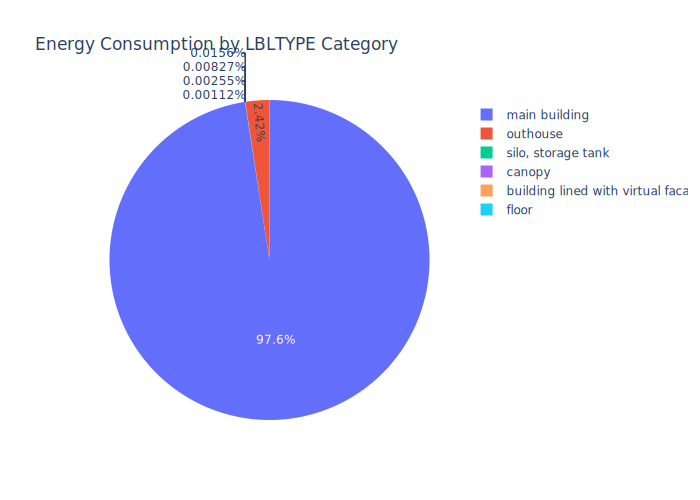

In [ ]:
# Group the data by LBLTYPE and calculate the total energy consumption for each category
lbltype_energy = energy_consumptio_with_sol.groupby('LBLTYPE')['Approximate consumption (kWh)'].sum().reset_index()

# Create a pie chart using Plotly
fig = px.pie(lbltype_energy, values='Approximate consumption (kWh)', names='LBLTYPE',
             title='Energy Consumption by LBLTYPE Category')

fig.show('svg')

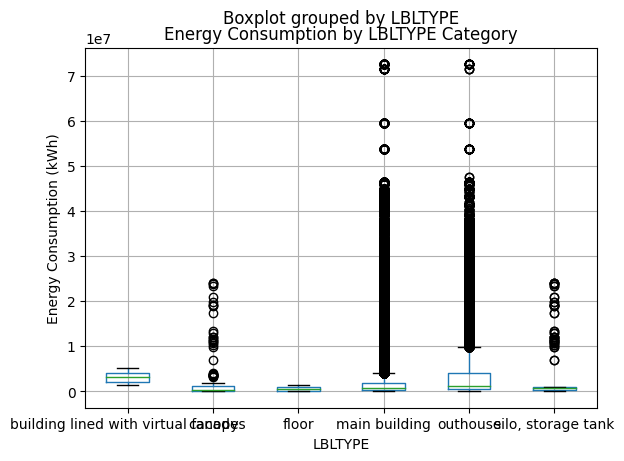

In [ ]:
# Create box plots to compare energy consumption across different LBLTYPE categories
energy_consumptio_with_sol.boxplot(column='Approximate consumption (kWh)', by='LBLTYPE')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption by LBLTYPE Category')
plt.show()

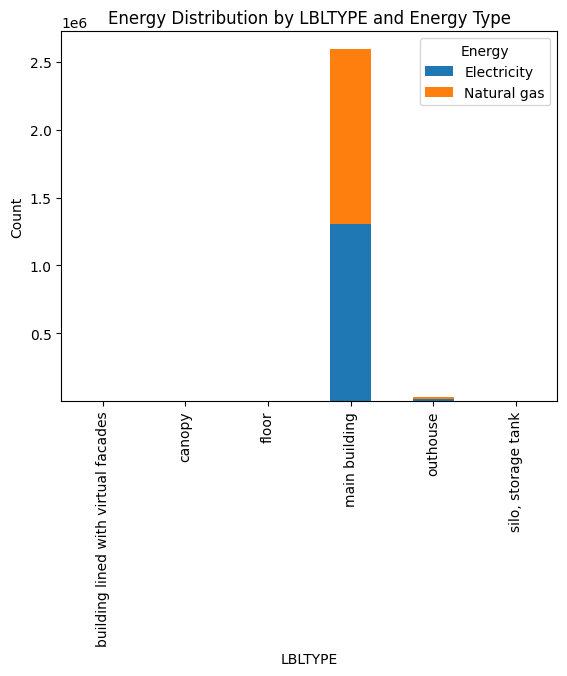

In [ ]:
# Explore the relationship between LBLTYPE and Energy
energy_consumptio_with_sol.groupby('LBLTYPE')['Energy'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.xlabel('LBLTYPE')
plt.ylabel('Count')
plt.title('Energy Distribution by LBLTYPE and Energy Type')
plt.show()


Lets filter on specific year i.e 2021 and check top 10 buildings with energy consumption

In [ ]:
year=2019
energy_consumption_with_sol = energy_consumptio_with_sol[energy_consumptio_with_sol['Consumption year']==year]
building_count = energy_consumption_with_sol[energy_consumption_with_sol['ENTITY'] == 'buildings'].groupby('Street').size()

# Sort the building count in descending order and select the top 10
top_10_buildings = building_count.sort_values(ascending=False).head(10)
top_10_buildings

Street
antwerpsesteenweg        2148
zwijnaardsesteenweg      1582
brusselsesteenweg        1539
brugsesteenweg           1456
kortrijksesteenweg       1402
ottergemsesteenweg       1190
sint-bernadettestraat    1184
morekstraat              1174
voskenslaan              1164
meulesteedsesteenweg     1140
dtype: int64

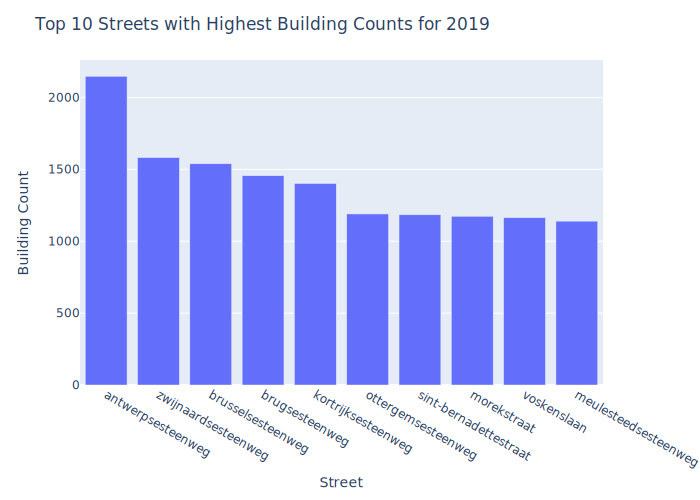

In [ ]:
# Create a bar plot
fig = px.bar(top_10_buildings, x=top_10_buildings.index, y=top_10_buildings.values)
fig.update_layout(xaxis_title='Street', yaxis_title='Building Count', title=f'Top 10 Streets with Highest Building Counts for {year}')
fig.show("svg")

In [ ]:
energy_consumption_with_sol['LBLTYPE'].value_counts()

main building                          237224
outhouse                                 2596
silo, storage tank                         32
canopy                                     18
floor                                      10
building lined with virtual facades         4
Name: LBLTYPE, dtype: int64

In [ ]:
# Specify the street name for which you want to see the LBL_TYPE
street_name = 'antwerpsesteenweg'

# Filter the DataFrame based on the street name
specific_street = energy_consumption_with_sol[energy_consumption_with_sol['Street'] == street_name]

# Count the occurrences of each LBL_TYPE
lbl_type_counts = specific_street['LBLTYPE'].value_counts().head(10)
lbl_type_counts


main building    2130
outhouse           18
Name: LBLTYPE, dtype: int64


- Street level data is for year 2012 to 2021, whch has details around energy consumption per street
- The energy sources mentioned in the data are electricity and natural gas. The energy consumption values provided are associated with these sources for different years.
- Solar opportunities data is provided with the information of building types, categorized by "LBLTYPE," which represents different types of buildings or structures. The observations provide insights into the energy consumption patterns across different building or structure types.

Other EDA insights are added to Appendix : EDA Insights section

### 3. Feature engineering

There are two fundamental components to forming an energy community:
- the (estimated, averaged, predicted) electricity consumption of its members
- the (estimated) electricity production from solar panels

In order to simplify the problem, and because requisite data for Ghent is lacking, we do not consider other equipment such as battery energy storage systems or the fluctuations in consumption and production of electricity over the course of a day or a year. Our objective is therefore to maximise the amount of production relative to consumption of electricity in a proposed energy community, within some constraints. The constraints and how to quantify and optimise them are discussed in the next section on model / technique(s) selection.

In order to produce clusters that balance the production and consumption, we produce two input datasets:
- a dataframe of possible solar panel installation locations, characterised by our estimate of the energy capacity and their latitudes and longitudes
- a dataframe of households, characterised by our estimate of their energy production and their latitudes and longitudes. For tractability, we assume energy communities made up of residential members, not businesses or non-profit organisations. We assume that every household will form part of an energy community

Also for tractability, we restrict the modelling to the lowest-average-income sector of Ghent (barring a very small one): Malem. This allows us to show a proof of concept that can be scaled up to the whole of Ghent, while being small enough to fully analyse and visualise.


#### Assembling data to be used for modeling

***Household electricity consumption***

***We have some assumptions around the data as described below:***

Per-household electricity consumption data is not available to us, so we use the per-street estimated electricity consumption from 2019 and divide it by the number of access points. Equating one access point to one household is imperfect, but a good enough approximation of reality that preserves data privacy.

Similarly, for both data privacy and limitations on the data that is available to us, we assume access points on a street to be equally spaced along a line which defines the street's principal geometry. For future developments of this app, real estimates of annual household consumption per address can be used for more accurate custom predictions. As a compromise, further developments could use a distribution of known real household consumption and sample from this distribution, instead of assuming a homogenous consumption as we have.

We also reduce the data to Malem.

The following cells illustrate how we processed the data to make these assumptions, to engineer the household consumption data for modelling.

*Openstreetmap lookup by street name*

There is no street name to sector mapping provided in the dataset so we used Openstreetmap lookup (https://nominatim.openstreetmap.org) to map street name with sector names
- openstreetmap lookup by 'Street' name, extract the sector names from 'display_name' key
- create sector_names column and apply the extracted sector names corresponding to the 'Street' name
- save as csv file

In [ ]:
# Load data for annual approximate (electricty) energy consumption per street in Ghent
df_energy_consumption_street_level_gent = pd.read_csv(os.path.join(datapath, "Processed data/df_energy_consumption_street_level_gent.csv"))

In [ ]:
# Filter for 2019 data: this is the most recent data, so we will use this
year = 2019
df_energy_consumption_street_level_gent_2019 = df_energy_consumption_street_level_gent[(df_energy_consumption_street_level_gent['Consumption year'] == year) & (df_energy_consumption_street_level_gent['Energy']=='Electricity')]
df_energy_consumption_street_level_gent_2019.head(3)

,Consumption year,Main municipality,Energy,direction,Street,Regio,Number of Access Points,Approximate consumption (kWh)
3103,2019,GENT,Electricity,Decrease,AAIGEMSTRAAT,Regio 1,175,541545.62
3104,2019,GENT,Electricity,Decrease,AALSCHOLVERSTRAAT,Regio 1,14,40679.74
3105,2019,GENT,Electricity,Decrease,ABDIJMOLENSTRAAT,Regio 1,84,353423.91


In [ ]:
# To reduce our modelling down to a tractable part of Ghent, we use OpenStreetMap to identify the geographical "sector" for each street

year = 2019

# OpenStreetMap base URL
opensm_url = "https://nominatim.openstreetmap.org"

# Apply the openstreetmap lookup for 2019 for energy consumption street level dataset: df_energy_consumption_street_level_gent_w_sectors_2019
start_t = time.time()
print(f"Applying mapped sector names from openstreetmap, by street... started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
df_energy_consumption_street_level_gent_w_sectors_2019_pre, sector_count, st_names_not_found = update_street_level_data(df_energy_consumption_street_level_gent_2019,
                                                                                                                          base_url=opensm_url, lookup_column='Street',
                                                                                                                          create_columns=['Sectors'])
total_t = round(time.time() - start_t, 2)
print(f"\nApplying mapped sector names from openstreetmap completed, at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
if total_t > 60.0:
    print(f"Total time taken to apply openmap lookup: {timedelta(seconds=total_t)}")
else:
    print(f"Total time taken to apply openmap lookup: {total_t} seconds")
print(f"Total number of sectors-to-street applied: {sector_count}")



Applying mapped sector names from openstreetmap, by street... started at 2023-06-21 14:40:32


applying openstreetmap sector name(s)..: 100%|██████████| 2426/2426 [1:00:12<00:00,  1.49s/it]


Applying mapped sector names from openstreetmap completed, at 2023-06-21 15:40:44

Total time taken to apply openmap lookup: 1:00:12.170000
Total number of sectors-to-street applied: 2158


In [ ]:
# Re-arrange the columns for readability
sector_cols = ['Main municipality',
 'Energy',
 'Street',
 'Sectors',
 'Number of Access Points',
 'Approximate consumption (kWh)',
 'direction'
]
re_sector_cols = sector_cols + [col for col in df_energy_consumption_street_level_gent_w_sectors_2019_pre.columns if col not in sector_cols]
df_energy_consumption_street_level_gent_w_sectors_2019 = df_energy_consumption_street_level_gent_w_sectors_2019_pre[re_sector_cols]
df_energy_consumption_street_level_gent_w_sectors_2019.to_csv(os.path.join(datapath, f'Processed data/df_energy_consumption_street_level_gent_w_sectors_{year}.csv'), index=False)
df_energy_consumption_street_level_gent_w_sectors_2019.head(2)

,Main municipality,Energy,Street,Sectors,Number of Access Points,Approximate consumption (kWh),direction,Consumption year,Regio
3103,GENT,Electricity,AAIGEMSTRAAT,Rijsenbergwijk,175,541545.62,Decrease,2019,Regio 1
3104,GENT,Electricity,AALSCHOLVERSTRAAT,Lange Velden,14,40679.74,Decrease,2019,Regio 1


In [ ]:
# For tractability, functions to allow the data on energy consumption by street to be filtered by region (e.g. Malem)

def apply_row_value(row, col):
    num_delim = row[col].count(',')
    return num_delim + 1

def filter_by_sector_energy_consump_sector_data(df, region_name='Malem',
                                               sectors_col='Sectors',
                                               access_pt_col='Number of Access Points',
                                               approx_consumption_col='Approximate consumption (kWh)',
                                               divide_access_points=False):

    df_filt_pre = df[df.columns].copy()
    df_filt_pre[sectors_col] = df_filt_pre[sectors_col].astype('string')
    df_filt_pre = df[df[sectors_col].str.contains(region_name, case=False)]
    df_filt = None
    df_filt_region = None
    df_result = None
    accept_pt_factor_col = 'access_pts_factor'
    step = ""

    try:
        # Step: apply a column to tell if we need to divide the total access points
        if divide_access_points:
            step = " apply access points factor "
            # Divide the Approximate consumption (kWh) by Number of Access points before exploding
            df_filt_pre[approx_consumption_col] = df_filt_pre[approx_consumption_col]/df_filt_pre[access_pt_col]

            df_filt_pre[accept_pt_factor_col] = df_filt_pre.apply(lambda row: apply_row_value(row, sectors_col), axis=1)
            print(list(df_filt_pre.columns))

            # Step: explode
            # df_sec_1.Sectors = df_sec_1.Sectors.str.split(',')
            # df_sec_1_exp = df_sec_1.explode('Sectors')
            # Step: explode
            # df_filt[sectors_col] = df_filt[sectors_col].astype(str).split(',')
            step = " explode "
            df_result = df_filt_pre.explode(sectors_col).reset_index(drop=True)

            # Step: apply the new access points - values
            step = " upd access points "
            new_ap_values = df_result.apply(lambda x: round(x[access_pt_col]/x[accept_pt_factor_col]) if not pd.isnull(x[access_pt_col]) else x[access_pt_col], axis=1)
            df_result[access_pt_col] = new_ap_values
        else:
            df_filt = df_filt_pre[df_filt_pre.columns].copy()
            # No need to update the total number of access points

            # Just for the sake of sanity add the access_pts_factor column with a default of 1
            df_filt.insert(4, accept_pt_factor_col, 1)
            df_result = df_filt

        # Step: filter by region_name
        df_result = df_result[df_result[sectors_col].str.contains(region_name, case=False)]
    except Exception as ex:
        print(f"Error occurred: {ex} at step: {step}")
    return df_result


In [ ]:
# Just check to make sure we only have Energy = 'Electricity' (we are not interested in other kinds of consumption)
df_energy_consumption_street_level_gent_w_sectors_2019['Energy'].unique()

array(['Electricity'], dtype=object)

In [ ]:
df_energy_consumption_street_level_gent_w_sectors_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2450 entries, 3103 to 34913
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Main municipality              2450 non-null   object 
 1   Energy                         2450 non-null   object 
 2   Street                         2450 non-null   object 
 3   Sectors                        2450 non-null   object 
 4   Number of Access Points        2450 non-null   int64  
 5   Approximate consumption (kWh)  2450 non-null   float64
 6   direction                      2450 non-null   object 
 7   Consumption year               2450 non-null   int64  
 8   Regio                          2450 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 191.4+ KB


In [ ]:
# Filter data with 'region_name' = 'Malem', so it will match any sector containing Malem
df_energy_consumption_street_gent_w_sector_region_2019 = filter_by_sector_energy_consump_sector_data(df_energy_consumption_street_level_gent_w_sectors_2019,
                                                                                                     region_name='Malem', sectors_col='Sectors',
                                                                                                     divide_access_points=True,
                                                                                                     )

['Main municipality', 'Energy', 'Street', 'Sectors', 'Number of Access Points', 'Approximate consumption (kWh)', 'direction', 'Consumption year', 'Regio', 'access_pts_factor']


In [ ]:
# Examine the number of access points on each street: we will use this to asssume per-household consumption
df_street_not_null = df_energy_consumption_street_gent_w_sector_region_2019[~df_energy_consumption_street_gent_w_sector_region_2019.Street.isnull()]
df_street_acpt_null = df_street_not_null[df_street_not_null['Number of Access Points'].isnull()]
df_street_acpt_null.head(2)

df_st_ap_notnull = df_street_not_null[~df_street_not_null['Number of Access Points'].isnull()]
print(f"Total rows that have Street and 'Number of Access Points' as well: {df_st_ap_notnull.shape[0]}")
mean_ap = df_st_ap_notnull['Number of Access Points'].mean()
print(f"mean of accesspoints: {mean_ap}")


Total rows that have Street and 'Number of Access Points' as well: 14
mean of accesspoints: 24.214285714285715


In [ ]:
# Apply mean as filler for empty or null in 'Number of Access Points' column
apply_col = 'Number of Access Points'
df_energy_consumption_street_gent_w_sector_region_2019.loc[((df_energy_consumption_street_gent_w_sector_region_2019['Street'].notnull()) & (df_energy_consumption_street_gent_w_sector_region_2019[apply_col].isnull()))][apply_col] = round(mean_ap)
df_energy_consumption_street_gent_w_sector_region_2019[apply_col] = df_energy_consumption_street_gent_w_sector_region_2019[apply_col].fillna(round(mean_ap))
df_energy_consumption_street_gent_w_sector_region_2019[apply_col].unique()


array([25, 69, 60,  8,  3, 22, 28,  6, 13,  4, 39,  7, 52])

In [ ]:
# Explode the dataframe of per-street electricity consumption data to create a dataframe of assumed per-household consumption where per-street consumption is divided equally by households

# Repeat rows (only the household number should differ)
repeat_col = 'Number of Access Points'
df_consum_street_region_2019 = df_energy_consumption_street_gent_w_sector_region_2019.loc[df_energy_consumption_street_gent_w_sector_region_2019.index.repeat(df_energy_consumption_street_gent_w_sector_region_2019[repeat_col])]
# group by index with transform for date ranges
df_consum_street_region_2019['Accesspt_perstreet_hhld'] = (df_consum_street_region_2019.groupby(level=0)[repeat_col]
                                                               .transform(lambda x: range(1,len(x)+1)))

# unique default index
df_consum_street_region_2019 = df_consum_street_region_2019.reset_index(drop=True)
df_consum_street_region_2019.head(2)


,Main municipality,Energy,Street,Sectors,Number of Access Points,Approximate consumption (kWh),direction,Consumption year,Regio,access_pts_factor,Accesspt_perstreet_hhld
0,GENT,Electricity,BREENDONKSTRAAT,"Brughuizeken,Malem",25,2157.4874,Decrease,2019,Regio 1,2,1
1,GENT,Electricity,BREENDONKSTRAAT,"Brughuizeken,Malem",25,2157.4874,Decrease,2019,Regio 1,2,2


In [ ]:
# Create a unique household ID for each row
num_rows = df_consum_street_region_2019.shape[0]
uniq_col_identifier_vals = [f'hhld{i+1}' for i in range(num_rows)]
df_consum_street_region_2019['hhld_id'] = uniq_col_identifier_vals
df_consum_street_region_2019.head(2)


,Main municipality,Energy,Street,Sectors,Number of Access Points,Approximate consumption (kWh),direction,Consumption year,Regio,access_pts_factor,Accesspt_perstreet_hhld,hhld_id
0,GENT,Electricity,BREENDONKSTRAAT,"Brughuizeken,Malem",25,2157.4874,Decrease,2019,Regio 1,2,1,hhld1
1,GENT,Electricity,BREENDONKSTRAAT,"Brughuizeken,Malem",25,2157.4874,Decrease,2019,Regio 1,2,2,hhld2


In [ ]:
# Load additional dataset containining geographical coordinates for streets in Ghent: we will use this to infer a unique geographical location for each access point
straten_gent_path = os.path.join(datapath, "Raw data", "straten-gent.xlsx")
with open(straten_gent_path, mode="rb") as fp:
    df_straten_gent = pd.read_excel(fp)

In [ ]:
# Interpolate along street coordinate geometry to get unique locations for each household

num_access_pts_col = 'Number of Access Points'
street_col = 'Street'

# convert df_sol_consum_street_region_2019 - 'Number of access points' column to integer
df_consum_street_region_2019[num_access_pts_col] = df_consum_street_region_2019[num_access_pts_col].astype('int32')
df_applied_final_consum_street_region_2019_pre = apply_accesspoint_locations(df_consum_street_region_2019, df_straten_gent, grp_column=street_col,
                                                   seek_column=num_access_pts_col)


               Street  Number of Access Points
0     BREENDONKSTRAAT                       25
1    DAPPERHEIDSTRAAT                       28
2         HELDENPLEIN                       69
3     HERDENKINGSLAAN                        6
4          HOUTEMLAAN                       39
5            LUIKLAAN                       60
6         MALEMSTRAAT                       13
7        MERKEMSTRAAT                        3
8    ONTMIJNERSSTRAAT                        8
9   OUD-STRIJDERSLAAN                        7
10      RONSELESTRAAT                        3
11      TERVATESTRAAT                        4
12    WEERSTANDSPLEIN                       22
13   ZESSEPTEMBERLAAN                       52


applying accesspoint - location mapping..: 14it [00:00, 88.86it/s]

{'Number of Access Points': [[3.6936590305921855, 51.053162475044644], [3.6936514932732774, 51.05314944804249], [3.6936439559543697, 51.053136421040335], [3.693636418635462, 51.05312339403818], [3.6936288813165543, 51.053110367036034], [3.693621343997646, 51.05309734003388], [3.6936138066787385, 51.053084313031725], [3.693606269359831, 51.05307128602957], [3.6935987320409227, 51.05305825902742], [3.6935913406800385, 51.05304517835327], [3.693588642958444, 51.05303037172437], [3.6935859452368494, 51.05301556509546], [3.6935832475152544, 51.05300075846655], [3.69358054979366, 51.05298595183764], [3.693577852072065, 51.05297114520874], [3.6935751543504702, 51.052956338579826], [3.6935724566288757, 51.05294153195092], [3.6935697496766267, 51.05292672701944], [3.693567003432425, 51.052911929313396], [3.693564257188223, 51.05289713160735], [3.693561510944021, 51.05288233390131], [3.6935587646998194, 51.05286753619526], [3.6935560184556175, 51.052852738489214], [3.6935532722114157, 51.0528379

In [ ]:
# Sense-checking: these are the streets we believe to be in Malem
malem_unique_streets = df_applied_final_consum_street_region_2019_pre['Street'].unique()
print(f"Malem streets: {malem_unique_streets}")

Malem streets: ['BREENDONKSTRAAT' 'HELDENPLEIN' 'LUIKLAAN' 'ONTMIJNERSSTRAAT'
 'RONSELESTRAAT' 'WEERSTANDSPLEIN' 'DAPPERHEIDSTRAAT' 'HERDENKINGSLAAN'
 'MALEMSTRAAT' 'MERKEMSTRAAT' 'TERVATESTRAAT' 'HOUTEMLAAN'
 'OUD-STRIJDERSLAAN' 'ZESSEPTEMBERLAAN']


In [ ]:
# Sense-checking: we now have approximate annual electricty consumption per household with a unique location for each one
sol_en_sector_cols = ['hhld_id', 'Street', 'Accesspt_perstreet_hhld', 'Main municipality', 'Energy',
 'Sectors', 'Approximate consumption (kWh)',  'direction', 'Consumption year', 'Regio']
re_sol_en_sector_cols = sol_en_sector_cols + [col for col in df_applied_final_consum_street_region_2019_pre.columns if col not in sol_en_sector_cols]
df_sol_consum_street_region_2019 = df_applied_final_consum_street_region_2019_pre[re_sol_en_sector_cols]
df_sol_consum_street_region_2019.head(4)

,hhld_id,Street,Accesspt_perstreet_hhld,Main municipality,Energy,Sectors,Approximate consumption (kWh),direction,Consumption year,Regio,Number of Access Points,access_pts_factor,accesspt_location
0,hhld1,BREENDONKSTRAAT,1,GENT,Electricity,"Brughuizeken,Malem",2157.4874,Decrease,2019,Regio 1,25,2,"[3.6954106972701894, 51.054421178025436]"
1,hhld2,BREENDONKSTRAAT,2,GENT,Electricity,"Brughuizeken,Malem",2157.4874,Decrease,2019,Regio 1,25,2,"[3.695490487359667, 51.054370071071446]"
2,hhld3,BREENDONKSTRAAT,3,GENT,Electricity,"Brughuizeken,Malem",2157.4874,Decrease,2019,Regio 1,25,2,"[3.695570277449144, 51.05431896411745]"
3,hhld4,BREENDONKSTRAAT,4,GENT,Electricity,"Brughuizeken,Malem",2157.4874,Decrease,2019,Regio 1,25,2,"[3.6956500675386215, 51.05426785716346]"


In [ ]:
# Split coordinates into latitude and longitude
df_sol_consum_street_region_2019["longitude"] = df_sol_consum_street_region_2019["accesspt_location"].apply(lambda x: x[0])
df_sol_consum_street_region_2019["latitude"] = df_sol_consum_street_region_2019["accesspt_location"].apply(lambda x: x[1])

In [ ]:
# Save the dataframe
en_consum_street_region_2019_path = os.path.join(datapath, "Final data", "energy_consum_street_region_2019.csv")
df_sol_consum_street_region_2019.to_csv(en_consum_street_region_2019_path, index=False)

In [ ]:
# Reduce dataframe down to the essentials for modelling
energy_consumption = df_sol_consum_street_region_2019[["hhld_id", "latitude", "longitude", "Approximate consumption (kWh)"]].rename(columns={"Approximate consumption (kWh)": "energy_consumption"}).set_index("hhld_id")
print(f"{len(energy_consumption)} households in the energy_consumption dataset")
energy_consumption.head(3)

339 households in the energy_consumption dataset


,latitude,longitude,energy_consumption
hhld_id,,,
hhld1,51.054421,3.695411,2157.4874
hhld2,51.054370,3.695490,2157.4874
hhld3,51.054319,3.695570,2157.4874


***Energy production***

Data on the solar potential of various locations (such as rooftops) in Ghent was made available to us, from which we can calculate the solar capacity in peak kilowatts (kWp) that the location could support if solar panels were installed.

We found that the geographical coordinates were not accurate for this dataset, so we have inferred the locations again using the street name that each location is situated on. Although not a perfect approximation, it allows us to relate the locations of potential solar panel installations to the addresses of energy community members, to promote the locality of the communities.

For each suggested location, we use the solar capacity to calculate the estimated annual electricity production (using the number of annual hours of sunshine in Ghent) and the installation cost (priced per kWp as indicated by our research).

To be consistent with the household consumption data, we also restrict the electricity production data to Malem.

The following cells illustrate how we processed the data to make these assumptions, to engineer the potential electricity production data for modelling.

In [ ]:
# Load data for potential energy production in different polygons around Ghent
df_sol_v3 = pd.read_csv(os.path.join(datapath, "Processed data", "Gent_SOL_v3_converted.csv"))
df_sol_v3.head(2)

,GRB_UIDN,GRB_OIDN,ENTITY,TYPE,LBLTYPE,DATA_GRB,DATE_MEMBER,TOP FL,LENGTH,STREET MIDDLE,STREET NM,NISCODE,LOCAL AUTHORITY,POSTCODE,HNRLABEL,SUN_RISE,SUN_RISE_3D,SLOPE,ASPECT,IRR_SqM,IRR_Tot,Type_Dak,Awaken_E,geometry
0,149248,109594,buildings,1,main building,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021.0,Gent,9052,5-15,72,72,6,252,932,67573,plat,5989,POLYGON ((103665.50003486726 187983.4999928058...
1,149248,109594,buildings,1,main building,2003-10-16,2013-04-08,296.97,107.28,69676,Begoniastraat,44021.0,Gent,9052,5-15,140,140,1,-9999,976,137162,plat,12195,POLYGON ((103650.50003486726 187988.9999928058...


In [ ]:
# Sense-checking: how many of these street names are in Malem?
n_in_malem = 0
n_not_in_malem = 0
for street in df_sol_v3["STREET NM"].unique():
  if isinstance(street, float):
    continue
  if street.upper() in malem_unique_streets:
    print(street)
    n_in_malem += 1
  else:
    n_not_in_malem += 1
print(f"\n{n_in_malem} streets of the sol_v3 dataset are in Malem, {n_not_in_malem} are not...")

Weerstandsplein
Dapperheidstraat
Houtemlaan
Oud-Strijderslaan
Zesseptemberlaan
Luiklaan
Herdenkingslaan
Ontmijnersstraat
Breendonkstraat
Heldenplein
Ronselestraat
Merkemstraat
Tervatestraat
Malemstraat
14 for streets in df_sol_v3 are in Malem, 2392 are not


In [ ]:
# Restrict df_sol_v3 to Malem
df_sol_v3_original = df_sol_v3.copy(deep=True)
for street in df_sol_v3_original["STREET NM"].unique():
    if isinstance(street, float):
        # Some streets are nans, so drop them
        df_sol_v3.drop(index=df_sol_v3_original.index[df_sol_v3_original["STREET NM"]==street], inplace=True)
    elif street.upper() not in malem_unique_streets:
        # Other streets not in Malem, so drop them
        df_sol_v3.drop(index=df_sol_v3_original.index[df_sol_v3_original["STREET NM"]==street], inplace=True)

# Print resulting streets
df_sol_v3.dropna(subset="STREET NM", inplace=True)
print(f"{len(df_sol_v3)} locations in Malem")
df_sol_v3["STREET NM"].value_counts(dropna=False)


294 locations in Malem


Luiklaan             56
Zesseptemberlaan     52
Breendonkstraat      40
Houtemlaan           39
Dapperheidstraat     30
Weerstandsplein      21
Heldenplein          15
Herdenkingslaan      10
Malemstraat           9
Ontmijnersstraat      8
Oud-Strijderslaan     5
Ronselestraat         3
Merkemstraat          3
Tervatestraat         3
Name: STREET NM, dtype: int64

In [ ]:
# Clean the dataframe a little
sol_v3_cols = list(df_sol_v3.columns)
sol_v3_path = os.path.join(datapath, "Processed data", "Gent_SOL_v3.csv")
df_sol_v3_pre = None
with open(sol_v3_path, mode="r") as fp:
    df_sol_v3_pre = pd.read_csv(fp)


du_sol_v3_cols = list(df_sol_v3_pre.columns)
sol_v3_cols_json = dict(zip(sol_v3_cols, du_sol_v3_cols))
df_sol_v3_copy = df_sol_v3[df_sol_v3.columns].copy()
df_sol_v3_copy.rename(columns={'STREET NM': 'Street'}, inplace=True)

In [ ]:
# All data for Malem are from 2013
df_sol_v3_copy['DATE_MEMBER'] = pd.to_datetime(df_sol_v3_copy['DATE_MEMBER'], format='%Y-%m-%d')
df_sol_v3_copy_filt_as_2019_pre = df_sol_v3_copy[(pd.DatetimeIndex(df_sol_v3_copy['DATE_MEMBER']).year==2013)]
df_sol_v3_copy_filt_as_2019_pre.shape[0]

294

In [ ]:
df_sol_v3_copy_filt_as_2019_pre.rename(columns={'SUN_RISE': sol_v3_cols_json['SUN_RISE'],
                                                'SUN_RISE_3D': sol_v3_cols_json['SUN_RISE_3D'],
                                                'Awaken_E': sol_v3_cols_json['Awaken_E'],
                                                }, inplace=True)

In [ ]:
#re-arrange columns
sol_en_sector_cols = ['GRB_UIDN','ENTITY', 'LBLTYPE',
    'Street', 'SOL_OPP', 'IRR_SqM', 'IRR_Tot'
]
re_sol_en_sector_cols = sol_en_sector_cols + [col for col in df_sol_v3_copy_filt_as_2019_pre.columns if col not in sol_en_sector_cols]
df_sol_v3_copy_filt_as_2019 = df_sol_v3_copy_filt_as_2019_pre[re_sol_en_sector_cols]
df_sol_v3_copy_filt_as_2019.head(4)

,GRB_UIDN,ENTITY,LBLTYPE,Street,SOL_OPP,IRR_SqM,IRR_Tot,GRB_OIDN,TYPE,DATA_GRB,DATE_MEMBER,TOP FL,LENGTH,STREET MIDDLE,NISCODE,LOCAL AUTHORITY,POSTCODE,HNRLABEL,SOL_OPP_3D,SLOPE,ASPECT,Type_Dak,Opwek_E,geometry
20100,3447093,buildings,main building,Weerstandsplein,22,1010,22240,1379358,1,2012-02-14,2013-04-07,67.03,37.81,71981,44021.0,Gent,9000,9,30,44,168,inclined,3863,POLYGON ((102689.99997671481 194020.5000173972...
20113,1422885,buildings,main building,Dapperheidstraat,22,873,19225,1380641,1,2009-12-02,2013-04-07,51.31,29.13,69893,44021.0,Gent,9000,14,30,43,257,inclined,3339,POLYGON ((102733.99997671481 193719.0406173972...
20115,1422753,buildings,main building,Houtemlaan,22,869,19118,1380509,1,2009-12-02,2013-04-07,67.50,34.73,70424,44021.0,Gent,9000,14,30,44,257,inclined,3324,POLYGON ((102729.99997671481 193952.9508173972...
20131,1421684,buildings,main building,Oud-Strijderslaan,22,1009,22719,1379440,1,2009-12-02,2013-04-07,64.58,33.78,71248,44021.0,Gent,9000,2,30,44,168,inclined,3859,POLYGON ((102618.49997671481 193807.0000173972...


In [ ]:
df_applied_final = df_sol_v3_copy_filt_as_2019

In [ ]:
# Get the centroids of polygons for solar panel locations
def transform_polygon(data, reprojection):
    geometry = wkt.loads(data)
    reprojected_geometry = transform(reprojection.transform, geometry)
    return reprojected_geometry

def find_centroid(polygon):
    centroid = polygon.centroid
    return centroid


In [ ]:
# Calculate polygon centroids
df_energy_prod = df_applied_final
re_projection = pyproj.Transformer.from_proj(31370, 4326)
df_energy_prod["POLYGON"] = df_energy_prod["geometry"].apply(transform_polygon, reprojection=re_projection)
df_energy_prod["CENTROID"] = df_energy_prod["POLYGON"].apply(find_centroid)
df_energy_prod['latitude'] = df_energy_prod["CENTROID"].apply(lambda p: p.x)
df_energy_prod['longitude'] = df_energy_prod["CENTROID"].apply(lambda p: p.y)


In [ ]:
df_energy_prod.head(5)

,GRB_UIDN,ENTITY,LBLTYPE,Street,SOL_OPP,IRR_SqM,IRR_Tot,GRB_OIDN,TYPE,DATA_GRB,DATE_MEMBER,TOP FL,LENGTH,STREET MIDDLE,NISCODE,LOCAL AUTHORITY,POSTCODE,HNRLABEL,SOL_OPP_3D,SLOPE,ASPECT,Type_Dak,Opwek_E,geometry,POLYGON,CENTROID,latitude,longitude
20100,3447093,buildings,main building,Weerstandsplein,22,1010,22240,1379358,1,2012-02-14,2013-04-07,67.03,37.81,71981,44021.0,Gent,9000,9,30,44,168,inclined,3863,POLYGON ((102689.99997671481 194020.5000173972...,"POLYGON ((51.05440895755633 3.693993951524865,...",POINT (51.05438823424269 3.6939584902180127),51.054388,3.693958
20113,1422885,buildings,main building,Dapperheidstraat,22,873,19225,1380641,1,2009-12-02,2013-04-07,51.31,29.13,69893,44021.0,Gent,9000,14,30,43,257,inclined,3339,POLYGON ((102733.99997671481 193719.0406173972...,POLYGON ((51.05170285751647 3.6946604619693426...,POINT (51.051724628437924 3.694622824500217),51.051725,3.694623
20115,1422753,buildings,main building,Houtemlaan,22,869,19118,1380509,1,2009-12-02,2013-04-07,67.50,34.73,70424,44021.0,Gent,9000,14,30,44,257,inclined,3324,POLYGON ((102729.99997671481 193952.9508173972...,POLYGON ((51.053805049770695 3.694573160684164...,POINT (51.0538249724739 3.694534723079553),51.053825,3.694535
20131,1421684,buildings,main building,Oud-Strijderslaan,22,1009,22719,1379440,1,2009-12-02,2013-04-07,64.58,33.78,71248,44021.0,Gent,9000,2,30,44,168,inclined,3859,POLYGON ((102618.49997671481 193807.0000173972...,POLYGON ((51.052484059618166 3.693001918508127...,POINT (51.052464126610644 3.6929644940023127),51.052464,3.692964
20132,5888216,buildings,main building,Zesseptemberlaan,24,870,21762,5008719,1,2014-12-01,2013-04-07,46.65,27.53,72076,44021.0,Gent,9000,15,33,43,258,inclined,3661,POLYGON ((102673.49997671481 193942.0450173972...,"POLYGON ((51.05370241296819 3.693768793607962,...",POINT (51.05372543406392 3.693733243934835),51.053725,3.693733


Installation cost basis:
- €1,000 per kWp is a medium cost according to https://www.sciencedirect.com/science/article/pii/S030626192200753X
- Estimate of daily hours of sunshine in Belgium: yearly hours was 1,757 in 2019 according to https://www.statista.com/statistics/525928/hours-of-sunshine-in-belgium/


In [ ]:
# Calculate estimated installation cost for solar panels in each location
price_factor = 1000
hours_of_sunshine_per_year = 1757
df_energy_prod['installation_cost'] = round((df_energy_prod["Opwek_E"] * price_factor) / hours_of_sunshine_per_year, 2)

In [ ]:
# Prepare the final energy production data
df_energy_production = df_energy_prod[["GRB_UIDN", "latitude", "longitude", "Opwek_E", "installation_cost"]]
df_energy_production.columns = ["building_id", "latitude", "longitude", "pv_production", "installation_cost"]


In [ ]:
print(f"Total rows in the final prepared dataset with solar production & spatial location are: {df_energy_production.shape[0]}")

Total rows in the final prepared dataset with solar production & spatial location are: 294


In [ ]:
# Save the dataframe
year = 2019
applied_final_save_path = os.path.join(datapath, "Final data", f"pv_production_{year}.csv")
df_energy_production.to_csv(applied_final_save_path, index=False)
df_energy_production.head(2)


,building_id,latitude,longitude,pv_production,installation_cost
143084,101277,3.618497,51.036940,7190,4092.20
143085,102083,3.603864,51.033656,6447,3669.32


**Assembling pv_production_cost with carbon emission**

In [ ]:
malem_streets = ['Baarledorpstraat', 'Boonstede', 'Baarleboslaan',
                 'Gaverlandstraat', 'Moortelputstraat', 'Streepbosstraat',
                 'Kloosterstraat', 'Noordhoutstraat', 'Schepenstraat',
                 'Baarlewarande', 'Hazestropdreef', 'Meekrapstraat',
                 'Zombeekstraat', 'Zwanenberg', 'Baarleveer', 'Moerstraat',
                 'Blauwpoortstraat', 'Lammeken', 'Petrus Christusdreef',
                 'Brouwerijstraat', 'Dovenetelstraat', 'Lamoraal van Egmontstraat',
                 'Joannes Schinckdreef', 'Luchterenstraat', 'Manestraat',
                 'Meirebeekstraat', 'Adolf Lootensstraat', 'Mosgaverstraat',
                 'Leisbulkstraat', 'Halewijnstraat', 'Kromveldestraat',
                 'Baarleveldestraat', 'Halewijnstationstraat',
                 'Merendreesesteenweg', 'Vierlinden', 'Weerdestraat',
                 'Nevelseheerweg', 'Halewijnkouter', 'Landegemstraat',
                 'Wijkbosstraat', 'Industriepark-Drongen', 'Booiebos',
                 'Roomanstraat', 'Willem van Nassaustraat', 'Poekstraat',
                 'Ter Rivieren', 'Paasleliedreef', 'Waterviolier',
                 'Ernest Solvynsdreef', 'Doornplasstraat', 'Kraaiaard',
                 'Boskeetstraat', 'Varendriesstraat', 'Gavergrachtstraat',
                 'Kattegaver', 'Gijzelstraat', 'Lage Varenweg', 'Baarlekouter',
                 'Raapstraat', 'Renpaardlaan']

sol_v3_path = os.path.join(datapath, "Processed data", "Gent_SOL_v3.csv")
df_sol_v3_pre = None
with open(sol_v3_path, mode="r") as fp:
    df_sol_v3_pre = pd.read_csv(fp)

df_energy_prod = df_sol_v3_pre.loc[df_sol_v3_pre['STRAATNM'].isin(malem_streets)]


col_names = ["BUILDING_ID", "GRB_OIDN", "ENTITY", "TYPE", "BUILDING_TYPE",
             "CREATION_DATE", "MAPPING_DATE", "SURFACE_AREA", "LENGTH",
             "STREET_ID", "STREET_NAME", "NISCODE", "MUNICIPALITY", "POSTCODE",
             "HNRLABEL", "SOL_OPP", "SOL_OPP_3D", "SLOPE", "ASPECT", "IRR_SqM",
             "IRR_Tot", "ROOF_TYPE", "ELECT_PROD", "GEOMETRY"]

df_energy_prod.columns = col_names

df_energy_prod = df_energy_prod[["BUILDING_ID", "ENTITY", "TYPE", "BUILDING_TYPE", "STREET_NAME",
                           "SOL_OPP", "SOL_OPP_3D", "IRR_SqM", "IRR_Tot", "ELECT_PROD", "GEOMETRY"]]
energy_prod_save_path = os.path.join(datapath, "Final data", f"pv_production_cost_emission.csv")
df_energy_prod.to_csv(applied_final_save_path, index=False)


In [ ]:
# Load dataset including estimated carbon emission reduction (i.e. assuming consumption of electricity from solar panels instead of from Belgian grid)
# pv_carbon = pd.read_csv(os.path.join(datapath, "EDA", "pv_production_cost_emission.csv"))[["building_id","carbon_emission"]]

pv_carbon_pre = pd.read_csv(energy_prod_save_path)
pv_carbon = pv_carbon_pre[["building_id","carbon_emission"]]
# Ensure all columns are numeric and not strings
for col in ["carbon_emission"]:
  pv_carbon[col] = pd.to_numeric(pv_carbon[col])
pv_carbon.head()

,building_id,carbon_emission
0,86102,2865.34
1,65251,3108.89
2,82017,2738.45
3,86764,5068.58
4,68430,1782.65


In [ ]:
# Merge
pv_production = df_energy_production.join(pv_carbon, on="building_id")
pv_production.head()

In [ ]:
for col in ["latitude", "longitude"]:
  pv_production[col] = pd.to_numeric(pv_production[col])

In [ ]:
pv_production.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 20100 to 53887
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           336 non-null    float64
 1   longitude          336 non-null    float64
 2   pv_production      336 non-null    int64  
 3   installation_cost  336 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 21.2 KB


In [ ]:
# Reduce the dataframe down to what is needed for modelling
pv_production = pv_production[["latitude", "longitude", "pv_production", "installation_cost","carbon_emission"]]
pv_production.head()

,latitude,longitude,pv_production,installation_cost
20100,51.054388,3.693958,3863,2198.63
20113,51.051725,3.694623,3339,1900.40
20115,51.053825,3.694535,3324,1891.86
20131,51.052464,3.692964,3859,2196.36
20132,51.053725,3.693733,3661,2083.67


#### Key performance indicators and objective functions

To optimise energy communities, we need an objective function that appropriately quantifies the quality of an energy community based on the input data. We have chosen four key performance indicators (KPIs) to combine into an objective metric for this purpose:
* **Financial: the annualised profitability of the energy community.** Although financial considerations are not always the main motivator for people to join energy communities, they are usually a large factor and potential members are unlikely to join if they stand to lose out financially. For reducing energy poverty in particular, it is important that members see a financial return on their investment (i.e. cheaper electricity bills). A good energy community therefore maximises the annualised profitability per member.
* **Social: the number of members.** Some energy communities have hundreds of thousands of members, but smaller energy communities can have an additional advantage of promoting social cohesion and a sense of agency amongst its members. Nevertheless, communities that are too small (e.g. a single, self-sufficient household with a solar panel) also lose out on this benefit. A good energy community therefore has enough members.
* **Social and logistical: the geographical proximity of members.** While geographical proximity is not a requirement for an energy community, there are believed to be additional benefits for social cohesion when members are neighbours. In addition, the infrastructure required for supplying electricity is more efficient if members are close together. A good energy community therefore minimises distances between members and solar panels.
* **Socioeconomic: the start-up cost per member.** Lower-income households have been reported to be underrepresented among members of energy communities, and part of the reason is that the required start-up capital is too high. Although an energy community which invests a lot of capital in large-capacity solar panels may yield a higher return on investment, it would exclude those who already struggle to meet their energy costs. A good energy community therefore keeps start-up costs per member low.


On the topic of socioeconomic factors, it is important to note that there are two main models by which self-sufficient energy communities can be financed. One is a model in which some members are "prosumers" and own shares in the solar panels while others are "consumers" and benefit only from access to the cheaper electricity, and the other is a cooperative in which all members are prosumers who have an equal share in the costs and returns. The prosumer-consumer model faces fewer restrictions to set up, because all members can join regardless of their ability to pay, but it can be considered unfair because those who are better off financially also benefit more financially (that is, those with the capital to invest see profits). This is discussed in [Henni et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0306261921007583). We consider that the cooperative model is more aligned with Ghent's goals for social cohesion and reduction of energy poverty, but it assumes some help (in the form of grants or interest-free loans) is available. For this reason, we continue our model assuming that costs are shared equally among members, but we caution that this will only serve energy-poor residents if they have access to some financial aid.

In order to assess whether our objective function is appropriate for optimising energy communities, and to be able to interpret the results of the clustering and optimisation, we need to explore the behaviour of this metric first. In this section we therefore show how our KPIs are calculated, and how they are combined into an objective function. We present a sensitivity analysis in a subsequent section, Model interpretability and fairness.


**First KPI: annualised profitability of energy community**

In [10]:
def calculate_annualised_profit_per_member(pv_production: list,
                                           energy_consumption: list,
                                           pv_cost: list,
                                           pv_lifespan: float,
                                           feed_in_tariff: float,
                                           grid_price: float,
                                           fixed_fee: float,
                                           community_price: float):

  # Number of members (households / access points)
  n_members = len(energy_consumption)

  # Number of solar panels
  n_pvs = len(pv_production)

  # Total electricity consumption of all members
  total_energy_consumption = sum(energy_consumption)

  # Total electricity production of all solar panels
  total_pv_production = sum(pv_production)

  # How much members are currently paying for their electrcity
  counterfactual_price = total_energy_consumption * grid_price + fixed_fee

  # How much members would pay for their own generated electricity (remember they may not generate enough to supply all their consumption)
  cost_of_energy_at_community_price = min([total_pv_production, total_energy_consumption]) * community_price

  # How much members would pay for electricity from the grid (this is the shortfall between production and consumption)
  cost_of_energy_at_grid_price = max([0, total_energy_consumption - total_pv_production]) * grid_price

  # How much energy community could earn from selling surplus back to the grid, after consuming what they need
  revenue = max([0, total_pv_production - total_energy_consumption]) * feed_in_tariff

  # How much the solar panels cost
  initial_cost = sum(pv_cost)
  annualised_cost = initial_cost/pv_lifespan

  # Profit derived from the above calculations
  profit = counterfactual_price - sum([cost_of_energy_at_community_price, cost_of_energy_at_grid_price]) + revenue - annualised_cost

  # Divide profit equally between members
  if n_members==0:
    ave_profit_per_member = 0
  else:
    ave_profit_per_member = profit / n_members

  return ave_profit_per_member

**Second KPI: number of members**

In [11]:
def small_community_penalty(n_members: int,
                            a: float = 5):

  # Create a smooth, monotonic penalty that penalises energy communities with less than 2a (default 10) people, and especially with less than a (default 5) people
  penalty = 1 / (1 + np.exp(a - n_members))

  return penalty

**Third KPI: mean distance between members and solar panels**

In [12]:
def mean_distance_measure(energy_consumption: pd.DataFrame(),
                          pv_production: pd.DataFrame(),
                          norm_factor: float):

  # Number of members (households or access points)
  n_members = len(energy_consumption)

  # If there are no members, return 1
  if n_members==0:
    return 1.0

  # Number of solar panels
  n_pv = len(pv_production)

  # Member locations
  member_locations = list(zip(energy_consumption["latitude"], energy_consumption["longitude"]))

  # Solar panel locations
  pv_locations = list(zip(pv_production["pv_latitude"], pv_production["pv_longitude"]))

  # Haversine distances between all pairs of member locations
  if n_members==1:
    member_distances = 1.0
  else:
    member_distances = [haversine(loc1, loc2, unit=Unit.KILOMETERS) for loc1, loc2 in combinations(member_locations, 2)]

  # Haversine distances between all member locations and all solar panel locations
  pv_distances = [haversine(loc1, tuple(map(float, loc2)), unit=Unit.KILOMETERS) for loc1 in member_locations for loc2 in pv_locations]

  # Weighted average of the distances
  average_distance = (np.mean(member_distances) + np.mean(pv_distances)) / 2

  # Scale the distance by a normalisation factor (e.g. the maximum distance between any two members)
  average_distance = average_distance / norm_factor

  return average_distance

**Fourth KPI: start-up cost per member**

In [13]:
def startup_cost_penalty(n_members: int,
                         total_cost: float,
                         a: float = 500):

  # To avoid errors: if there are no members, use total start-up cost
  if n_members == 0:
    startup_cost = total_cost
  # Otherwise, divide total cost by number of members (assuming everyone pays equally)
  else:
    startup_cost = total_cost / n_members

  # Create a smooth, monotonic penalty that penalises energy communities with a start-up cost greater than a/2 (default €250) per person, and especially with greater than a (default €500)
  cost_penalty = 1 / (1 + np.exp(0.01 * (startup_cost - a)))

  return cost_penalty


**Global parameters for calculating objective function**

To compute this we considered the flagship variable rate deals of the key electricity providers in Flanders from here https://www.energyprice.be/blog/electricity-price-belgium/. The energy provider we considered was 'Total Energies'. The lifespan of a solar panel is typically considered to be 20-25 years. There is no feed-in tariff in Belgium, but we keep this parameter regardess for it to be extended to other cities.


In [14]:
# Global parameters for objective function
global_params = dict()
global_params["pv_lifespan"] = 20                                      # years
global_params["feed_in_tariff"] = 0.0                                  # €/kWh
global_params["grid_price"] = 14.94                                    # €/kWh
global_params["fixed_fee"] = 25                                        # €
global_params["community_price"] = 13                                  # €/kWh

**Objective function**

In [15]:
def objective_function(pv_production: pd.DataFrame(),
                       energy_consumption: pd.DataFrame(),
                       pv_lifespan: float,
                       feed_in_tariff: float,
                       grid_price: float,
                       fixed_fee: float,
                       community_price: float,
                       distance_norm_factor: float,
                       include_distance_penalty: bool=True,
                       verbose: bool=False):

  # Number of members (households or access points)
  n_members = len(energy_consumption)

  # Number of solar panels
  n_pvs = len(pv_production["pv_production"])

  # Total cost
  total_cost = sum(pv_production["installation_cost"])

  if verbose:
    print(f"\nCalcuating objective metric for energy community with {n_members} members and {n_pvs} solar panels")

  # Latitudes and longitudes of members
  if include_distance_penalty:
    if n_members == 0:
      latitudes = []
      longitudes = []
    else:
      latitudes = energy_consumption["latitude"]
      longitudes = energy_consumption["longitude"]

  # KPI to maximise: average profit per member
  ave_profit = calculate_annualised_profit_per_member(pv_production=pv_production["pv_production"],
                                                      energy_consumption=energy_consumption["energy_consumption"],
                                                      pv_cost=pv_production["installation_cost"],
                                                      pv_lifespan=pv_lifespan,
                                                      feed_in_tariff=feed_in_tariff,
                                                      grid_price=grid_price,
                                                      fixed_fee=fixed_fee,
                                                      community_price=community_price)
  if verbose:
    print(f"Average profit per household €{ave_profit:,.2f}")

  # Apply small community penalty
  if ave_profit > 0:
    metric_value = ave_profit * small_community_penalty(n_members)
  else:
    metric_value = ave_profit / small_community_penalty(n_members)
  if verbose:
    print(f"Multiplying by {small_community_penalty(n_members):.2} for size of energy community")

  # Apply penalty for distance between members
  if include_distance_penalty:
    if metric_value > 0:
      metric_value = metric_value / mean_distance_measure(energy_consumption=energy_consumption,
                                                        pv_production=pv_production,
                                                        norm_factor=distance_norm_factor)
    else:
      metric_value = metric_value * mean_distance_measure(energy_consumption=energy_consumption,
                                                        pv_production=pv_production,
                                                        norm_factor=distance_norm_factor)
    if verbose:
      print(f"Multiplying by {mean_distance_measure(energy_consumption=energy_consumption, pv_production=pv_production, norm_factor=distance_norm_factor):.2} for distances within energy community")

  # Apply penalty for high start-up costs per member
  if metric_value > 0:
    metric_value = metric_value * startup_cost_penalty(n_members=n_members,
                                                       total_cost=total_cost)
  else:
    metric_value = metric_value / startup_cost_penalty(n_members=n_members,
                                                       total_cost=total_cost)
  if verbose:
    print(f"Multiplying by {startup_cost_penalty(n_members=n_members, total_cost=total_cost):.2} for start-up cost per member")

  return metric_value

### 4. Model / technique(s) selection

Based on the objective function which combines the KPIs of interest, we fit three models to cluster and optimise households around solar panels to maximise the mean quality of all energy communities as defined by the objective function.

For all models, the starting point is a subset of the highest-potential solar panel locations; all households are assigned to an energy community with at least one solar panel, so that every resident of Malem receives a recommended energy community.

As a baseline, we simply cluster households randomly around these locations  100 times to create 100 different configurations of energy communities, and select the best.

To compare to the baseline, we use a standard k-means algorithm using the scikit-learn librarywith the starting subset of solar panels as the initial centroids. The geographical distances between these solar panels and the households is the distance metric used to cluster them. This model is simple to implement and guaranteed to converge. Because proximity between members of the energy community is one of the four KPIs that goes into the objective function, this is likely to score fairly well, although it is not optimised to the other KPIs.

Finally, we construct a novel optimisation algorithm that iteratively improves the assignment of solar panels and households to the energy communities as measured by the objective function, until it reaches convergence. This method is sensitive to all the KPIs of the objective method (not only the geographical proximity measure) so it may score better than k-means, but it is also more vulnerable to local minima. This optimisation algorithm was developed using a small, toy version of the Ghent dataset and was found to behave well. This can be seen in *Appendix : Development of optimisation algorithm*

In [20]:
# Some functions for clustering/optimisation models

def plot_energy_communities(current_energy_communities: pd.DataFrame()):

  # Unique colour for each energy community
  cmap = plt.get_cmap("Set1")
  hues = cmap(np.linspace(0, 1, current_energy_communities.shape[0]))

  for i, (_, community) in enumerate(current_energy_communities.iterrows()):

    # Plot solar panel
    plt.scatter(community["pv_longitude"], community["pv_latitude"], s=50, c=hues[i])

    # Plot households
    for household in community["households"]:
      plt.scatter(energy_consumption.loc[household, "longitude"], energy_consumption.loc[household, "latitude"], s=5, c=hues[i])
      # Plot lines from households to their solar panels
      for j in range(len(community["pv_latitude"])):
        plt.plot([energy_consumption.loc[household, "longitude"], community["pv_longitude"][j]],
                [energy_consumption.loc[household, "latitude"], community["pv_latitude"][j]],
                c=hues[i], linewidth=0.5)

    plt.legend(["Recommended solar panel locations", "Household locations"], bbox_to_anchor=(1, 1))

  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

In [21]:
# A class from which all models can inherit

class energy_community_model():

  def __init__(self,
               energy_consumption: pd.DataFrame(),
               pv_production: pd.DataFrame(),
               max_communities: int,
               initialisation_mode: str):

    # Check inputs
    assert not energy_consumption.empty, "energy_consumption dataframe must not be empty"
    assert not pv_production.empty, "pv_production dataframe must not be empty"
    assert max_communities > 0, "max_communities must be greater than 0"

    self.energy_consumption = energy_consumption
    self.pv_production = pv_production
    self.max_communities = max_communities
    self.initialisation_mode = initialisation_mode

  # Choose <max_communities> best solar panel locations to initialise
  def initialise_solar_panels(self):
    if self.initialisation_mode=="highest":
      current_solar_panels = self.pv_production.sort_values(by="pv_production", ascending=False).iloc[:self.max_communities].copy(deep=True)
    elif self.initialisation_mode=="random":
      current_solar_panels = self.pv_production.sample(n=self.max_communities, random_state=1106).copy(deep=True)
    return current_solar_panels

  # Visualisations
  def plot_energy_communities_map(self):
    plot_energy_communities(self.final_energy_communities)



**Baseline model**

In [22]:
class energy_community_baseline(energy_community_model):

  def __init__(self,
               energy_consumption: pd.DataFrame(),
               pv_production: pd.DataFrame(),
               max_communities: int,
               initialisation_mode: str,
               n_random_configurations: int):

    super().__init__(energy_consumption,
                     pv_production,
                     max_communities,
                     initialisation_mode)

    self.n_random_configurations = n_random_configurations


  # Randomly assign energy communities
  def create_energy_communities(self,
                                global_params: dict,
                                verbose: bool=False):

    best_mean_community_quality = -np.inf
    n_households = len(self.energy_consumption)

    for i in range(self.n_random_configurations):

      # Choose initial solar panels for each energy community
      current_solar_panels = self.initialise_solar_panels()

      # Assign an energy community to each household
      np.random.seed(i)
      communities = np.random.randint(0, self.max_communities, n_households)

      # Create energy communities and add solar panels
      energy_communities = current_solar_panels.copy(deep=True).reset_index()
      energy_communities["latitude"] = energy_communities["latitude"].apply(lambda x: [x])
      energy_communities["longitude"] = energy_communities["longitude"].apply(lambda x: [x])
      energy_communities.rename(columns={"latitude": "pv_latitude", "longitude": "pv_longitude"}, inplace=True)
      energy_communities["pv_production"] = energy_communities["pv_production"].apply(lambda x: [x])
      energy_communities["installation_cost"] = energy_communities["installation_cost"].apply(lambda x: [x])

      # Add household consumption to energy communities
      energy_communities["energy_consumption"] = [[] for _ in range(self.max_communities)]
      for j, _ in energy_communities.iterrows():
        [energy_communities.loc[j, "energy_consumption"].append(x) for x in self.energy_consumption["energy_consumption"].iloc[np.where(communities==j)[0]]]

      # Assign households to energy communities
      energy_communities["households"] = [[] for _ in range(self.max_communities)]
      for j, _ in energy_communities.iterrows():
        [energy_communities.loc[j, "households"].append(x) for x in self.energy_consumption.index[np.where(communities==j)[0]]]

      # Calculate the quality of each energy community according to objective function
      energy_communities["quality"] = np.nan
      for i, community in energy_communities.iterrows():
        quality = objective_function(pv_production=community,
                                     energy_consumption=energy_consumption.loc[community["households"]],
                                     pv_lifespan=global_params["pv_lifespan"],
                                     feed_in_tariff=global_params["feed_in_tariff"],
                                     grid_price=global_params["grid_price"],
                                     fixed_fee=global_params["fixed_fee"],
                                     community_price=global_params["community_price"],
                                     distance_norm_factor=global_params["distance_norm_factor"],
                                     verbose=verbose)
        energy_communities.loc[i, "quality"] = quality

      # Calculate mean cluster quality
      mean_quality = energy_communities["quality"].mean()

      # If current configuration has a higher mean quality than previous best, replace it
      if mean_quality > best_mean_community_quality:
        best_mean_community_quality = mean_quality.copy()
        best_community_configuration = energy_communities.copy()

      break

    self.final_energy_communities = best_community_configuration.loc[best_community_configuration["households"].apply(len) > 0]
    self.mean_energy_community_quality = best_mean_community_quality

    return self


**K-means model**

In [23]:
class energy_community_kmeans(energy_community_model):

  def __init__(self,
               energy_consumption: pd.DataFrame(),
               pv_production: pd.DataFrame(),
               max_communities: int,
               initialisation_mode: str):

    super().__init__(energy_consumption,
                     pv_production,
                     max_communities,
                     initialisation_mode)


  def create_energy_communities(self,
                                global_params: dict,
                                verbose: bool=False):

    # Choose initial solar panels for each energy community
    initial_solar_panels = self.initialise_solar_panels()

    # Fit k-means model
    kmeans = KMeans(n_clusters=self.max_communities,
                    init=initial_solar_panels[["latitude", "longitude"]],
                    random_state=1106,
                    n_init=1)
    kmeans.fit(energy_consumption[["latitude", "longitude"]])

    # Create energy communities and add solar panels
    energy_communities = initial_solar_panels.copy(deep=True).reset_index()
    energy_communities["latitude"] = energy_communities["latitude"].apply(lambda x: [x])
    energy_communities["longitude"] = energy_communities["longitude"].apply(lambda x: [x])
    energy_communities.rename(columns={"latitude": "pv_latitude", "longitude": "pv_longitude"}, inplace=True)
    energy_communities["pv_production"] = energy_communities["pv_production"].apply(lambda x: [x])
    energy_communities["installation_cost"] = energy_communities["installation_cost"].apply(lambda x: [x])

    for j in range(self.max_communities):

      # Add household consumption to energy communities
      energy_communities["energy_consumption"] = [[] for _ in range(self.max_communities)]
      for j, _ in energy_communities.iterrows():
        [energy_communities.loc[j, "energy_consumption"].append(x) for x in self.energy_consumption["energy_consumption"].iloc[np.where(kmeans.labels_==j)[0]]]

      # Assign households to energy communities
      energy_communities["households"] = [[] for _ in range(self.max_communities)]
      for j, _ in energy_communities.iterrows():
        [energy_communities.loc[j, "households"].append(x) for x in self.energy_consumption.index[np.where(kmeans.labels_==j)[0]]]

    # Calculate the quality of each energy community according to objective function (without any consumers)
    energy_communities["quality"] = np.nan
    for i, community in energy_communities.iterrows():
      quality = objective_function(pv_production=community,
                                   energy_consumption=energy_consumption.loc[community["households"]],
                                   pv_lifespan=global_params["pv_lifespan"],
                                   feed_in_tariff=global_params["feed_in_tariff"],
                                   grid_price=global_params["grid_price"],
                                   fixed_fee=global_params["fixed_fee"],
                                   community_price=global_params["community_price"],
                                   distance_norm_factor=global_params["distance_norm_factor"])
      energy_communities.loc[i, "quality"] = quality

    # Calculate mean cluster quality
    mean_quality = energy_communities["quality"].mean()

    self.final_energy_communities = energy_communities.loc[energy_communities["households"].apply(len) > 0]
    self.mean_energy_community_quality = mean_quality

    return self


**Optimisation model**

In [24]:
# Define a function for assigning  to energy communities
def assign_households(energy_consumption: pd.DataFrame,
                      current_energy_communities: pd.DataFrame,
                      verbose=False):

  # Remove all households from energy communities
  current_energy_communities["households"] = [[] for _ in range(len(current_energy_communities))]
  current_energy_communities["energy_consumption"] = [[] for _ in range(len(current_energy_communities))]
  current_energy_communities["quality"] = [0 for _ in range(len(current_energy_communities))]

  # Iterate over households to find the best energy community for them to join
  for i, household in energy_consumption.iterrows():

    # Iterate over communities to calculate what difference the household would make if it joined the community
    resulting_cluster_quality = []
    resulting_cluster_quality_improvement = []
    for j, community in current_energy_communities.iterrows():
      energy_consumption_tmp = community.copy(deep=True)
      energy_consumption_tmp["energy_consumption"] = community["energy_consumption"].copy()
      energy_consumption_tmp["households"] = community["households"].copy()
      energy_consumption_tmp["energy_consumption"].append(household["energy_consumption"])
      energy_consumption_tmp["households"].append(i)
      resulting_cluster_quality.append(objective_function(pv_production=community,
                                                          energy_consumption=energy_consumption.loc[energy_consumption_tmp["households"]],
                                                          pv_lifespan=global_params["pv_lifespan"],
                                                          feed_in_tariff=global_params["feed_in_tariff"],
                                                          grid_price=global_params["grid_price"],
                                                          fixed_fee=global_params["fixed_fee"],
                                                          community_price=global_params["community_price"],
                                                          distance_norm_factor=global_params["distance_norm_factor"],
                                                          verbose=verbose))
      resulting_cluster_quality_improvement.append(resulting_cluster_quality[-1] - community["quality"])
      if verbose:
        current_quality = community["quality"]
        print(f"Assigning household {i} to energy community {j} would change the community's cluster quality from {current_quality} to {resulting_cluster_quality[-1]}, a difference of {resulting_cluster_quality_improvement[-1]}")

    # Find the cluster which is most improved (or least worsened) by household joining
    community_to_join = current_energy_communities.index[np.argmax(resulting_cluster_quality_improvement)]
    new_community_quality = resulting_cluster_quality[np.argmax(resulting_cluster_quality_improvement)]
    if verbose:
      print(f"Assigning household {i} to energy community {community_to_join}")

    # Assign household to community
    current_households = current_energy_communities.loc[community_to_join, "households"]
    current_households.append(i)
    current_energy_communities.at[community_to_join, "households"] = current_households

    # Update energy consumption for the community
    current_energy_consumption = current_energy_communities.loc[community_to_join, "energy_consumption"]
    current_energy_consumption.append(household["energy_consumption"])
    current_energy_communities.at[community_to_join, "energy_consumption"] = current_energy_consumption

    # Update the community's quality
    current_energy_communities.loc[community_to_join, "quality"] = new_community_quality

  # Calculate mean quality of energy communities with at least 1 member
  mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  # Check that no household belongs to more than one energy community
  all_households = np.array([x for y in current_energy_communities["households"].values for x in y])
  assert len(all_households) == len(set(all_households)), "At least one household appears in more than one energy community"

  # Check that the length of household consumption matches the length of households
  for _, row in current_energy_communities.iterrows():
    assert len(row["energy_consumption"]) == len(row["households"]), f"Energy consumption does not match number of households. {row}"

  # Return updated list of energy communities with assigned households and average energy community quality
  return current_energy_communities, mean_quality

In [25]:
# Define a function for assigning  to energy communities
def update_households(energy_consumption: pd.DataFrame,
                      current_energy_communities: pd.DataFrame,
                      verbose=False):

  initial_mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  # Iterate over households to find the best energy community for them to switch to (if any)
  for i, household in energy_consumption.iterrows():

    if verbose:
      print(f"\n### Assessing household {i} ###")

    # Get the community that this household is part of
    existing_community_idx = np.where([i in x for _, x in current_energy_communities["households"].items()])[0][0]
    existing_community_id = current_energy_communities.index[existing_community_idx]
    existing_community = current_energy_communities.loc[existing_community_id]

    # Calculate its quality if the household leaves
    existing_community_tmp = existing_community.copy(deep=True)
    existing_community_tmp["energy_consumption"] = existing_community["energy_consumption"].copy()
    household_idx = np.where([x==i for x in existing_community_tmp["households"]])[0][0]
    del existing_community_tmp["energy_consumption"][household_idx]
    existing_community_tmp["households"] = existing_community["households"].copy()
    del existing_community_tmp["households"][household_idx]
    existing_community_quality_without_target_household = objective_function(
                                                          pv_production=existing_community_tmp,
                                                          energy_consumption=energy_consumption.loc[existing_community_tmp["households"]],
                                                          pv_lifespan=global_params["pv_lifespan"],
                                                          feed_in_tariff=global_params["feed_in_tariff"],
                                                          grid_price=global_params["grid_price"],
                                                          fixed_fee=global_params["fixed_fee"],
                                                          community_price=global_params["community_price"],
                                                          distance_norm_factor=global_params["distance_norm_factor"],
                                                          verbose=verbose)
    existing_community_tmp["quality"] = existing_community_quality_without_target_household

    # Iterate over communities to calculate what difference the household would make if it left its own community and joined the new one
    resulting_cluster_quality = []
    resulting_cluster_quality_improvement = []
    for j, community in current_energy_communities.iterrows():

      if j == existing_community_id:
        resulting_cluster_quality.append(0)
        resulting_cluster_quality_improvement.append(0)
        continue

      # Create a version of the community in which the household has joined it, and get resulting quality
      energy_consumption_tmp = community.copy(deep=True)
      energy_consumption_tmp["energy_consumption"] = community["energy_consumption"].copy()
      energy_consumption_tmp["households"] = community["households"].copy()
      energy_consumption_tmp["energy_consumption"].append(household["energy_consumption"])
      energy_consumption_tmp["households"].append(i)
      resulting_cluster_quality.append(objective_function(pv_production=energy_consumption_tmp,
                                                          energy_consumption=energy_consumption.loc[energy_consumption_tmp["households"]],
                                                          pv_lifespan=global_params["pv_lifespan"],
                                                          feed_in_tariff=global_params["feed_in_tariff"],
                                                          grid_price=global_params["grid_price"],
                                                          fixed_fee=global_params["fixed_fee"],
                                                          community_price=global_params["community_price"],
                                                          distance_norm_factor=global_params["distance_norm_factor"],
                                                          verbose=verbose))

      # Calculate difference between mean quality of the two resulting communities if household does swap, and existing mean quality
      existing_mean_qualities = current_energy_communities["quality"].values
      new_mean_qualities = existing_mean_qualities.copy()
      new_mean_qualities[existing_community_idx] = existing_community_quality_without_target_household
      new_mean_qualities[len(resulting_cluster_quality)-1] = resulting_cluster_quality[-1]
      existing_mean_qualities = existing_mean_qualities[current_energy_communities["households"].apply(len) > 0]
      new_communities_greater_than_0_households_idx = current_energy_communities["households"].apply(len) > 0
      new_communities_greater_than_0_households_idx = new_communities_greater_than_0_households_idx.values
      new_communities_greater_than_0_households_idx[len(resulting_cluster_quality)-1] = 1
      if len(existing_community_tmp["households"]) == 0:
        new_communities_greater_than_0_households_idx[existing_community_idx] = 0
      new_mean_qualities = new_mean_qualities[new_communities_greater_than_0_households_idx]
      resulting_cluster_quality_improvement.append(np.mean(new_mean_qualities) - np.mean(existing_mean_qualities))
      if verbose:
        current_quality = community["quality"]
        print(f"Reassigning household {i} to energy community {j} would change the mean cluster quality from {np.mean(existing_mean_qualities)} to {np.mean(new_mean_qualities)}, a difference of {resulting_cluster_quality_improvement[-1]}")

    assert resulting_cluster_quality_improvement[existing_community_idx] == 0, f"Swapping from existing community to the same community should result in 0 net improvement, but improvement is {resulting_cluster_quality_improvement} with existing cluster {existing_community_idx}"

    # Find the cluster which is most improved (or least worsened) by household joining
    if np.max(resulting_cluster_quality_improvement) <= 0:
      if verbose:
        print(f"\nHousehold {i} staying in its existing community")
      continue
    community_to_join = current_energy_communities.index[np.argmax(resulting_cluster_quality_improvement)]
    assert len(resulting_cluster_quality)==len(resulting_cluster_quality_improvement)
    new_community_quality = resulting_cluster_quality[np.argmax(resulting_cluster_quality_improvement)]
    if verbose:
      print(f"\nReassigning household {i} from energy community {existing_community_id} to energy community {community_to_join}")

    # Assign household to community
    current_households = current_energy_communities.loc[community_to_join, "households"]
    current_households.append(i)
    current_energy_communities.at[community_to_join, "households"] = current_households

    # Update energy consumption for the community
    current_energy_consumption = current_energy_communities.loc[community_to_join, "energy_consumption"]
    current_energy_consumption.append(household["energy_consumption"])
    current_energy_communities.at[community_to_join, "energy_consumption"] = current_energy_consumption

    # Update the community's quality
    current_energy_communities.loc[community_to_join, "quality"] = new_community_quality

    # Remove the household from its old community
    current_energy_communities.loc[existing_community_id] = existing_community_tmp.copy(deep=True)

  # Calculate mean quality of energy communities with at least 1 member
  mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  # Check that no household belongs to more than one energy community
  all_households = np.array([x for y in current_energy_communities["households"].values for x in y])
  assert len(all_households) == len(set(all_households)), "At least one household appears in more than one energy community"

  # Check that the length of household consumption matches the length of households
  for _, row in current_energy_communities.iterrows():
    assert len(row["energy_consumption"]) == len(row["households"]), f"Energy consumption does not match number of households. {row}"

  # Check that new mean quality is not lower than previous mean quality
  assert mean_quality >= initial_mean_quality, "Mean quality of energy communities has decreased after reassigning households"

  # Return updated list of energy communities with assigned households and average energy community quality
  return current_energy_communities, mean_quality

In [63]:
# Define a function for adding new, unassigned solar panels to existing energy communities

def add_solar_panels(current_solar_panels: pd.DataFrame,
                        available_solar_panels: pd.DataFrame,
                        current_energy_communities: pd.DataFrame,
                        verbose=False):

  initial_mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  n_pv = current_energy_communities["pv_production"].apply(len).sum()
  assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"

  if verbose:
      print(f"There are {len(current_energy_communities)} energy communities, {len(current_solar_panels)} solar panels assigned them, and {len(available_solar_panels)} available")

  # If there are no more solar panels to assign, return the current configuration of energy communities
  if len(available_solar_panels)>0:

    # Iterate over energy communities to find the best solar panel(s) for them to install
    for j, community in current_energy_communities.iterrows():

      # Iterate over solar panels to calculate what difference the solar panel would make if it was installed
      resulting_cluster_quality = []
      resulting_cluster_quality_improvement = []
      for i, pv in available_solar_panels.iterrows():

        # Make a copy of the solar panels currently in the energy community
        pv_production_tmp = community.copy(deep=True)
        for col in ["pv_production", "installation_cost", "pv_latitude", "pv_longitude"]:
          pv_production_tmp[col] = community[col].copy()

        # Add the new one
        pv_production_tmp["pv_production"].append(pv["pv_production"])
        pv_production_tmp["installation_cost"].append(pv["installation_cost"])
        pv_production_tmp["pv_latitude"].append(pv["latitude"])
        pv_production_tmp["pv_longitude"].append(pv["longitude"])

        # Re-calculate the cluster quality
        resulting_cluster_quality.append(objective_function(pv_production=pv_production_tmp,
                                                            energy_consumption=energy_consumption.loc[community["households"]],
                                                            pv_lifespan=global_params["pv_lifespan"],
                                                            feed_in_tariff=global_params["feed_in_tariff"],
                                                            grid_price=global_params["grid_price"],
                                                            fixed_fee=global_params["fixed_fee"],
                                                            community_price=global_params["community_price"],
                                                            distance_norm_factor=global_params["distance_norm_factor"]))
        resulting_cluster_quality_improvement.append(resulting_cluster_quality[-1] - community["quality"])
        if verbose:
          current_quality = community["quality"]
          print(f"Adding solar panel {i} to energy community {j} would change the community's cluster quality from {current_quality} to {resulting_cluster_quality[-1]}, a difference of {resulting_cluster_quality_improvement[-1]}")

      # Find the solar panel which most improves the community's quality
      pv_to_install = available_solar_panels.index[np.argmax(resulting_cluster_quality_improvement)]
      new_community_quality = resulting_cluster_quality[np.argmax(resulting_cluster_quality_improvement)]
      community_quality_improvement = np.max(resulting_cluster_quality_improvement)

      # If the solar panel does not improve the community's quality, don't add it
      if community_quality_improvement <= 0:
        if verbose:
          print(f"Not adding any solar panels to any energy community {j}")
        continue

      # Otherwise, assign solar panel to community
      if verbose:
        print(f"Adding solar panel {pv_to_install} to energy community {j}")
      current_pv_production = current_energy_communities.loc[j, "pv_production"].copy()
      current_pv_production.append(available_solar_panels.loc[pv_to_install, "pv_production"])
      current_energy_communities.at[j, "pv_production"] = current_pv_production
      current_energy_communities.at[j, "pv_production"] = current_pv_production
      current_energy_communities.at[j, "installation_cost"].append(available_solar_panels.loc[pv_to_install, "installation_cost"].copy())
      current_energy_communities.at[j, "pv_latitude"].append(available_solar_panels.loc[pv_to_install, "latitude"].copy())
      current_energy_communities.at[j, "pv_longitude"].append(available_solar_panels.loc[pv_to_install, "longitude"].copy())

      # Update the community's quality
      current_energy_communities.loc[j, "quality"] = new_community_quality

      # Add solar panel to current solar panels
      current_solar_panels = pd.concat([current_solar_panels, available_solar_panels.loc[pv_to_install].to_frame().T], axis=0)

      # Remove solar panel from available solar panels
      available_solar_panels.drop(index=pv_to_install, inplace=True)

      # Calculate mean quality of energy communities with at least 1 member
      mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

      if verbose:
        print(f"There are now {len(current_solar_panels)} solar panels assigned to energy communities and {len(available_solar_panels)} available")

      # Stop if all solar panels have been assigned
      if len(available_solar_panels)==0:
        break


  # Calculate mean quality of energy communities with at least 1 member
  mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  # Return (updated) lists of solar panels and energy communities with assigned households, and average energy community quality
  return current_solar_panels, available_solar_panels, current_energy_communities, mean_quality


In [53]:
# Define a function for reassigning solar panels to other energy communities

def reassign_solar_panels(current_solar_panels: pd.DataFrame,
                        available_solar_panels: pd.DataFrame,
                        current_energy_communities: pd.DataFrame,
                        verbose=False):

  initial_mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

  n_pv = current_energy_communities["pv_production"].apply(len).sum()
  assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"

  if verbose:
      print(f"There are {len(current_energy_communities)} energy communities, {len(current_solar_panels)} solar panels assigned them, and {len(available_solar_panels)} available")

  # Check that the number of solar panels is correct
  n_pv = current_energy_communities["pv_production"].apply(len).sum()
  assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"


  # Iterate over energy communities
  for j, host_community in current_energy_communities.iterrows():

    # Iterate over solar panels in the energy community
    k = 0
    for i, solar_panel in enumerate(host_community["pv_production"]):

      # If the host community only has one solar panel, skip (don't leave an energy community without solar panels)
      if len(current_energy_communities.at[j, "pv_production"])==1:
        continue

      # Create a version of the existing energy community without this solar panel, and measure its quality
      host_community = current_energy_communities.loc[j]
      existing_community_tmp = host_community.copy(deep=True)
      for col in ["pv_production", "installation_cost", "pv_latitude", "pv_longitude"]:
        existing_community_tmp[col] = host_community[col].copy()
        del existing_community_tmp[col][k]
      assert (len(existing_community_tmp["pv_production"]) + 1) == len(host_community["pv_production"])
      assert len(existing_community_tmp["pv_production"]) > 0
      existing_community_quality_without_target_pv = objective_function(pv_production=existing_community_tmp,
                                                                        energy_consumption=energy_consumption.loc[existing_community_tmp["households"]],
                                                                        pv_lifespan=global_params["pv_lifespan"],
                                                                        feed_in_tariff=global_params["feed_in_tariff"],
                                                                        grid_price=global_params["grid_price"],
                                                                        fixed_fee=global_params["fixed_fee"],
                                                                        community_price=global_params["community_price"],
                                                                        distance_norm_factor=global_params["distance_norm_factor"],
                                                                        verbose=verbose)

      # Measure quality of simply dropping the solar panel
      existing_mean_qualities = current_energy_communities["quality"].values
      new_mean_qualities = existing_mean_qualities.copy()
      new_mean_qualities[np.where(current_energy_communities.index==j)[0][0]] = existing_community_quality_without_target_pv
      existing_mean_qualities = existing_mean_qualities[current_energy_communities["households"].apply(len) > 0]
      new_mean_qualities = new_mean_qualities[current_energy_communities["households"].apply(len) > 0]
      drop_cluster_quality_improvement = np.mean(new_mean_qualities) - np.mean(existing_mean_qualities)

      # Iterate over the other energy communities
      resulting_cluster_quality = []
      resulting_cluster_quality_improvement = []
      for l, community in current_energy_communities.iterrows():

        # Skip if this is the solar panel's existing energy community
        if l == j:
          resulting_cluster_quality.append(0)
          resulting_cluster_quality_improvement.append(0)
          continue

        # Add the solar panel to the energy community, and measure its quality
        energy_consumption_tmp = community.copy(deep=True)
        for col in ["pv_production", "installation_cost", "pv_latitude", "pv_longitude"]:
          energy_consumption_tmp[col] = community[col].copy()
        energy_consumption_tmp["pv_production"].append(solar_panel)
        for col in ["installation_cost", "pv_latitude", "pv_longitude"]:
          energy_consumption_tmp[col].append(host_community[col][k])
        resulting_cluster_quality.append(objective_function(pv_production=energy_consumption_tmp,
                                                            energy_consumption=energy_consumption.loc[energy_consumption_tmp["households"]],
                                                            pv_lifespan=global_params["pv_lifespan"],
                                                            feed_in_tariff=global_params["feed_in_tariff"],
                                                            grid_price=global_params["grid_price"],
                                                            fixed_fee=global_params["fixed_fee"],
                                                            community_price=global_params["community_price"],
                                                            distance_norm_factor=global_params["distance_norm_factor"],
                                                            verbose=verbose))

        # Record improvement in quality
        existing_mean_qualities = current_energy_communities["quality"].values
        new_mean_qualities = existing_mean_qualities.copy()
        new_mean_qualities[np.where(current_energy_communities.index==j)[0][0]] = existing_community_quality_without_target_pv
        new_mean_qualities[len(resulting_cluster_quality)-1] = resulting_cluster_quality[-1]
        existing_mean_qualities = existing_mean_qualities[current_energy_communities["households"].apply(len) > 0]
        new_mean_qualities = new_mean_qualities[current_energy_communities["households"].apply(len) > 0]
        resulting_cluster_quality_improvement.append(np.mean(new_mean_qualities) - np.mean(existing_mean_qualities))
        if verbose:
          current_quality = community["quality"]
          print(f"Reassigning solar panel from energy community {j} to energy community {l} would change the mean cluster quality from {np.mean(existing_mean_qualities)} to {np.mean(new_mean_qualities)}, a difference of {resulting_cluster_quality_improvement[-1]}")

      # Find the cluster which is most improved (or least worsened) by solar panel being added
      if np.max(resulting_cluster_quality_improvement + drop_cluster_quality_improvement) <= 0:

        # All changes result in a decrease in average cluster quality: do nothing
        if verbose:
          print(f"\nSolar panel staying in its existing community")
        k += 1
        continue

      elif drop_cluster_quality_improvement > np.max(resulting_cluster_quality_improvement):

        # Dropping solar panel results in a better average cluster quality than reassigning to any other community: drop solar panel
        if verbose:
          print(f"\Dropping solar panel from energy community {j}")
        # Remove the solar panel from its old community
        current_energy_communities.loc[j] = existing_community_tmp.copy(deep=True)
        # Add solar panel to available solar panels
        available_solar_panels = pd.concat([available_solar_panels,
          pd.DataFrame.from_dict({"installation_cost": host_community["installation_cost"][k], "latitude": host_community["pv_latitude"][k], "longitude": host_community["pv_longitude"][k], "pv_production": solar_panel})], axis=0)
        # Remove solar panel from available solar panels
        idx = np.where((current_solar_panels["installation_cost"]==host_community["installation_cost"][k]) & (current_solar_panels["latitude"]==host_community["pv_latitude"][k]) & (current_solar_panels["longitude"]==host_community["pv_longitude"][k]) & (current_solar_panels["pv_production"]==solar_panel))[0][0]
        current_solar_panels.drop(current_solar_panels.index[idx], inplace=True)
        # Check that the number of solar panels has not changed
        n_pv = current_energy_communities["pv_production"].apply(len).sum()
        assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"
        # Check that all energy communities have at least one solar panel
        assert np.sum(current_energy_communities["pv_production"].apply(len) == 0) == 0, "At least one energy community does not have any solar panels"

      else:

        community_to_join = current_energy_communities.index[np.argmax(resulting_cluster_quality_improvement)]
        assert len(resulting_cluster_quality)==len(resulting_cluster_quality_improvement)
        new_community_quality = resulting_cluster_quality[np.argmax(resulting_cluster_quality_improvement)]
        if verbose:
          print(f"\nReassigning solar panel from energy community {j} to energy community {community_to_join}")

        # Update energy production for the community
        for feature in ["pv_production", "installation_cost", "pv_latitude", "pv_longitude"]:
          current = current_energy_communities.loc[community_to_join, feature]
          current.append(host_community[feature][k])
          current_energy_communities.at[community_to_join, feature] = current

        # Update the community's quality
        current_energy_communities.loc[community_to_join, "quality"] = new_community_quality

        # Remove the solar panel from its old community
        current_energy_communities.loc[j] = existing_community_tmp.copy(deep=True)

        # Check that the number of solar panels has not changed
        n_pv = current_energy_communities["pv_production"].apply(len).sum()
        assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"

        # Check that all energy communities have at least one solar panel
        assert np.sum(current_energy_communities["pv_production"].apply(len) == 0) == 0, "At least one energy community does not have any solar panels"


    # Calculate mean quality of energy communities with at least 1 member
    mean_quality = current_energy_communities["quality"].loc[current_energy_communities["households"].apply(len) > 0].mean()

    # Check that new mean quality is not lower than previous mean quality
    assert mean_quality >= initial_mean_quality, "Mean quality of energy communities has decreased after reassigning households"

    # Check that the number of solar panels has not changed
    n_pv = current_energy_communities["pv_production"].apply(len).sum()
    assert n_pv == len(current_solar_panels), f"Total number of solar panels in energy communities is incorrect: there are {n_pv} when there should be {len(current_solar_panels)}"

    # Check that solar panel production, cost, latitude and longitude all correspond
    for feature in ["installation_cost", "latitude", "longitude"]:
      try:
        for _, x in current_energy_communities.iterrows():
          assert len(x["pv_production"].to_list())==len(x[feature].to_list()), f"Length of pv_production {len(x.pv_production.to_list())} does not match length of {feature} {len(x.feature.to_list())}"
        for _, x in current_solar_panels.iterrows():
          assert len(x["pv_production"].to_list())==len(x[feature].to_list()), f"Length of pv_production {len(x.pv_production.to_list())} does not match length of {feature.to_list()} {len(x.feature.to_list())}"
        for _, x in available_solar_panels.iterrows():
          assert len(x["pv_production"].to_list())==len(x[feature].to_list()), f"Length of pv_production {len(x.pv_production.to_list())} does not match length of {feature.to_list()} {len(x.feature.to_list())}"
      except:
        pass


  # Return updated lists of solar panels and energy communities with assigned households, and average energy community quality
  return current_solar_panels, available_solar_panels, current_energy_communities, mean_quality


In [28]:
# Define a function for updating assignment of solar panels to energy communities

def update_solar_panels(current_solar_panels: pd.DataFrame,
                        available_solar_panels: pd.DataFrame,
                        current_energy_communities: pd.DataFrame,
                        verbose=False):

  # First add new, available solar panels to existing energy communities
  current_solar_panels, available_solar_panels, current_energy_communities, mean_quality = add_solar_panels(current_solar_panels=current_solar_panels,
                                                                                                            available_solar_panels=available_solar_panels,
                                                                                                            current_energy_communities=current_energy_communities,
                                                                                                            verbose=verbose)
  # Then reassign or drop solar panels to/from energy communities
  current_solar_panels, available_solar_panels, current_energy_communities, mean_quality = reassign_solar_panels(current_solar_panels=current_solar_panels,
                                                                                                                 available_solar_panels=available_solar_panels,
                                                                                                                 current_energy_communities=current_energy_communities,
                                                                                                                 verbose=verbose)
  return current_solar_panels, available_solar_panels, current_energy_communities, mean_quality



In [29]:
# Define a function for plotting objective value over iterations

def plot_objective_function(objective_values: list):
  plt.plot(objective_values)
  plt.xlabel("Iteration #")
  plt.ylabel("Mean cluster quality")
  plt.show()

In [56]:
class energy_community_optimisation(energy_community_model):

  def __init__(self,
               energy_consumption: pd.DataFrame(),
               pv_production: pd.DataFrame(),
               max_communities: int,
               initialisation_mode: str,
               tolerance: float):

    super().__init__(energy_consumption,
                     pv_production,
                     max_communities,
                     initialisation_mode)
    self.tolerance = tolerance


  def create_energy_communities(self,
                                global_params: dict,
                                verbose: bool=False):

    if verbose:
      print("\n\n### INITIALISING ENERGY COMMUNITIES ###")
    self.initialise_energy_communities(False)
    self.optimise_energy_communities(verbose)


  # Initialise energy communities with 0 members around solar panels
  def initialise_energy_communities(self,
                                    verbose=False):

    # Choose initial solar panels for each energy community
    current_solar_panels = self.initialise_solar_panels()
    available_solar_panels = self.pv_production.drop(index=current_solar_panels.index)

    # Assign each solar panel to a community
    current_energy_communities = current_solar_panels.copy(deep=True)
    current_energy_communities["latitude"] = current_energy_communities["latitude"].apply(lambda x: [x])
    current_energy_communities["longitude"] = current_energy_communities["longitude"].apply(lambda x: [x])
    current_energy_communities.rename(columns={"latitude": "pv_latitude", "longitude": "pv_longitude"}, inplace=True)
    current_energy_communities["pv_production"] = current_energy_communities["pv_production"].apply(lambda x: [x])
    current_energy_communities["installation_cost"] = current_energy_communities["installation_cost"].apply(lambda x: [x])
    current_energy_communities["energy_consumption"] = [[] for _ in range(self.max_communities)]

    # Assign zero households to each community
    current_energy_communities["households"] = [[] for _ in range(self.max_communities)]

    # Calculate the quality of each energy community according to objective function (without any consumers)
    current_energy_communities["quality"] = np.nan
    for i, community in current_energy_communities.iterrows():
      quality = objective_function(pv_production=community,
                                   energy_consumption=energy_consumption.loc[community["households"]],
                                   pv_lifespan=global_params["pv_lifespan"],
                                   feed_in_tariff=global_params["feed_in_tariff"],
                                   grid_price=global_params["grid_price"],
                                   fixed_fee=global_params["fixed_fee"],
                                   community_price=global_params["community_price"],
                                   distance_norm_factor=global_params["distance_norm_factor"],
                                   verbose=verbose)
      current_energy_communities.at[i, "quality"] = quality

    # Store initial mean quality of energy communities (this is 0)
    mean_energy_community_quality = [current_energy_communities["quality"].mean()]

    self.current_energy_communities = current_energy_communities
    self.current_solar_panels = current_solar_panels
    self.available_solar_panels = available_solar_panels
    self.mean_energy_community_quality = mean_energy_community_quality


  # Optimise energy communities
  def optimise_energy_communities(self,
                                  verbose=False):


    # Optimise households into energy communities
    if verbose:
      print(f"\n\n### OPTIMISING HOUSEHOLDS INTO ENERGY COMMUNITIES, ITERATION {len(self.mean_energy_community_quality)} ###")
    new_energy_communities, mean_quality = assign_households(self.energy_consumption, self.current_energy_communities, verbose=verbose)
    self.mean_energy_community_quality.append(mean_quality)

    improvement = np.inf
    while improvement > self.tolerance:

      # Assign more solar panels to energy communities
      if verbose:
        print(f"\n\n### OPTIMISING SOLAR PANELS INTO ENERGY COMMUNITIES, ITERATION {len(self.mean_energy_community_quality)} ###")
      new_solar_panels, new_available_solar_panels, new_energy_communities, mean_quality = update_solar_panels(self.current_solar_panels, self.available_solar_panels, self.current_energy_communities, verbose=verbose)
      improvement = mean_quality - self.mean_energy_community_quality[-1]
      if improvement > self.tolerance:
        self.current_energy_communities = new_energy_communities
        self.current_solar_panels = new_solar_panels
        self.available_solar_panels = new_available_solar_panels
        self.mean_energy_community_quality.append(mean_quality)
      else:
        if verbose:
          print(f"Stopping optimisation: improvement of {improvement} is less than tolerance of {self.tolerance}")
        break


      # Optimise households into energy communities
      if verbose:
        print(f"\n\n### OPTIMISING HOUSEHOLDS INTO ENERGY COMMUNITIES, ITERATION {len(self.mean_energy_community_quality)} ###")
      new_energy_communities, mean_quality = update_households(self.energy_consumption, self.current_energy_communities, verbose=verbose)
      improvement = mean_quality - self.mean_energy_community_quality[-1]
      if improvement > self.tolerance:
        self.current_energy_communities = new_energy_communities
        self.mean_energy_community_quality.append(mean_quality)
      else:
        if verbose:
          print(f"Stopping optimisation: improvement of {improvement} is less than tolerance of {self.tolerance}")
        break


    # Drop any energy communities with no members
    self.final_energy_communities = self.current_energy_communities.loc[self.current_energy_communities["households"].apply(len) > 0]
    self.mean_energy_community_qualities = self.mean_energy_community_quality
    self.mean_energy_community_quality = self.mean_energy_community_qualities[-1]


  def plot_objective_function(self):
    plot_objective_function(self.mean_energy_community_qualities)


####Compare model performance

In [ ]:
# Set up optimisation: maximum number of energy communities ~1/10th of number of members, selecting highest-potential locations for solar panels
max_communities = 30
initialisation_mode="highest"
print(f"Setting maximum of {max_communities} communities out of {len(energy_consumption)} members")

# Member locations
locations = list(zip(energy_consumption["latitude"], energy_consumption["longitude"]))
# Distances between them
distances = [haversine(loc1, loc2, unit=Unit.KILOMETERS) for loc1, loc2 in combinations(locations, 2)]
mean_distance = np.mean(distances)
global_params["distance_norm_factor"] = mean_distance
print(f"Mean distance between any two members is {mean_distance:.1f} km")

Setting maximum of 30 communities out of 339 members
Mean distance between any two members is 0.2 km


First, optimise all models (baseline, k-means and custom optimisation) using the same starting data and parameters. We use the top 30 solar panel locations as the seeds for all models.

The best model is the one that produces configurations of energy communities with the highest mean quality.
* Qualities below 0 indicate net financial loss
* Qualities above 0 indicate net financial profit
* Higher qualities indicate better performance on KPIs overall
* Lower qualities indicate worse performance on KPIs overall

In [ ]:
# Create baseline model
baseline = energy_community_baseline(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode=initialisation_mode, n_random_configurations=100)

# Create k-means model
kmeans = energy_community_kmeans(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode=initialisation_mode)

# Create optimisation model
optimisation = energy_community_optimisation(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode=initialisation_mode, tolerance=1)

for model in [baseline, kmeans, optimisation]:
  model.create_energy_communities(global_params, verbose=False)

  # Print result
  print(f"{model.__class__.__name__} method produces a set of {len(model.final_energy_communities)} energy community/ies with mean quality {model.mean_energy_community_quality:,.1f}")

energy_community_baseline method produces a set of 30 energy community/ies with mean quality 667.6
energy_community_kmeans method produces a set of 30 energy community/ies with mean quality 2,621.7
energy_community_optimisation method produces a set of 27 energy community/ies with mean quality 3,398.5


The baseline model scores low, the k-means model even lower, and the custom optimisation model scores the highest but All models produce a configuration that produces a net profit, and both k-means and the custom optimisation algorithm perform better than the baseline. To understand these recommendations better, we examine their outputs: the recommended solar panel locations per energy community.

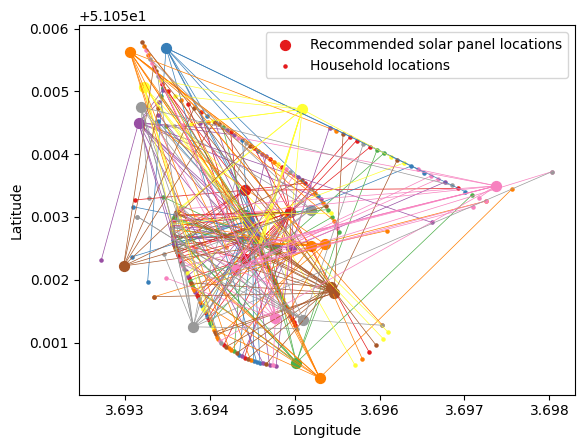

In [ ]:
# Plot resulting communities from baseline model
baseline.plot_energy_communities_map()

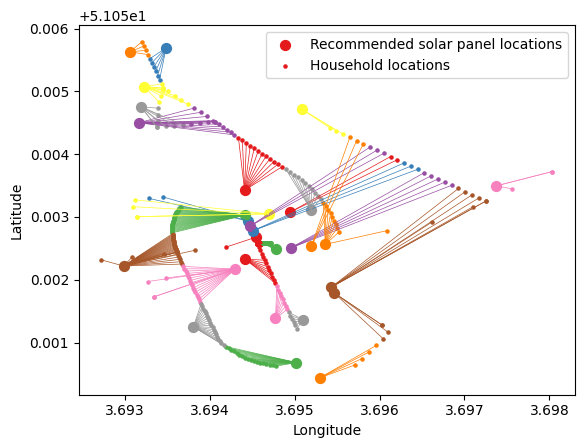

In [ ]:
# Plot resulting communities from k-means model
kmeans.plot_energy_communities_map()

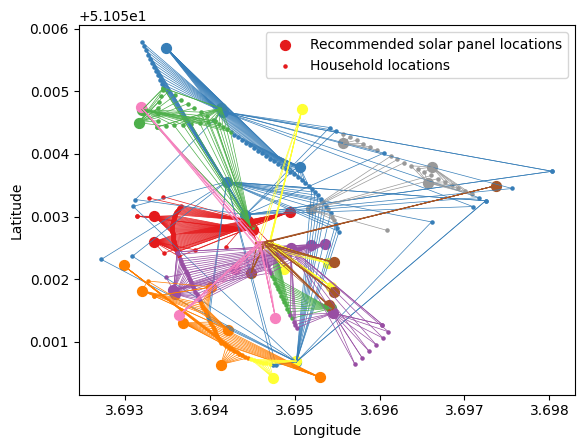

In [ ]:
# Plot resulting communities from optimisation model
optimisation.plot_energy_communities_map()

The custom optimisation model has produced energy communities that are visible clustered together geographically, although more spread out than the kmeans model. The kmeans model, while tightly clustered, ignores the geometry of roads and the social context that belonging to a street-based neighbourhood group brings.

Next we examine the other characteristics of the recommended energy communities.

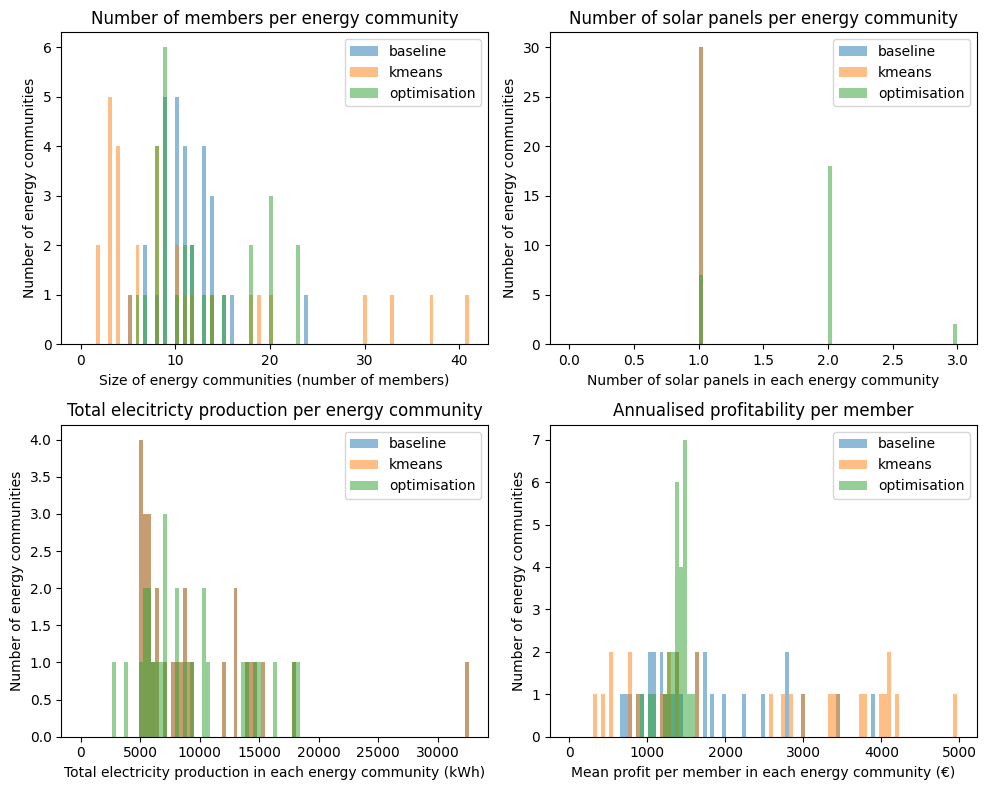

In [ ]:
# Create histograms showing the characteristics of recommended energy communities
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot number of members per energy community
max_n = 0
ax = axes[0][0]
for model in [baseline, kmeans, optimisation]:
  if model.final_energy_communities["households"].apply(len).max() > max_n:
    max_n = model.final_energy_communities["households"].apply(len).max()

for model in [baseline, kmeans, optimisation]:
  ax.hist(model.final_energy_communities["households"].apply(len), bins=np.linspace(0, max_n, 100), alpha=0.5)

ax.set_xlabel("Size of energy communities (number of members)")
ax.set_ylabel("Number of energy communities")
ax.legend(["baseline", "kmeans", "optimisation"])
ax.set_title("Number of members per energy community")


# Plot number of solar panels per energy community
max_n = 0
ax = axes[0][1]
for model in [baseline, kmeans, optimisation]:
  if model.final_energy_communities["pv_production"].apply(len).max() > max_n:
    max_n = model.final_energy_communities["pv_production"].apply(len).max()

for model in [baseline, kmeans, optimisation]:
  ax.hist(model.final_energy_communities["pv_production"].apply(len), bins=np.linspace(0, max_n, 100), alpha=0.5)

ax.set_xlabel("Number of solar panels in each energy community")
ax.set_ylabel("Number of energy communities")
ax.legend(["baseline", "kmeans", "optimisation"])
ax.set_title("Number of solar panels per energy community")


# Plot total electricity production per energy community
max_s = 0
ax = axes[1][0]
for model in [baseline, kmeans, optimisation]:
  if model.final_energy_communities["pv_production"].apply(sum).max() > max_s:
    max_s = model.final_energy_communities["pv_production"].apply(sum).max()

for model in [baseline, kmeans, optimisation]:
  ax.hist(model.final_energy_communities["pv_production"].apply(sum), bins=np.linspace(0, max_s, 100), alpha=0.5)

ax.set_xlabel("Total electricity production in each energy community (kWh)")
ax.set_ylabel("Number of energy communities")
ax.legend(["baseline", "kmeans", "optimisation"])
ax.set_title("Total elecitricty production per energy community")


# Plot total annualised profitability per member per energy community
max_p, min_p = 0, 0
ax = axes[1][1]
for model in [baseline, kmeans, optimisation]:
  profit = []
  for _, community in model.final_energy_communities.iterrows():
    profit.append(calculate_annualised_profit_per_member(pv_production=community["pv_production"], energy_consumption=community["energy_consumption"], pv_cost=community["installation_cost"], pv_lifespan=global_params["pv_lifespan"], feed_in_tariff=global_params["feed_in_tariff"], grid_price=global_params["grid_price"], fixed_fee=global_params["fixed_fee"], community_price=global_params["community_price"]))
  if max(profit) > max_p:
    max_p = max(profit)
  if min(profit) < min_p:
    min_p = min(profit)

for model in [baseline, kmeans, optimisation]:
  profit = []
  for _, community in model.final_energy_communities.iterrows():
    profit.append(calculate_annualised_profit_per_member(pv_production=community["pv_production"], energy_consumption=community["energy_consumption"], pv_cost=community["installation_cost"], pv_lifespan=global_params["pv_lifespan"], feed_in_tariff=global_params["feed_in_tariff"], grid_price=global_params["grid_price"], fixed_fee=global_params["fixed_fee"], community_price=global_params["community_price"]))
  ax.hist(profit, bins=np.linspace(min_p, max_p, 100), alpha=0.5)

ax.set_xlabel("Mean profit per member in each energy community (€)")
ax.set_ylabel("Number of energy communities")
ax.legend(["baseline", "kmeans", "optimisation"])
ax.set_title("Annualised profitability per member")


plt.tight_layout()
plt.show()

The custom optimisation model has the clear benefit of evenly spread mean profitability: this means all participants are treated fairly, with no energy community expected to profit substantially more than another.

### 5. Model interpretability and fairness

A big advantage of the models we have built is that the objective function is based on interpretable KPIs that can be adjusted to increase or decrease the importance of any factor, according what is deemed fairer. Additional KPIs can be added to measure, for example, the diversity of the members in an energy community to promote or reward energy communities that bring diverse people together to pool their resources.

Here we perform a sensitivity analysis to take advantage of the interpretability of our framework. Assuming an exemplar energy community, we can adjust its various characteristics and observe the effect on the KPIs and the objective function. This has several benefits:
* It allows us to assess the suitability of the objective function from a mathematical perspective, e.g. whether it smooth and convex for easy optimisation; whether the KPIs are appropriately scaled
* It allows us to assess the suitability of the objective function from a practical and ethical perspective, e.g. whether it rewards energy communities of a suitable size; whether start-up costs are kept low enough
* It allows us to see what are the most important factors or combinations of factors, for Ghent to know what to prioritise when recommending and supporting the formation of energy communities
* It allows a measure of uncertainty in the outcome according to the uncertainty in the input, for residents to know what their risks are

In [ ]:
# Use typical energy consumption and production values from Malem
ave_energy_consumption = np.round(energy_consumption["energy_consumption"].median(), -3)
typical_pv_production = np.round(pv_production["pv_production"].quantile(0.9), -3)
ave_installation_cost = np.round(pv_production["installation_cost"].median(), -3)
print(f"Using typical household energy consumption of {ave_energy_consumption:,} kWh")
print(f"Using typical solar panel production of {typical_pv_production:,}")
print(f"Using typical solar panel installation cost of €{ave_installation_cost:,}")

Using typical household energy consumption of 2,000.0 kWh
Using typical solar panel production of 5,000.0
Using typical solar panel installation cost of €2,000.0


In [ ]:
# Create exemplar energy community

# Solar panel production: one typical solar panel
ex_pv_production = pd.Series([x * typical_pv_production for x in [1]], name="pv_production").to_frame()

# Energy consumption: ten members, between 75% and 125% of average
ex_energy_consumption = pd.Series([x * ave_energy_consumption for x in np.linspace(0.75, 1.25, 10)], name="energy_consumption").to_frame()     # kWh

# Installation cost of solar panels: typical
ex_installation_cost = pd.Series([x * ave_installation_cost for x in [1]], name="installation_cost").to_frame()        # €
ex_pv_production = pd.concat([ex_pv_production, ex_installation_cost], axis=1)

# Print example community
print(ex_energy_consumption)
print(ex_pv_production)

# Other variables
pv_lifespan = 20                                                                                # years
feed_in_tariff = 0.0
grid_price = 14.94                                                                              # €/kWh
fixed_fee = 25                                                                                  # €
community_price = 13                                                                            # €/kWh

examplar_objective_value = objective_function(ex_pv_production, ex_energy_consumption, pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price, 0, False, verbose=True)
print(f"The examplar energy community has a cluster quality of {examplar_objective_value:,.1f}")

   energy_consumption
0         1500.000000
1         1611.111111
2         1722.222222
3         1833.333333
4         1944.444444
5         2055.555556
6         2166.666667
7         2277.777778
8         2388.888889
9         2500.000000
   pv_production  installation_cost
0         5000.0             2000.0

Calcuating objective metric for energy community with 10 members and 1 solar panels
Average profit per household €962.50
Multiplying by 0.99 for size of energy community
Multiplying by 0.95 for start-up cost per member
The examplar energy community has a cluster quality of 910.7


This example community has high start-up costs which makes the community both unprofitable and (for both of those metrics) low-scoring.

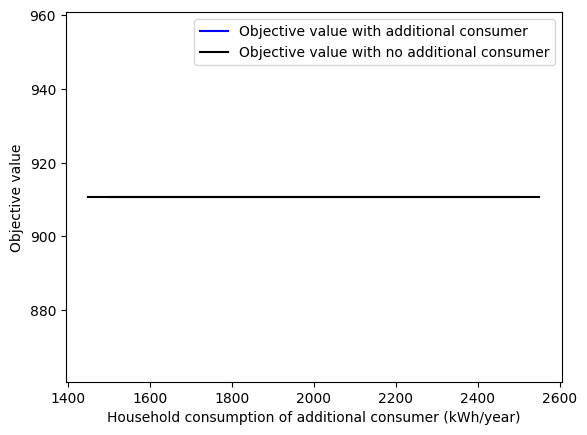

In [ ]:
# Sensitivity analysis: what is the effect of adding more consumers on the objective function?

# Add in the effect of one additional consumer, with varying household consumption
additional_consumers = [x * ave_energy_consumption for x in [0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25]]
obj_value = []
for additional_consumption in additional_consumers:
  ex_energy_consumption_tmp = ex_energy_consumption.copy(deep=True)
  energy_consumption_tmp = pd.concat([ex_energy_consumption_tmp, pd.Series({0: additional_consumption}, name="energy_consumption").to_frame()], axis=0)
  obj_value.append(objective_function(ex_pv_production, ex_energy_consumption_tmp, pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price, 0, False, False))

# Plot the mean profitability according to additional consumers
plt.plot(additional_consumers, obj_value, "b")
# Plot the baseline profitability for comparison
plt.plot(plt.gca().get_xlim(), [examplar_objective_value, examplar_objective_value], "k")
plt.xlabel("Household consumption of additional consumer (kWh/year)")
plt.ylabel("Objective value")
plt.legend(["Objective value with additional consumer", "Objective value with no additional consumer"])
plt.show()

This sensitivity plot shows that the consumption of additional consumers doesn't make a difference because more consumption per member just means more money paid to the grid. What matters is the number of consumers: an additional one means
* the limited supply of cheaper self-generated electricity must be shared across more households, so the average profitability decreases
* the small community penalty decreases
* the start-up cost per member decreases

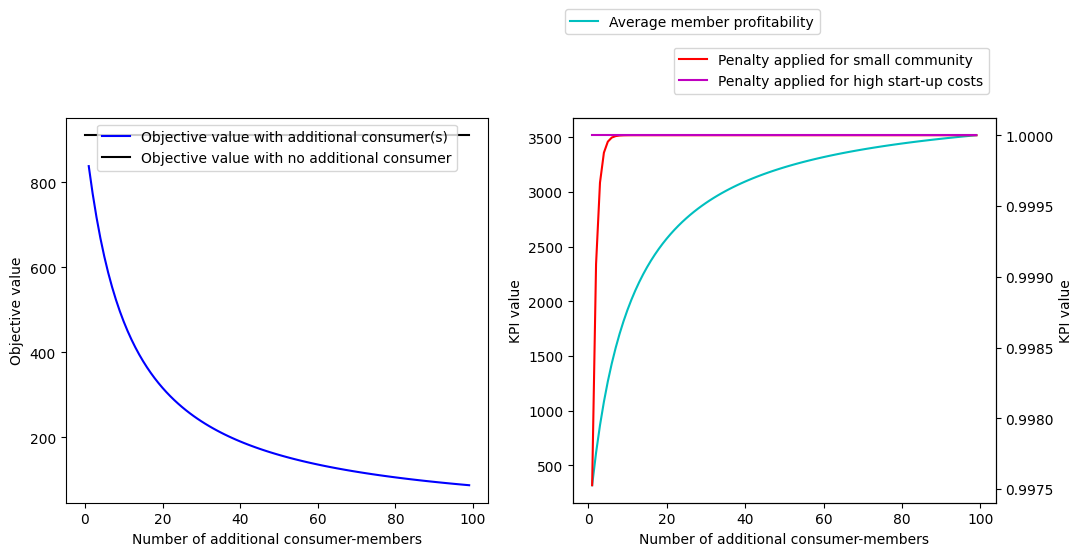

In [ ]:
# Sensitivity analysis: what is the effect of adding several more consumers on the objective function?

# Add in the effect of various additional consumers, all with the same household consumption
additional_consumption = [[ave_energy_consumption] * x for x in range(1, 100)]
obj_value = []
profitability = []
small_penalty = []
cost_penalty = []
for additional_consump in additional_consumption:
  energy_consumption_tmp = ex_energy_consumption.copy()
  energy_consumption_tmp = pd.concat([energy_consumption_tmp, pd.Series({i: additional_consump[i] for i in range(len(additional_consump))}, name="energy_consumption").to_frame()], axis=0)
  # Calculate objective value
  obj_value.append(objective_function(ex_pv_production, energy_consumption_tmp, pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price, 0, False))
  # Calculate first KPI
  profitability.append(calculate_annualised_profit_per_member(pv_production["pv_production"], energy_consumption_tmp["energy_consumption"], pv_production["installation_cost"], pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price))
  # Calculate second KPI
  small_penalty.append(small_community_penalty(len(energy_consumption_tmp)))
  # Calculate third KPI
  cost_penalty.append(startup_cost_penalty(len(energy_consumption_tmp), len(pv_production), sum(pv_production["installation_cost"])))

# Plot the mean profitability according to additional consumers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot([len(x) for x in additional_consumption], obj_value, "b")
# Plot the baseline profitability for comparison
ax[0].plot([0, len(additional_consumption[-1])], [examplar_objective_value, examplar_objective_value], "k")
ax[0].set_xlabel("Number of additional consumer-members")
ax[0].set_ylabel("Objective value")
ax[0].legend(["Objective value with additional consumer(s)", "Objective value with no additional consumer"])

# Plot the values of the KPIs
ax[1].plot([len(x) for x in additional_consumption], profitability, "c")
ax2 = ax[1].twinx()
ax2.plot([len(x) for x in additional_consumption], small_penalty, "r")
ax2.plot([len(x) for x in additional_consumption], cost_penalty, "m")
ax[1].legend(["Average member profitability"], bbox_to_anchor=(0.6, 1.3))
ax2.legend(["Penalty applied for small community", "Penalty applied for high start-up costs"], bbox_to_anchor=(1, 1.2))
ax[1].set_xlabel("Number of additional consumer-members")
ax[1].set_ylabel("KPI value")
ax2.set_ylabel("KPI value")

plt.axis('tight')
plt.show()

This plot shows how the objective function is influenced by the various KPIs. In our example with one typical solar panel, the more members the energy community has, the lower the score (blue line, left).

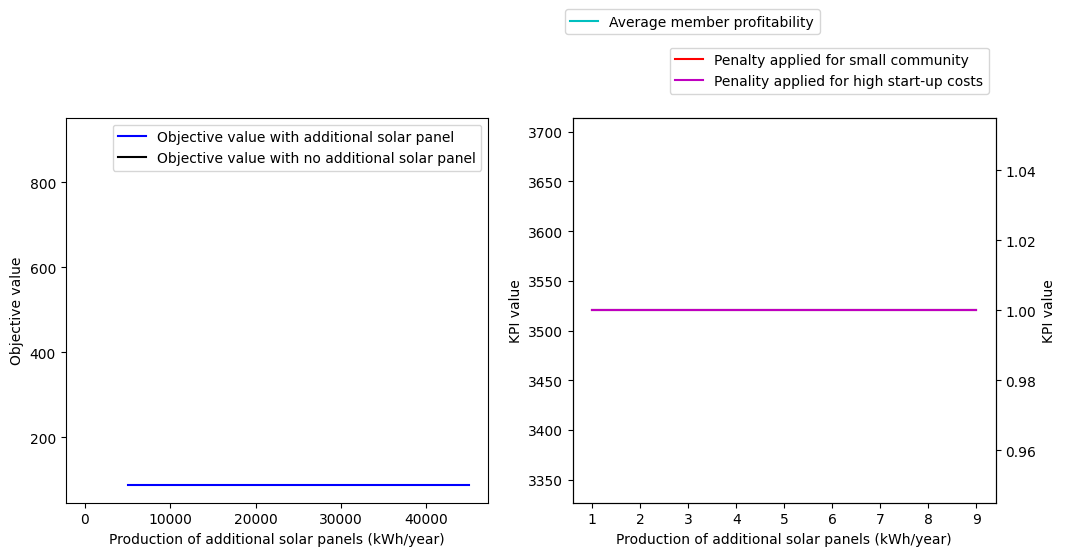

In [ ]:
# Sensitivity analysis: what is the effect of adding more solar panels on the objective function?

# Add in the effect of additional solar panels, all with the same wattage
additional_pv_production = [[typical_pv_production] * x for x in range(1, 10)]
additional_cost = [[ave_installation_cost] * x for x in range(1, 10)]
obj_value = []
profitability = []
small_penalty = []
cost_penalty = []
for additional_prod, additional_c in zip(additional_pv_production, additional_cost):
  pv_production_tmp = ex_pv_production.copy()
  pv_production_tmp = pd.concat([pv_production_tmp, pd.DataFrame({i: [p, c] for i, (p, c) in enumerate(zip(additional_prod, additional_c))}, index=["pv_production", "installation_cost"]).T], axis=0)
  obj_value.append(objective_function(ex_pv_production, energy_consumption_tmp, pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price, 0, False))
  # Calculate first KPI
  profitability.append(calculate_annualised_profit_per_member(pv_production["pv_production"], energy_consumption_tmp["energy_consumption"], pv_production["installation_cost"], pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price))
  # Calculate second KPI
  small_penalty.append(small_community_penalty(len(energy_consumption_tmp)))
  # Calculate third KPI
  cost_penalty.append(startup_cost_penalty(len(energy_consumption_tmp), len(pv_production), sum(pv_production["installation_cost"])))

  # Divya: calculate the carbon offset factor and append to the list here

# Plot the mean objective value according to additional electricity production
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot([sum(x) for x in additional_pv_production], obj_value, "b")
# Plot the baseline objective value for comparison
ax[0].plot(plt.gca().get_xlim(), [examplar_objective_value, examplar_objective_value], "k")
ax[0].set_xlabel("Production of additional solar panels (kWh/year)")
ax[0].set_ylabel("Objective value")
ax[0].legend(["Objective value with additional solar panel", "Objective value with no additional solar panel"])

# Plot the values of the KPIs
ax[1].plot([len(x) for x in additional_pv_production], profitability, "c")
ax2 = ax[1].twinx()
ax2.plot([len(x) for x in additional_pv_production], small_penalty, "r")
ax2.plot([len(x) for x in additional_pv_production], cost_penalty, "m")
ax[1].legend(["Average member profitability"], bbox_to_anchor=(0.6, 1.3))
ax2.legend(["Penalty applied for small community", "Penality applied for high start-up costs"], bbox_to_anchor=(1, 1.2))
ax[1].set_xlabel("Production of additional solar panels (kWh/year)")
ax[1].set_ylabel("KPI value")
ax2.set_ylabel("KPI value")

plt.axis('tight')
plt.show()

In [ ]:
# Sensitivity analysis: what is the effect of adding more members AND more solar panels on the objective function?

household_consumption_index = {"high": ave_energy_consumption*2, "medium": ave_energy_consumption, "low": ave_energy_consumption*0.5}
solar_panel_index = {"high": typical_pv_production*2, "medium": typical_pv_production, "low": typical_pv_production*0.5}
installation_cost_index = {"high": ave_installation_cost*2, "medium": ave_installation_cost, "low": ave_installation_cost*0.5}

def plot_2d_consumption_production_sensitivity(consumption_level, production_level, ax=None):

  additional_consumption = [[household_consumption_index[consumption_level]] * x for x in range(10, 500, 10)]
  additional_pv_production = [[solar_panel_index[production_level]] * x for x in range(1, 20)]
  additional_cost = [[installation_cost_index[production_level]] * x for x in range(1, 20)]
  obj_value = []
  for i, additional_consump in enumerate(additional_consumption):
    energy_consumption_tmp = ex_energy_consumption.copy()
    energy_consumption_tmp = pd.concat([energy_consumption_tmp, pd.Series({i: additional_consump[i] for i in range(len(additional_consump))}, name="energy_consumption").to_frame()], axis=0)
    obj_v = []
    for additional_prod, additional_c in zip(additional_pv_production, additional_cost):
      pv_production_tmp = ex_pv_production.copy()
      pv_production_tmp = pd.concat([pv_production_tmp, pd.DataFrame({i: [p, c] for i, (p, c) in enumerate(zip(additional_prod, additional_c))}, index=["pv_production", "installation_cost"]).T], axis=0)
      obj_v.append(objective_function(pv_production_tmp, energy_consumption_tmp, pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price, 0, False))
    obj_value.append(obj_v)

  # Plot
  if ax==None:
    fig, ax = plt.subplots()
  c = ax.pcolormesh([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose(), cmap="inferno")
  plt.colorbar(mappable=c).set_label("Objective value (capped at -1000)")
  ax.contour([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose())
  ax.set_xlabel("Number of members")
  ax.set_ylabel("Electricity production from solar panels")
  ax.set_title(f"{consumption_level} average household consumption\n{production_level} solar panel capacity")

  return ax

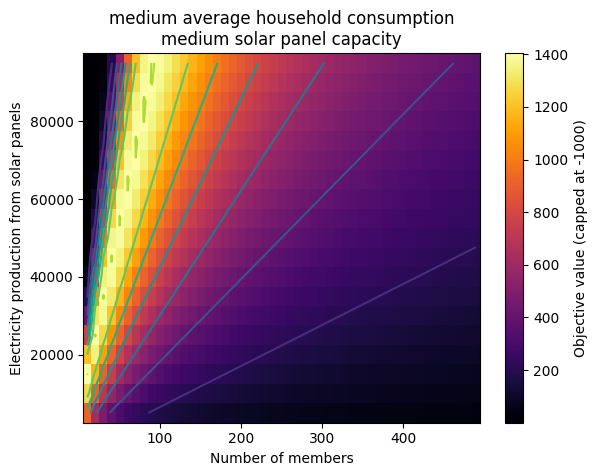

In [ ]:
# Sensitivity analysis for medium-capacity solar panels and medium consumption of households
plot_2d_consumption_production_sensitivity(consumption_level="medium", production_level="medium")
plt.show()

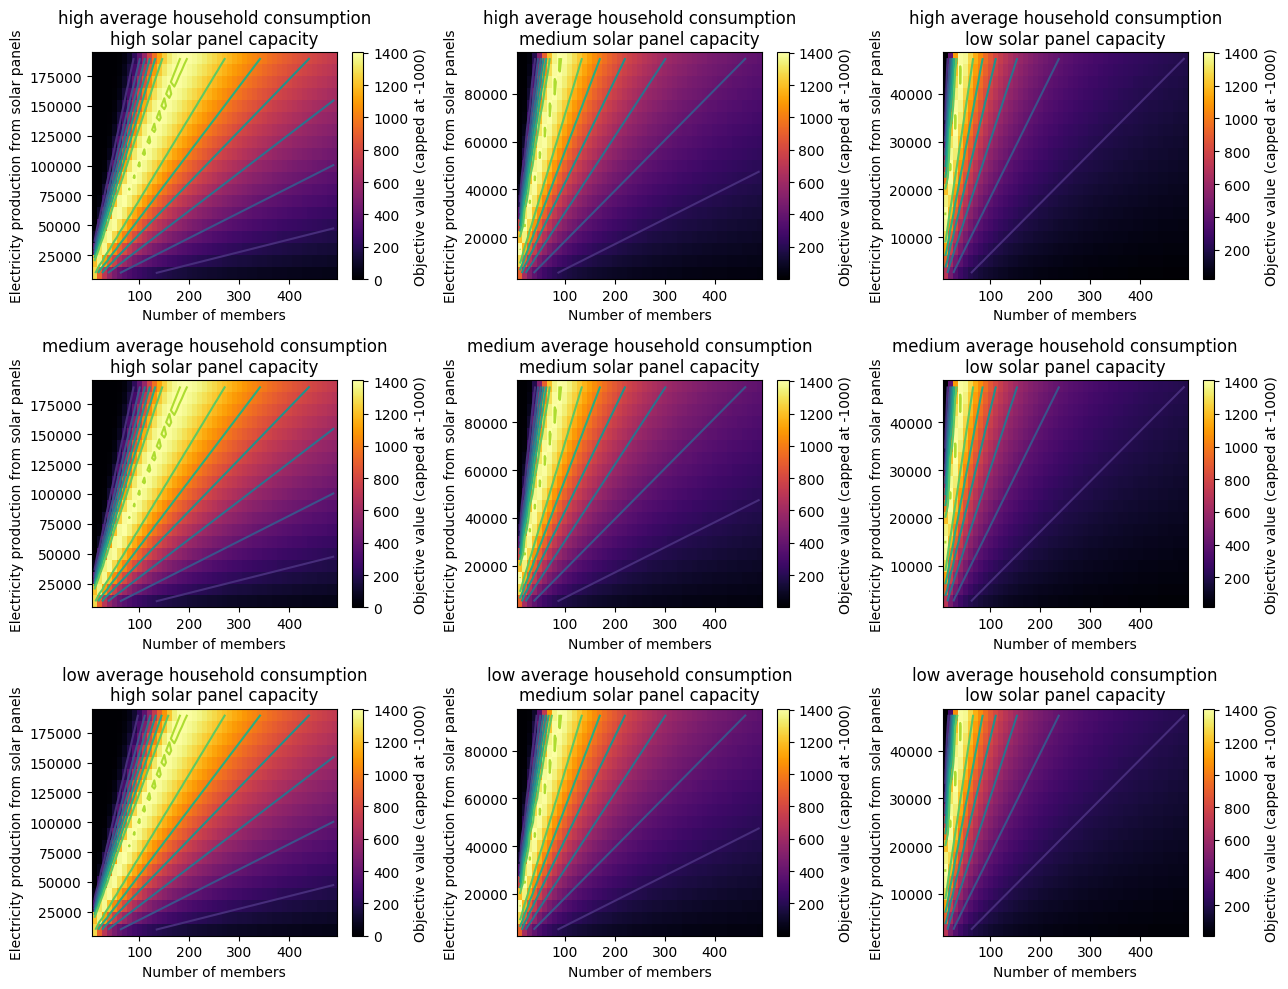

In [ ]:
# Sensitivity analysis for all combinations of solar panels and household consumption

fig, ax = plt.subplots(3, 3, figsize=(13, 10))

for i, i_lvl in enumerate(["high", "medium", "low"]):
  for j, j_lvl in enumerate(["high", "medium", "low"]):
    ax[i][j] = plot_2d_consumption_production_sensitivity(consumption_level=i_lvl, production_level=j_lvl, ax=ax[i][j])

fig.tight_layout()

The highest objective value is obtained at a fixed ratio of number of members in the energy community to electricity production. Intuitively, higher the capacity of the solar panels installed, the more members it can support.

Energy poverty, the need to reduce bills, and the challenge of start-up capital are the focus of our solution, so we examine the financial aspects that contribute to this objective value.

In [ ]:
# Sensitivity analysis: profitability

household_consumption_index = {"high": ave_energy_consumption*2, "medium": ave_energy_consumption, "low": ave_energy_consumption*0.5}
solar_panel_index = {"high": typical_pv_production*2, "medium": typical_pv_production, "low": typical_pv_production*0.5}
installation_cost_index = {"high": ave_installation_cost*2, "medium": ave_installation_cost, "low": ave_installation_cost*0.5}

def plot_2d_consumption_production_sensitivity_profit(consumption_level, production_level, ax=None):

  additional_consumption = [[household_consumption_index[consumption_level]] * x for x in range(10, 500, 10)]
  additional_pv_production = [[solar_panel_index[production_level]] * x for x in range(1, 20)]
  additional_cost = [[installation_cost_index[production_level]] * x for x in range(1, 20)]
  obj_value = []
  for i, additional_consump in enumerate(additional_consumption):
    energy_consumption_tmp = ex_energy_consumption.copy()
    energy_consumption_tmp = pd.concat([energy_consumption_tmp, pd.Series({i: additional_consump[i] for i in range(len(additional_consump))}, name="energy_consumption").to_frame()], axis=0)
    obj_v = []
    for additional_prod, additional_c in zip(additional_pv_production, additional_cost):
      pv_production_tmp = ex_pv_production.copy()
      pv_production_tmp = pd.concat([pv_production_tmp, pd.DataFrame({i: [p, c] for i, (p, c) in enumerate(zip(additional_prod, additional_c))}, index=["pv_production", "installation_cost"]).T], axis=0)
      obj_v.append(calculate_annualised_profit_per_member(pv_production_tmp["pv_production"], energy_consumption_tmp["energy_consumption"], pv_production_tmp["installation_cost"], pv_lifespan, feed_in_tariff, grid_price, fixed_fee, community_price))
    obj_value.append(obj_v)

  # Plot
  if ax==None:
    fig, ax = plt.subplots()
  c = ax.pcolormesh([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose(), cmap="inferno")
  plt.colorbar(mappable=c).set_label("Annualised profitability")
  ax.contour([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose())
  ax.set_xlabel("Number of members")
  ax.set_ylabel("Solar panel capacity")
  ax.set_title(f"{consumption_level} average household consumption\n{production_level} solar panel capacity")

  return ax

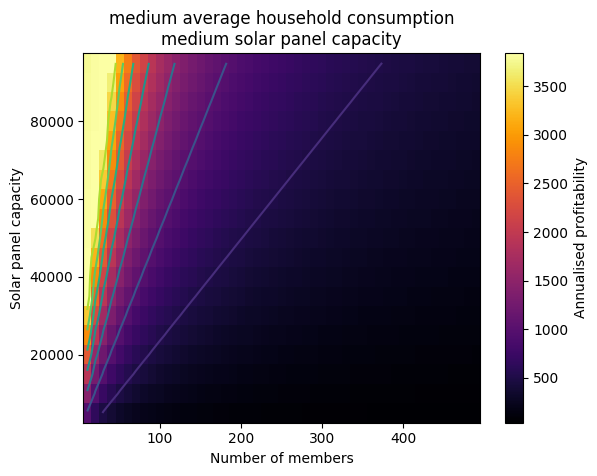

In [ ]:
# Sensitivity analysis for medium-capacity solar panels and medium consumption of households
plot_2d_consumption_production_sensitivity_profit(consumption_level="medium", production_level="medium")
plt.show()

The annualised profitability is strongly influenced by the number of members, and very simply the more members there are the lower the profits. This would be an argument for keeping energy comunities low, but...

In [ ]:
# Sensitivity analysis: start-up cost

household_consumption_index = {"high": ave_energy_consumption*2, "medium": ave_energy_consumption, "low": ave_energy_consumption*0.5}
solar_panel_index = {"high": typical_pv_production*2, "medium": typical_pv_production, "low": typical_pv_production*0.5}
installation_cost_index = {"high": ave_installation_cost*2, "medium": ave_installation_cost, "low": ave_installation_cost*0.5}

def plot_2d_consumption_production_sensitivity_startup(consumption_level, production_level, ax=None):

  additional_consumption = [[household_consumption_index[consumption_level]] * x for x in range(10, 500, 10)]
  additional_pv_production = [[solar_panel_index[production_level]] * x for x in range(1, 20)]
  additional_cost = [[installation_cost_index[production_level]] * x for x in range(1, 20)]
  obj_value = []
  for i, additional_consump in enumerate(additional_consumption):
    energy_consumption_tmp = ex_energy_consumption.copy()
    energy_consumption_tmp = pd.concat([energy_consumption_tmp, pd.Series({i: additional_consump[i] for i in range(len(additional_consump))}, name="energy_consumption").to_frame()], axis=0)
    obj_v = []
    for additional_prod, additional_c in zip(additional_pv_production, additional_cost):
      pv_production_tmp = ex_pv_production.copy()
      pv_production_tmp = pd.concat([pv_production_tmp, pd.DataFrame({i: [p, c] for i, (p, c) in enumerate(zip(additional_prod, additional_c))}, index=["pv_production", "installation_cost"]).T], axis=0)
      obj_v.append(sum(pv_production_tmp["installation_cost"]) / len(energy_consumption_tmp))
    obj_value.append(obj_v)

  # Plot
  if ax==None:
    fig, ax = plt.subplots()
  c = ax.pcolormesh([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose(), cmap="inferno")
  plt.colorbar(mappable=c).set_label("Start-up cost per member (€)")
  ax.contour([len(x) for x in additional_consumption], [sum(x) for x in additional_pv_production], np.array(obj_value).transpose())
  ax.set_xlabel("Number of members")
  ax.set_ylabel("Solar panel capacity")
  ax.set_title(f"{consumption_level} average household consumption\n{production_level} solar panel capacity")

  return ax

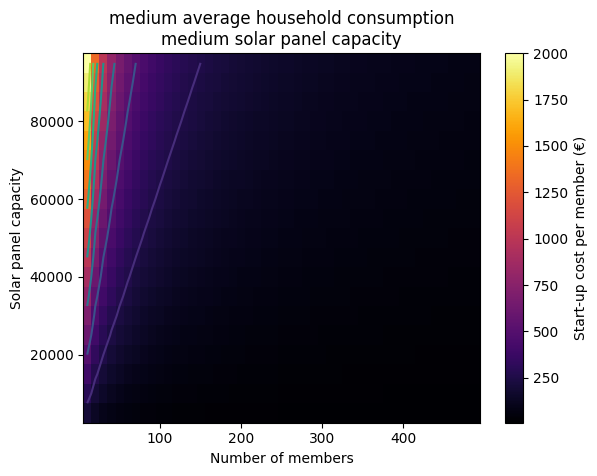

In [ ]:
# Sensitivity analysis for medium-capacity solar panels and medium consumption of households
plot_2d_consumption_production_sensitivity_startup(consumption_level="medium", production_level="medium")
plt.show()

...in proportion to higher profits are high start-up costs, which are prohibitive for households that are already experiencing energy poverty. This is a crucial factor for the Ghent authorities to consider: residents will not benefit without some help to gather the necessary start-up capital, whether from grants, low-interest loans, partnerships with local businesses, or other innovations. There is an inherent unfairness to the business model that the more one can invest in solar panels the more one gets in return, but those who need it most are least able to invest.

### Conclusion and Recommendation

We have developed a way to automate the recommendation of energy communities and solar panels, depending on various flexible assumptions, that performs better than either a random baseline or a simple k-means model. Our objective was to optimize energy communities based on four key performance indicators (KPIs) related to financial, social, logistical, and socioeconomic aspects. It is important to note that energy communities are not always profitable; but, nevertheless, we have found that, with the right modelling, members of energy communities could save over €1000 on their annual energy bills in Malem in addition to benefits from reduced carbon emissions and better social cohesion.

For Ghent authorities, there are some takeaways from our analysis of the modelling results: first, the highest quality of energy community is obtainable with a fixed ratio of the number of members in the energy community to electricity production. This means that, although our modelling assumes that every single recommended member of an energy community joins, the solar panel capacity can be scaled down as required to match the number of willing members without detriment to the energy quality (except at extremes). Our solution is therefore robust to the real-world constraints of recruiting people to energy communities.

Secondly, with the main focus of our solution being on addressing energy poverty, reducing bills, and overcoming the challenge of start-up capital, we examined the financial aspects that contribute to the objective value. Annualized profitability per member is known to be crucial in attracting and retaining members, ensuring they see a financial return on their investment [1]. However, our analysis showed that the greatest profitability comes with the greatest start-up capital, a factor that is known to be a source of energy injustice [2]. We encouraged energy communities with a start-up cost of less than €250 to reduce the financial barriers to joining, but even this much will be unaffordable to many households, especially those in energy poverty [2]. Poorer households will likely need access to some financing help (loans or grants) to meet this cost, and it should be noted that higher financing aid at the point of start-up capital will translate to greater benefits for energy-poor community members. Other "business models" apart from the cooperative model that we assumed here could also be modelled, for example subsided shares in the enegy community in proportion to household income.

We focused on four KPIs in this solution, but there is a range of other KPIs that could be used to measure energy community quality, depending on the data available [3]. City authorities may wish to include or exclude these KPIs according to their priorities. Some of the KPIs we considered but didn't include are:
* Environmental: carbon emissions reduction, i.e. how much carbon is saved by switching from hybrid to renewable energy
* Financial and environmental: self-sufficiency, i.e. the ratio of production to consumption, which means members are getting more of their energy from cheaper, renewable sources
* Financial and logistical: self-consupmtion, i.e. the ratio of consumption to production, which means that generated electricity does not need to be stored on batteries, sold or wasted through inefficiency
* Logistical/technical: peak capacity, i.e. the danger of causing expensive damage by overloading the grid
* Social: diversity of the energy community, either socioeconomic, gender, or otherwise


Overall, our approach provides a foundation for recommending and supporting the formation of energy communities by prioritizing key factors and considering uncertainties in the outcomes. It offers insights for Ghent to make informed decisions when promoting energy communities and helps residents understand the associated risks and benefits. The outcome of this modelling can be used to make specific recommendations to residents of Ghent, persuade them of the personalised benefits of joining an energy community, and give tailored information to people who are time-poor, resource-poor and energy-poor.


### 👓 References

[1] Conradie, P. D., De Ruyck, O., Saldien, J., & Ponnet, K. (2021). Who wants to join a renewable energy community in Flanders? Applying an extended model of Theory of Planned Behaviour to understand intent to participate. Energy Policy, 151, 112121.

[2] Hanke, F., Guyet, R., & Feenstra, M. (2021). Do renewable energy communities deliver energy justice? Exploring insights from 71 European cases. Energy Research & Social Science, 80, 102244.

[3] Bianco, G., Bonvini, B., Bracco, S., Delfino, F., Laiolo, P., & Piazza, G. (2021). Key Performance Indicators for an Energy Community based on sustainable technologies. Sustainability, 13(16), 8789.

Additional references
- Electricity price for Belgium : https://www.energyprice.be/blog/electricity-price-belgium/
- About renewable energy communities : https://www.sciencedirect.com/science/article/pii/S030626192200753X?via%3Dihub
- Cost of solar panels: https://www.sciencedirect.com/science/article/pii/S030626192200753X
- Estimated hours of sunshine in Belgium: https://www.statista.com/statistics/525928/hours-of-sunshine-in-belgium/
https://statbel.fgov.be/en/open-data/population-statistical-sector-2

### Appendix : Data quality

Number of municipalities in Street level data

In [ ]:
df_energy_consumption_street_level[df_energy_consumption_street_level['Regio']=='Regio 1']['Main municipality'].value_counts()

ANTWERPEN             56396
GENT                  51238
BRUGGE                29138
KORTRIJK              20808
LEUVEN                17736
                      ...  
Onbekend                  3
TUBEKE                    2
BAARLE-NASSAU (NL)        2
BERLOZ                    1
BRUSSEL                   1
Name: Main municipality, Length: 322, dtype: int64

**Monthly Energy Consumption Data**

- Filter for Gent Municipality Data
- Translate Dutch data to English
- Drop uncessary columns - Regio, this has only one value , hence disregarded as indicated in data dictionary

In [ ]:
df_energy_consumption_monthly_gent_pre = df_energy_consumption_monthly[df_energy_consumption_monthly['Main municipality']=='GENT']
columns = ['Energy']
# Display the DataFrame with translated column values
df_energy_consumption_monthly_gent = translate_data(df_energy_consumption_monthly_gent_pre, columns)
# Drop columns by specifying column names
columns_to_drop = ['Regio']
df_energy_consumption_monthly_gent = df_energy_consumption_monthly_gent.drop(columns=columns_to_drop)
df_energy_consumption_monthly_gent.to_csv(os.path.join(datapath, 'Processed data/df_energy_consumption_monthly_gent.csv'), index=False)

**What is SLP?**

Synthetic Load Profile (SLP) refers to a representation of the electricity consumption pattern of a particular group or category of consumers over a specific period of time. It is a synthetic or simulated profile derived from aggregated historical electricity consumption data.

SLPs are often used in the energy industry for various purposes, including load forecasting, energy planning, grid management, and tariff design. They provide insights into the typical consumption patterns of different consumer segments, such as residential, commercial, or industrial customers, and can help in understanding and predicting their electricity demand.


Electricity consumption profiles
- S22 is a consumption profile of a household consumer with a night-day ratio >= 1.3. People with accumulation heating (excluding night meter) are usually included in this profile.
- S11 is a consumption profile for non-household customers with a connection capacity < 56 kVA .
- S12 is a consumption profile for non-household customers with a connection capacity > 56 kVA.

Natural gas consumption profiles:
- S31 is a consumption profile of a professional natural gas consumer with a consumption of <150,000 kWh.
- S32 is a consumption profile of a professional natural gas customer with a consumption of >=150,000 kWh.

In [ ]:
df_energy_consumption_monthly_gent.head()

,Main municipality,Energy,SLP,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,202009
214,GENT,Electricity,S10,78040549.35,73759152.34,70191753.56,78471353.86,72413505.49,77385776.49,81589213.60,71942261.71,78968063.82,75659155.47,74304843.07,78918369.61,76863411.07
1110,GENT,Electricity,S11,12889605.95,12411738.08,12517111.60,13023188.20,13099805.56,13646019.94,15591795.81,15115871.23,17165216.84,16822614.47,15349716.03,14981115.76,13873587.83
1111,GENT,Electricity,S22,5207303.14,5202798.86,5046312.05,4897959.95,5612525.68,6390145.91,8253110.62,8761594.84,10356877.13,9721693.85,8075738.67,6643587.16,5307511.05
1963,GENT,Natural gas,S30,20627299.21,20121701.94,18496912.40,24868448.14,26281068.87,28708435.17,28875491.46,26455207.10,29271267.68,27396163.18,24669190.38,26239874.89,22273531.26
1964,GENT,Natural gas,S31,8986682.78,8240128.02,7795280.33,8006752.81,21499920.30,35800000.32,42624918.04,49786142.75,67007219.58,51961650.91,32868489.66,23499623.71,10426171.58


In [ ]:
# Filter the DataFrame for electricity SLPs
df_electricity = df_energy_consumption_monthly_gent[df_energy_consumption_monthly_gent['Energy'] == 'Electricity']

# Create lists for months, slp_s10, slp_s11
months = df_energy_consumption_monthly_gent.columns[3:].tolist()

slp_s10 = df_electricity[df_electricity['SLP'] == 'S10'][months].values.flatten().tolist()
slp_s11 = df_electricity[df_electricity['SLP'] == 'S11'][months].values.flatten().tolist()
slp_s22 = df_electricity[df_electricity['SLP'] == 'S22'][months].values.flatten().tolist()


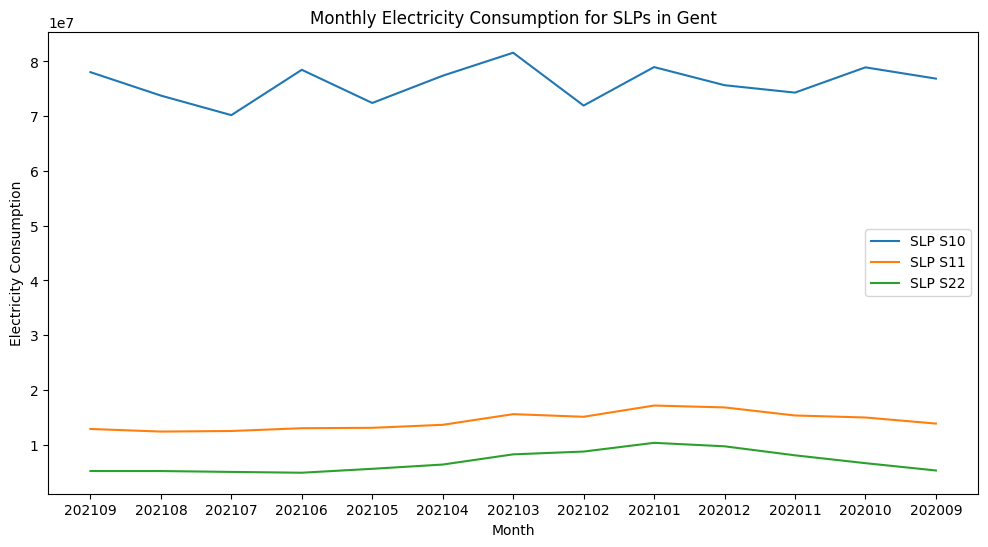

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(months, slp_s10, label='SLP S10')
plt.plot(months, slp_s11, label='SLP S11')
plt.plot(months, slp_s22, label='SLP S22')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Electricity Consumption')
plt.title('Monthly Electricity Consumption for SLPs in Gent')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
df_gas = df_energy_consumption_monthly_gent[df_energy_consumption_monthly_gent['Energy'] == 'Electricity']
natural_gas_s30 = df_gas[df_gas['SLP'] == 'S30'][months].values.flatten().tolist()
natural_gas_s31 = df_gas[df_gas['SLP'] == 'S31'][months].values.flatten().tolist()

Total energy consumption data by energy type

In [ ]:
# Total energy consumption data by energy type
energy_types = ['Electricity SLP', 'Natural gas S30', 'Natural gas S31']
total_energy = [sum(slp_s10) + sum(slp_s11) + sum(slp_s22), sum(natural_gas_s30), sum(natural_gas_s31)]


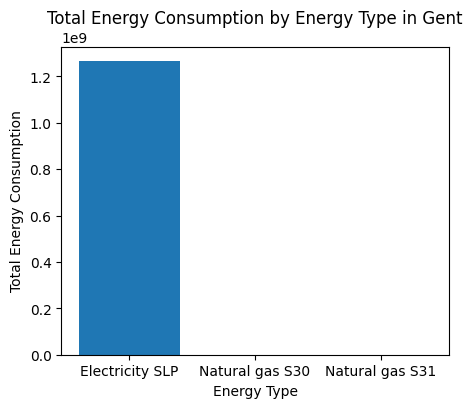

In [ ]:
# Plotting the data
plt.figure(figsize=(5, 4))
plt.bar(energy_types, total_energy)

# Adding labels and title
plt.xlabel('Energy Type')
plt.ylabel('Total Energy Consumption')
plt.title('Total Energy Consumption by Energy Type in Gent')

# Displaying the plot
plt.show()

**Energy storage systems connected to the distribution network (some data 2018-2020, mostly 2021-2022)**

Energy storage systems connected to the distribution network refer to devices or systems that store energy and are directly connected to the local electricity distribution network. These systems are designed to store excess electricity during times of low demand or high renewable energy generation and release it back into the grid during periods of high demand or low renewable energy generation.

Energy storage systems play a crucial role in balancing the supply and demand of electricity, optimizing the integration of renewable energy sources, and improving the stability and reliability of the grid. They can store energy in various forms such as batteries, pumped hydro storage, flywheels, compressed air, or thermal storage.



In [ ]:
columns = ['Type of technology']
df_energy_storage_systems = translate_data(df_energy_storage_systems, columns)

In [ ]:
df_energy_storage_systems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35850 entries, 0 to 35849
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month in service        35834 non-null  object 
 1   Year of commissioning   35834 non-null  float64
 2   month of commissioning  35834 non-null  float64
 3   Type of technology      35850 non-null  object 
 4   Capacity (kWh)          35836 non-null  float64
 5   Inverter power (kVA)    35850 non-null  float64
 6   LS/MS                   35845 non-null  object 
 7   Unique_order_ID         35850 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 2.2+ MB


In [ ]:
df_energy_storage_systems['Type of technology'].value_counts()

Home battery    35850
Name: Type of technology, dtype: int64

The energy storage systems data provided is mainly for "Home battery"

**Rent Prices for Gent**




In [ ]:
df_ghent_rent_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              439 non-null    int64  
 1   id                      439 non-null    int64  
 2   type                    439 non-null    object 
 3   bedroomCount            439 non-null    int64  
 4   price_type              439 non-null    object 
 5   price_main_value        439 non-null    int64  
 6   price_additional_value  248 non-null    float64
 7   country                 439 non-null    object 
 8   region                  439 non-null    object 
 9   province                439 non-null    object 
 10  district                439 non-null    object 
 11  locality                439 non-null    object 
 12  postal_code             439 non-null    int64  
 13  street                  428 non-null    object 
 14  street_number           425 non-null    ob

Drop Unnamed and id, columns which are not relevant

In [ ]:
df_ghent_rent_prices.drop(columns = ['Unnamed: 0', 'id'],inplace=True)

In [ ]:
df_ghent_rent_prices['type'].value_counts()

APARTMENT    439
Name: type, dtype: int64

In [ ]:
df_ghent_rent_prices['price_type'].value_counts()

residential_monthly_rent    439
Name: price_type, dtype: int64

- Rent price data contains all apartments in Gent
- price type is monthly rent

### Appendix : EDA Insights

**Energy Consumption by Year**

Energy Consumption Trend:


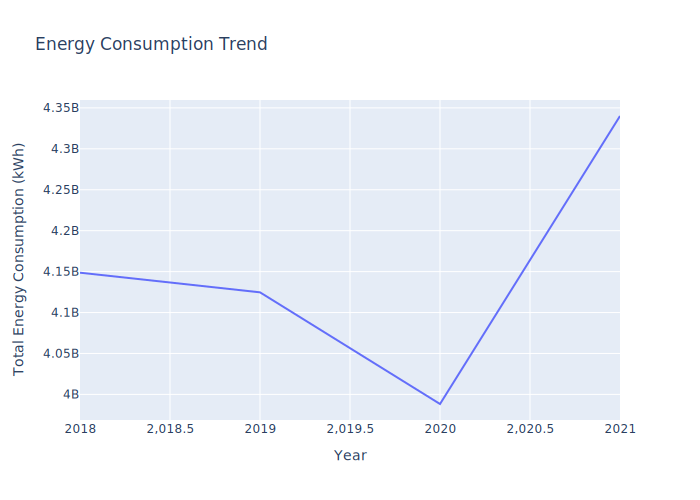

In [ ]:
total_consumption_per_year = df_energy_consumption_sector_gent.groupby('Consumption year')['Approximate Consumption (kWh)'].sum().reset_index()
# Print the trend of energy consumption over the years
print("Energy Consumption Trend:")
# Plot the trend of energy consumption
fig = px.line(total_consumption_per_year, x='Consumption year', y='Approximate Consumption (kWh)', title='Energy Consumption Trend')
fig.update_traces(marker=dict(symbol='circle', size=8))
fig.update_layout(xaxis_title='Year', yaxis_title='Total Energy Consumption (kWh)')
fig.show("svg")

Energy Consumption by Market

In [ ]:
# Calculate the total energy consumption for electricity market
total_electricity_consumption = df_energy_consumption_sector_gent[df_energy_consumption_sector_gent['Market'] == 'Electricity']['Approximate Consumption (kWh)'].sum()

# Calculate the total energy consumption for gas market
total_gas_consumption = df_energy_consumption_sector_gent[df_energy_consumption_sector_gent['Market'] == 'Natural gas']['Approximate Consumption (kWh)'].sum()

# Calculate the total energy consumption for all markets
total_energy_consumption = df_energy_consumption_sector_gent['Approximate Consumption (kWh)'].sum()

# Calculate the percentage contribution of electricity consumption
electricity_percentage = (total_electricity_consumption / total_energy_consumption) * 100

# Calculate the percentage contribution of gas consumption
gas_percentage = (total_gas_consumption / total_energy_consumption) * 100

# Print the results
print("Energy Consumption by Market:")
print("Electricity: {:.2f}%".format(electricity_percentage))
print("Gas: {:.2f}%".format(gas_percentage))


Energy Consumption by Market:
Electricity: 39.05%
Gas: 60.95%


Percentage of Total Energy Consumption

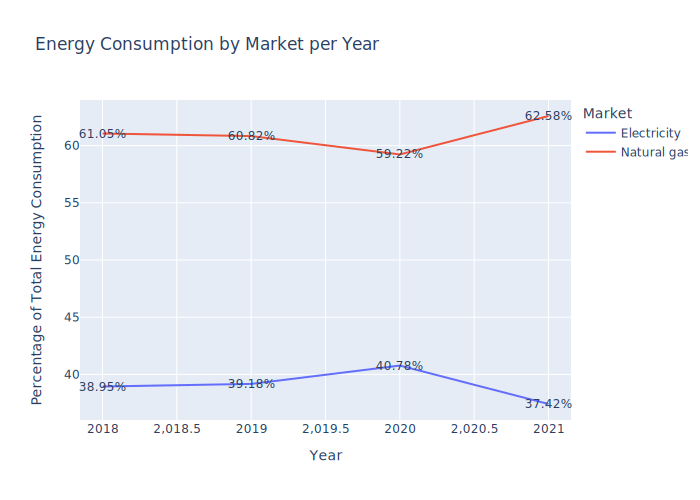

In [ ]:
# Group the data by year and market and calculate the total energy consumption for each group
total_consumption_per_year_market = df_energy_consumption_sector_gent.groupby(['Consumption year', 'Market'])['Approximate Consumption (kWh)'].sum().reset_index()

# Calculate the total energy consumption per year
total_consumption_per_year = total_consumption_per_year_market.groupby('Consumption year')['Approximate Consumption (kWh)'].sum().reset_index()

# Calculate the percentage contribution of each market
total_consumption_per_year_market = total_consumption_per_year_market.merge(total_consumption_per_year, on='Consumption year', suffixes=('', '_total'))
total_consumption_per_year_market['Percentage'] = (total_consumption_per_year_market['Approximate Consumption (kWh)'] / total_consumption_per_year_market['Approximate Consumption (kWh)_total']) * 100

# Plot the energy consumption by market per year as a line chart
fig = px.line(total_consumption_per_year_market, x='Consumption year', y='Percentage', color='Market',
              title='Energy Consumption by Market per Year')
fig.update_layout(xaxis_title='Year', yaxis_title='Percentage of Total Energy Consumption', hovermode='closest')

# Add data labels to the line chart
annotations = []
for row in total_consumption_per_year_market.itertuples():
    annotation = dict(x=row[1], y=row[5], text=f"{row[5]:.2f}%", showarrow=False)
    annotations.append(annotation)
fig.update_layout(annotations=annotations)

fig.show("svg")


Total energy consumption for offtake and injection

In [ ]:
# Calculate the total energy consumption for offtake
total_offtake_consumption = df_energy_consumption_sector_gent[df_energy_consumption_sector_gent['direction'] == 'Decrease']['Approximate Consumption (kWh)'].sum()

# Calculate the total energy consumption for injection
total_injection_consumption = df_energy_consumption_sector_gent[df_energy_consumption_sector_gent['direction'] == 'Injection']['Approximate Consumption (kWh)'].sum()

# Calculate the total energy consumption for all directions
total_energy_consumption = df_energy_consumption_sector_gent['Approximate Consumption (kWh)'].sum()

# Calculate the proportion of energy consumption attributed to offtake
offtake_proportion = (total_offtake_consumption / total_energy_consumption) * 100

# Calculate the proportion of energy consumption attributed to injection
injection_proportion = (total_injection_consumption / total_energy_consumption) * 100

# Print the results
print("Energy Consumption by Direction:")
print("Offtake (Decrease): {:.2f}%".format(offtake_proportion))
print("Injection: {:.2f}%".format(injection_proportion))


Energy Consumption by Direction:
Offtake (Decrease): 95.84%
Injection: 4.16%


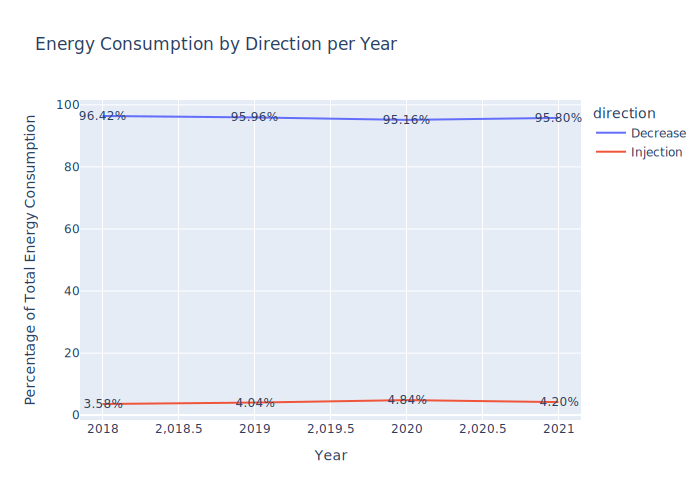

In [ ]:
# Group the data by year and direction and calculate the total energy consumption for each group
total_consumption_per_year_direction = df_energy_consumption_sector_gent.groupby(['Consumption year', 'direction'])['Approximate Consumption (kWh)'].sum().reset_index()

# Calculate the total energy consumption per year
total_consumption_per_year = total_consumption_per_year_direction.groupby('Consumption year')['Approximate Consumption (kWh)'].sum().reset_index()

# Calculate the percentage contribution of each direction
total_consumption_per_year_direction = total_consumption_per_year_direction.merge(total_consumption_per_year, on='Consumption year', suffixes=('', '_total'))
total_consumption_per_year_direction['Percentage'] = (total_consumption_per_year_direction['Approximate Consumption (kWh)'] / total_consumption_per_year_direction['Approximate Consumption (kWh)_total']) * 100

# Plot the energy consumption by direction per year as a line chart
fig = px.line(total_consumption_per_year_direction, x='Consumption year', y='Percentage', color='direction',
              title='Energy Consumption by Direction per Year')
fig.update_layout(xaxis_title='Year', yaxis_title='Percentage of Total Energy Consumption', hovermode='closest')

# Add data labels to the line chart
annotations = []
for row in total_consumption_per_year_direction.itertuples():
    annotation = dict(x=row[1], y=row[5], text=f"{row[5]:.2f}%", showarrow=False)
    annotations.append(annotation)
fig.update_layout(annotations=annotations)

fig.show("svg")


Energy Consumption by Sector

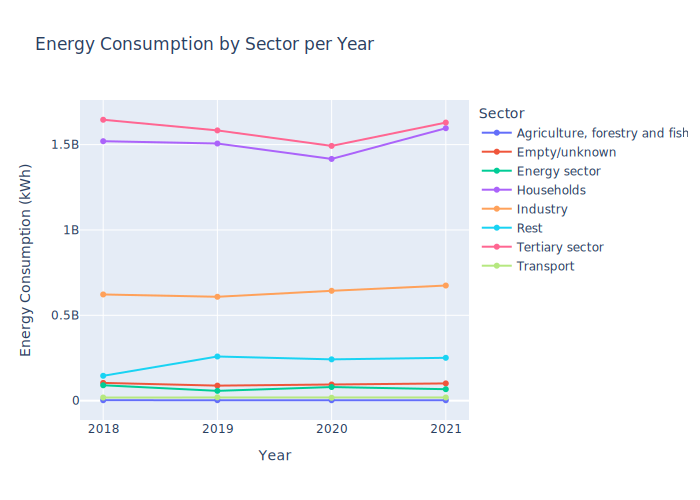

In [ ]:
# Group the data by year and sector and calculate the total energy consumption for each group
total_consumption_per_year_sector = df_energy_consumption_sector_gent.groupby(['Consumption year', 'Sector'])['Approximate Consumption (kWh)'].sum().reset_index()

# Plot the energy consumption by sector per year as a line chart with data points
fig = px.line(total_consumption_per_year_sector, x='Consumption year', y='Approximate Consumption (kWh)', color='Sector',
              title='Energy Consumption by Sector per Year', markers=True)
fig.update_layout(xaxis_title='Year', yaxis_title='Energy Consumption (kWh)')

fig.show("svg")


There are totally 9 sector, with Tertiary sector being highest followed by Household and Industry

**Energy Consumption by Subsector within Sector**

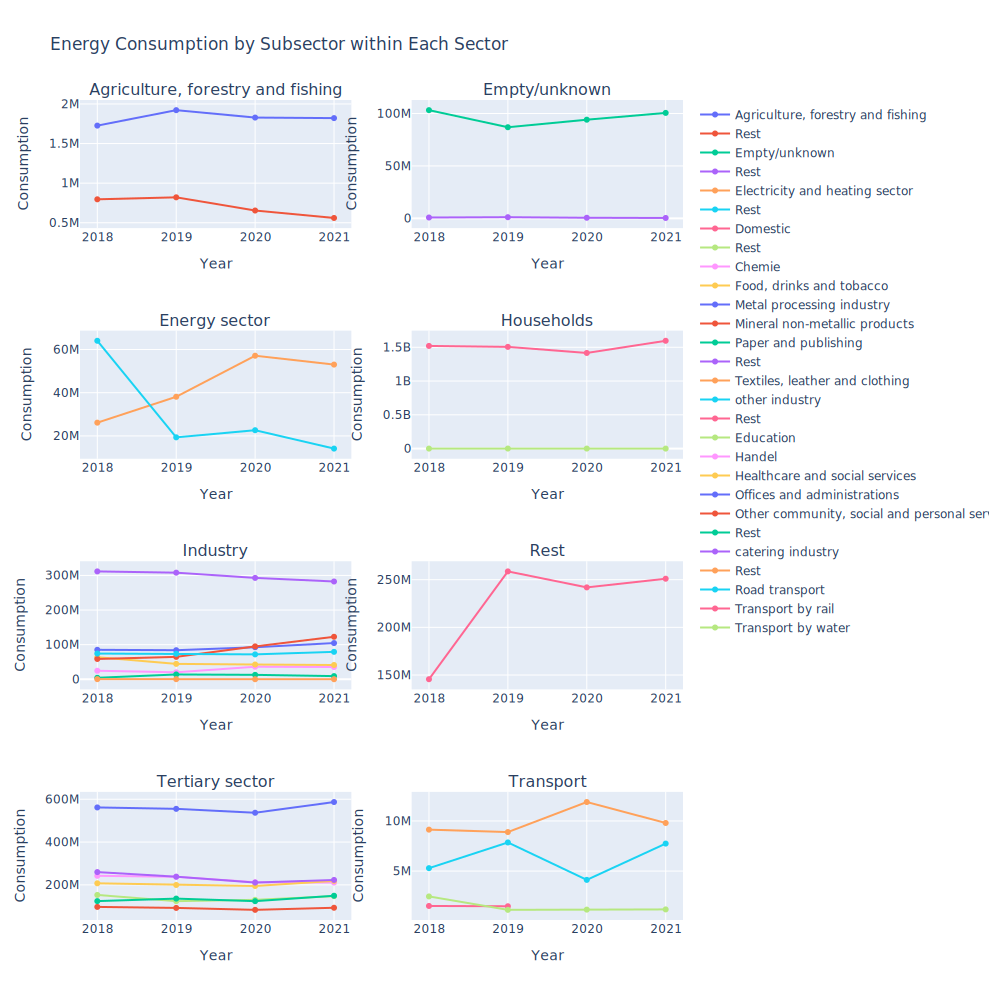

In [ ]:
# Group the data by sector, subsector, and year and calculate the total energy consumption for each group
total_consumption_per_subsector = df_energy_consumption_sector_gent.groupby(['Sector', 'Subsector', 'Consumption year'])['Approximate Consumption (kWh)'].sum().reset_index()

# Sort the data by sector, subsector, and year
total_consumption_per_subsector = total_consumption_per_subsector.sort_values(['Sector', 'Subsector', 'Consumption year'])

# Get unique sectors
sectors = total_consumption_per_subsector['Sector'].unique()

# Determine the number of rows for subplots
num_rows = (len(sectors) // 2) + (len(sectors) % 2)

# Create subplots with specified number of rows and two columns
fig = make_subplots(rows=num_rows, cols=2, subplot_titles=sectors)

# Iterate over each sector
for i, sector in enumerate(sectors, start=1):
    # Filter data for the current sector
    sector_data = total_consumption_per_subsector[total_consumption_per_subsector['Sector'] == sector]

    # Determine the subplot row and column for the current sector
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    # Iterate over each subsector within the sector
    for subsector in sector_data['Subsector'].unique():
        subsector_data = sector_data[sector_data['Subsector'] == subsector]
        # Add a line trace to the subplot
        fig.add_trace(go.Scatter(x=subsector_data['Consumption year'], y=subsector_data['Approximate Consumption (kWh)'],
                                 name=subsector, mode='lines+markers'), row=row, col=col)

# Update the layout of the subplots
fig.update_layout(showlegend=True, height=1000, width=1000, title_text='Energy Consumption by Subsector within Each Sector')
fig.update_xaxes(title_text='Year', showticklabels=True)
fig.update_yaxes(title_text='Consumption', showticklabels=True)

# Show the subplots
fig.show("svg")


- Within Tertiary sector, office and administraion has highest comsumption and
- within Household, domestic has highest consumption


Energy Consumption by Role Contact

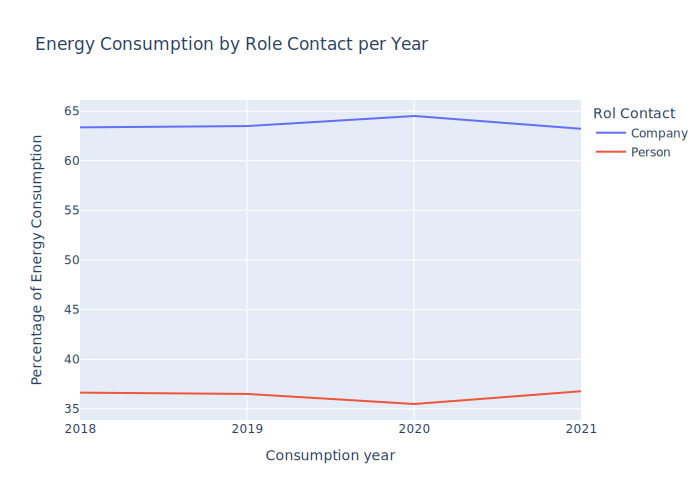

In [ ]:
# Group the data by year, role contact, and calculate the total energy consumption for each group
total_consumption_per_year_role_contact = df_energy_consumption_sector_gent.groupby(['Consumption year', 'Rol Contact'])['Approximate Consumption (kWh)'].sum().reset_index()

# Calculate the percentage of energy consumption for each role contact per year
total_consumption_per_year_role_contact['Percentage'] = total_consumption_per_year_role_contact.groupby('Consumption year')['Approximate Consumption (kWh)'].apply(lambda x: (x / x.sum()) * 100)

# Plot the energy consumption by role contact per year
fig = px.line(total_consumption_per_year_role_contact, x='Consumption year', y='Percentage', color='Rol Contact',
              title='Energy Consumption by Role Contact per Year')

fig.update_layout(xaxis=dict(type='category'), yaxis=dict(title='Percentage of Energy Consumption'))

# Show the plot
fig.show("svg")


In [ ]:
# Get unique sectors and subsectors for each role contact
sectors_per_role_contact = df_energy_consumption_sector_gent.groupby('Rol Contact')['Sector'].unique()
subsectors_per_role_contact = df_energy_consumption_sector_gent.groupby('Rol Contact')['Subsector'].unique()

# Print the sectors and subsectors for each role contact
for role_contact in sectors_per_role_contact.index:
    print(f"Role Contact: {role_contact}")
    print("Sectors:", sectors_per_role_contact[role_contact])
    print("Subsectors:", subsectors_per_role_contact[role_contact])
    print()


Role Contact: Company
Sectors: ['Industry' 'Empty/unknown' 'Tertiary sector' 'Rest'
 'Agriculture, forestry and fishing' 'Transport' 'Households'
 'Energy sector']
Subsectors: ['other industry' 'Empty/unknown' 'Handel' 'catering industry' 'Rest'
 'Education' 'Offices and administrations'
 'Other community, social and personal services'
 'Healthcare and social services' 'Metal processing industry'
 'Food, drinks and tobacco' 'Chemie' 'Electricity and heating sector'
 'Domestic' 'Paper and publishing' 'Agriculture, forestry and fishing'
 'Road transport' 'Transport by water' 'Mineral non-metallic products'
 'Transport by rail' 'Textiles, leather and clothing']

Role Contact: Person
Sectors: ['Households' 'Rest']
Subsectors: ['Domestic' 'Rest']



### Appendix : Data cleaning

**Massaging Gent SOL v3 data**

In [ ]:
# Load the ghent sol_v3 file
sol_v3_path = os.path.join(pdata_path, "Gent_SOL_v3.csv")
df_sol_v3_pre = None
with open(sol_v3_path, mode="r") as fp:
    df_sol_v3_pre = pd.read_csv(fp)

col_names_to_convert = ['LBLTYPE',
                   'ENTITEIT',
                   'STRAATNM',
                   'GEMEENTE',
                   'Type_Dak'
                   ]

df_sol_v3 = df_sol_v3_pre[df_sol_v3_pre.columns].copy()
# convert columns to be converted first to string type and replace 'nan' to ''
for col in col_names_to_convert:
    df_sol_v3[col] = df_sol_v3[col].astype('str')
    df_sol_v3[col] = df_sol_v3[col].str.replace('nan', '')

# translate column names and store the ENGLISH TO DUTCH column name mappings
du_sol_v3_cols = list(df_sol_v3.columns)
sol_v3_cols = translate_column_names(df_sol_v3)
df_sol_v3.columns = sol_v3_cols
# store the ENGLISH TO DUTCH column name mappings
sol_v3_cols_json = dict(zip(sol_v3_cols, du_sol_v3_cols))

# convert column data for
col_vals_to_convert = ['LBLTYPE',
                      # 'STREET NM',   # don't convert the street name values
                      'LOCAL AUTHORITY',
                      'Type_Dak'
                      ]
df_sol_v3 = translate_data(df_sol_v3, columns=col_vals_to_convert)

# do separately for ENTITY column data, but with the available English equivalent from WDL
#   - Gbg (buildings), Knw (man-made objects like bridges) and Gba (building attachments)
entity_translations = {'Gbg': 'buildings',
                       'Gba': 'building attachments',
                       'Knw': 'man-made objects like bridges'
                       }
df_sol_v3['ENTITY'] = df_sol_v3['ENTITY'].map(entity_translations)


# save as csv file
curr_file_name = Path('Gent_SOL_v3.csv').stem
sol_v3_conv_data_path = os.path.join(datapath, "Processed data", f"{curr_file_name}_converted.csv")
with open(sol_v3_conv_data_path, "w") as fp:
    df_sol_v3.to_csv(fp, index=False)


### Appendix : Additional Features

Features based on rental Prices:
- Calculate Avg rental Price per street
- Calculate number of rental houses in every Street


In [ ]:
def annual_electric_bill_reduction(single_rate, fixed_fee, energy_comsumption):
    return (energy_comsumption * single_rate + fixed_fee)


single_rate = 14.94 #(c€/kWh)
fixed_fee = 25 #(€/year)
energy_consumptio_with_sol['annual_electricbill_reduction_per_accesspoint'] = (energy_consumptio_with_sol['Approximate consumption (kWh)'] *
                                                                               single_rate + fixed_fee) / energy_consumptio_with_sol['Number of Access Points']


In [ ]:
def get_rental_price_features(row):
    street = row['Street']
    postal_code = row['POSTCODE']

    # Assuming the rent price dataset is named rent_prices
    rental_prices = rent_prices[(rent_prices['street_name'] == street) & (rent_prices['postal_code'] == postal_code)]

    count = len(rental_prices)

    if count > 0:
        avg_rental_price = (rental_prices['price_main_value'] + rental_prices['price_additional_value']).mean()
    else:
        avg_rental_price = 0

    row['avg_rental_price'] = avg_rental_price
    row['rental_house_count'] = count

    return row


In [ ]:
# Create a new DataFrame with selected columns from energy_consumption_with_sol
selected_columns = ['Street', 'POSTCODE']
df_selected = energy_consumption_with_sol[selected_columns]

# Apply the function to each row in the DataFrame using merge
merged_rental_data = pd.merge(df_selected, rent_prices, left_on=['Street', 'POSTCODE'], right_on=['street_name', 'postal_code'], how='left')

# Apply the function to each row in the merged DataFrame
energy_consumption_with_sol[['avg_rental_price', 'rental_house_count']] = merged_rental_data.apply(get_rental_price_features, axis=1)[['avg_rental_price', 'rental_house_count']]


In [ ]:
len(energy_consumption_with_sol['rental_house_count'])

In [ ]:
energy_consumption_with_sol['rental_house_count'].value_counts()

Features based on decentral production unit:
- Total numer of decentral units available per year.
- totalPower (kVA)
- LSPower (kVA) - power for low voltage
- MSPower (kVA) - power for medium voltage


In [ ]:
# Define a function to calculate the cumulative count of decentral production units
def get_decentral_features(row):
    postcode = row['POSTCODE']
    current_year = row['Consumption year']

    units = df_energy_decentral_production_gent[(df_energy_decentral_production_gent['Postcode'] == postcode) & (df_energy_decentral_production_gent['Year of commissioning'] <= row['Consumption year'])]
    cumulative_count = len(units)

    if cumulative_count > 0 :
       row['count_of_decentral_units']=cumulative_count
       row['totalPower (kVA)'] = units['Power (kVA)'].sum()
       row['LSPower (kVA)'] = units[units['Voltage level connection'] == 'LS']['Power (kVA)'].sum()
       row['MSPower (kVA)'] = row['totalPower (kVA)'] - row['LSPower (kVA)']
    else:
       row['count_of_decentral_units']=0
       row['totalPower (kVA)'] = 0
       row['LSPower (kVA)'] = 0
       row['MSPower (kVA)'] = 0

    return row


In [ ]:
# Apply the function to calculate the cumulative count for each postcode
energy_consumption_with_sol[['count_of_decentral_units', 'totalPower (kVA)', 'LSPower (kVA)', 'MSPower (kVA)']] = energy_consumption_with_sol.apply(get_decentral_features, axis=1)[['count_of_decentral_units', 'totalPower (kVA)', 'LSPower (kVA)', 'MSPower (kVA)']]


In [ ]:
energy_consumption_with_sol.head(10)

In [ ]:
energy_consumption_with_sol.groupby(['POSTCODE','count_of_decentral_units']).count()

In [ ]:
energy_consumption_with_sol.to_csv(os.path.join(datapath,'Processed data/df_energy_consumption_street_2021_processed.csv'), index=False)


**Combine rentprices, with sol v3 and consumption for a specific year**

In [ ]:
def get_energy_consumption_w_sol_dectl_feats(df_energy_sol, df_rent_prices, year=2019):
    df_energy_sol_pre = df_energy_sol[df_energy_sol['Consumption year']==year]
    building_cnt = df_energy_sol_pre[df_energy_sol_pre['ENTITY'] == 'buildings'].groupby('Street').size()

    # Sort the building count in descending order and select the top 10
    top_10_bldgs = building_cnt.sort_values(ascending=False).head(10)
    top_10_bldgs
    selected_columns = ['Street', 'POSTCODE']
    df_energy_sel = df_energy_sol_pre[selected_columns]

    # Apply the function to each row in the DataFrame using merge
    df_merged_rental_data = pd.merge(df_energy_sel, df_rent_prices, left_on=['Street', 'POSTCODE'], right_on=['street_name', 'postal_code'], how='left')

    # Apply the function to each row in the merged DataFrame
    df_energy_sol_pre[['avg_rental_price', 'rental_house_count']] = df_merged_rental_data.apply(get_rental_price_features, axis=1)[['avg_rental_price', 'rental_house_count']]


In [ ]:
year = 2019
energy_consumption_with_sol = get_energy_consumption_w_sol_dectl_feats(energy_consumption_with_sol, rent_prices, year=year)
energy_consumption_with_sol.to_csv(os.path.join(datapath, f'Processed data/df_energy_consumption_street_{year}_processed.csv'), index=False)


Calculation for Annualised Savings

In [ ]:
single_rate = 14.94 #(c€/kWh)
fixed_fee = 25 #(€/year)
energy_consumptio_with_sol['annual_electricbill_reduction_per_accesspoint'] = (energy_consumptio_with_sol['Approximate consumption (kWh)'] *
                                                                               single_rate + fixed_fee) / energy_consumptio_with_sol['Number of Access Points']


The formula for

annualised_savings = ((annual energy production - annual energy use) * tariff) - (average solar panel(s) capacity * solar panel price / average lifetime)

annualised_savings = ((annual energy production - annual energy use)/access_points * single_rate) - (250 * 1.26 / 25) + fixed_fee

- tarrif : single_rate + fixed_fee
  - single_rate = 14.94  #(c€/kWh)
  - fixed_fee = 25 #(€/year)

- Average solar panel capacity = 250-300 watts peak
- Average cost per watt: 1.26 Euro
- The average lifetime of PV modules has been estimated at 25 years

In [ ]:
energy_consumption_with_sol['production_per_access_point'] = energy_consumption_with_sol['totalPower (kVA)']/energy_consumption_with_sol['Number of Access Points']
energy_consumption_with_sol['consumption_per_access_point'] = energy_consumption_with_sol['Approximate consumption (kWh)']/energy_consumption_with_sol['Number of Access Points']
energy_consumption_with_sol['annualised_savings'] = (energy_consumption_with_sol['consumption_per_access_point'] - energy_consumption_with_sol['production_per_access_point']) * single_rate + fixed_fee


In [ ]:
energy_diplay_cols = ['annual_electricbill_reduction_per_accesspoint','production_per_access_point','consumption_per_access_point','annualised_savings','Street','Energy','SUN_RISE','SUN_RISE_3D']
energy_consumption_with_sol[energy_diplay_cols].head(15)


### Appendix : Development of optimisation algorithm

To develop the algorithm with data as small and analysable as possible, we created "toy Ghent" with some invented but realistic numbers on a much smaller size. By running the optimisation algorithm in verbose mode, we can see better how it works.

In [58]:
def create_toy_ghent(n_rooftops: int = 15,
                     n_households: int = 30,
                     n_streets: int = 3):

  def create_pv_production(n_rooftops):

    # Make up some latitudes and longitudes for the rooftops
    lat = 51.0500 + np.random.uniform(-0.001, 0.001, n_rooftops)
    long = 3.7167 + np.random.uniform(-0.001, 0.001, n_rooftops)

    # Make up some annual energy production
    prod = np.linspace(500, 2500, n_rooftops)

    # Make up some installation costs
    cost = prod.copy()

    # Create a dataframe of solar panel annual production
    pv_production = pd.DataFrame(
        {"latitude": lat,
        "longitude": long,
        "pv_production": prod,
        "installation_cost": cost}
    )

    return pv_production


  def create_energy_consumption(n_households, n_streets):

    # Make up some latitudes and longitudes for the households
    lat = 51.0500 + np.random.uniform(-0.001, 0.001, n_households)
    long = 3.7167 + np.random.uniform(-0.001, 0.001, n_households)

    # Make up some household energy consumptions per street
    street_consumption_ave = np.linspace(5000, 10000, n_streets)

    # Assign street IDs unevenly to the households
    street_id = []
    n_households_left = n_households
    counter = 0
    while n_households_left > 1:
      [street_id.append(int(x)) for x in np.ones(int(n_households_left/2)) * counter%n_streets]
      n_households_left = n_households_left - int(n_households_left/2)
      counter += 1
    street_id.append(int(counter//n_streets))

    # Assign the street's average consumption to every household within it
    consump = [street_consumption_ave[x] for x in street_id]

    # Create a dataframe of annual household energy consumption
    energy_consumption = pd.DataFrame(
        {"latitude": lat,
        "longitude": long,
        "energy_consumption": consump}
    )
    energy_consumption.index.set_names("household_id", inplace=True)

    return energy_consumption


  def create_distance_norm_factor(energy_consumption):

    # Member locations
    locations = list(zip(energy_consumption["latitude"], energy_consumption["longitude"]))

    # Distances between member locations
    distances = [haversine(loc1, loc2, unit=Unit.KILOMETERS) for loc1, loc2 in combinations(locations, 2)]
    mean_distance = np.mean(distances)

    return mean_distance


  pv_production = create_pv_production(n_rooftops)
  energy_consumption = create_energy_consumption(n_households, n_streets)
  distance_norm_factor = create_distance_norm_factor(energy_consumption)

  global_params = dict()
  global_params["pv_lifespan"] = 20                                     # years
  global_params["feed_in_tariff"] = 0.0                                  # €/kWh
  global_params["grid_price"] = 14.94                                    # €/kWh
  global_params["fixed_fee"] = 25                                        # €
  global_params["community_price"] = 13                                  # €/kWh
  global_params["distance_norm_factor"] = distance_norm_factor


  return pv_production, energy_consumption, global_params

**Compare models on toy Ghent**

In [59]:
# Create toy Ghent
max_communities = 5
pv_production, energy_consumption, global_params = create_toy_ghent()

In [60]:
# Baseline model
baseline = energy_community_baseline(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode="highest", n_random_configurations=100)
baseline.create_energy_communities(global_params=global_params, verbose=True)
print(f"\n\nbaseline method produces a set of {len(baseline.final_energy_communities)} energy community/ies with mean quality {baseline.mean_energy_community_quality:,.1f}")
baseline.final_energy_communities


Calcuating objective metric for energy community with 8 members and 1 solar panels
Average profit per household €593.75
Multiplying by 0.95 for size of energy community
Multiplying by 1.0 for distances within energy community
Multiplying by 0.87 for start-up cost per member

Calcuating objective metric for energy community with 6 members and 1 solar panels
Average profit per household €746.67
Multiplying by 0.73 for size of energy community
Multiplying by 1.1 for distances within energy community
Multiplying by 0.74 for start-up cost per member

Calcuating objective metric for energy community with 3 members and 1 solar panels
Average profit per household €1,403.33
Multiplying by 0.12 for size of energy community
Multiplying by 0.91 for distances within energy community
Multiplying by 0.085 for start-up cost per member

Calcuating objective metric for energy community with 9 members and 1 solar panels
Average profit per household €437.78
Multiplying by 0.98 for size of energy communit

,index,pv_latitude,pv_longitude,pv_production,installation_cost,energy_consumption,households,quality
0,14,[51.04977297796225],[3.7176178985372488],[2500.0],[2500.0],"[5000.0, 5000.0, 5000.0, 5000.0, 7500.0, 7500....","[1, 9, 10, 14, 17, 21, 23, 26]",492.357931
1,13,[51.0494446427765],[3.7169685481159145],[2357.142857142857],[2357.142857142857],"[5000.0, 5000.0, 7500.0, 7500.0, 7500.0, 5000.0]","[5, 13, 15, 16, 18, 27]",358.370086
2,12,[51.04929934973436],[3.7157768508529454],[2214.285714285714],[2214.285714285714],"[5000.0, 5000.0, 10000.0]","[7, 12, 24]",15.522597
3,11,[51.04964828201558],[3.716350094458017],[2071.4285714285716],[2071.4285714285716],"[5000.0, 5000.0, 5000.0, 5000.0, 7500.0, 10000...","[2, 3, 4, 6, 20, 22, 25, 28, 29]",433.872869
4,10,[51.04927043634681],[3.716915661337431],[1928.5714285714287],[1928.5714285714287],"[5000.0, 5000.0, 5000.0, 7500.0]","[0, 8, 11, 19]",106.719352


In [61]:
# K-means model
kmeans = energy_community_kmeans(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode="highest")
kmeans.create_energy_communities(global_params=global_params, verbose=True)
print(f"\n\nkmeans method produces a set of {len(kmeans.final_energy_communities)} energy community/ies with mean quality {kmeans.mean_energy_community_quality:,.1f}")
kmeans.final_energy_communities



kmeans method produces a set of 5 energy community/ies with mean quality 439.2


,index,pv_latitude,pv_longitude,pv_production,installation_cost,energy_consumption,households,quality
0,14,[51.04977297796225],[3.7176178985372488],[2500.0],[2500.0],"[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 10000...","[1, 3, 4, 8, 10, 23, 25, 26, 28]",725.903364
1,13,[51.0494446427765],[3.7169685481159145],[2357.142857142857],[2357.142857142857],"[5000.0, 5000.0, 7500.0, 7500.0, 10000.0, 1000...","[0, 9, 18, 20, 22, 24]",797.544383
2,12,[51.04929934973436],[3.7157768508529454],[2214.285714285714],[2214.285714285714],"[5000.0, 5000.0, 7500.0, 7500.0]","[5, 7, 19, 29]",198.682340
3,11,[51.04964828201558],[3.716350094458017],[2071.4285714285716],[2071.4285714285716],"[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 7500....","[2, 6, 11, 12, 14, 15, 16, 17, 27]",471.394049
4,10,[51.04927043634681],[3.716915661337431],[1928.5714285714287],[1928.5714285714287],"[5000.0, 7500.0]","[13, 21]",2.656127


In [64]:
# Custom optimisation model
optimisation = energy_community_optimisation(energy_consumption=energy_consumption, pv_production=pv_production, max_communities=max_communities, initialisation_mode="highest", tolerance=10)
optimisation.create_energy_communities(global_params=global_params, verbose=True)
print(f"\n\noptimisation method produces a set of {len(optimisation.final_energy_communities)} energy community/ies with mean quality {optimisation.mean_energy_community_quality:,.1f}")
optimisation.final_energy_communities



### INITIALISING ENERGY COMMUNITIES ###


### OPTIMISING HOUSEHOLDS INTO ENERGY COMMUNITIES, ITERATION 1 ###

Calcuating objective metric for energy community with 1 members and 1 solar panels
Average profit per household €4,750.00
Multiplying by 0.018 for size of energy community
Multiplying by 5.7 for distances within energy community
Multiplying by 2.1e-09 for start-up cost per member
Assigning household 0 to energy community 14 would change the community's cluster quality from 0 to 3.0757441552997954e-08, a difference of 3.0757441552997954e-08

Calcuating objective metric for energy community with 1 members and 1 solar panels
Average profit per household €4,480.00
Multiplying by 0.018 for size of energy community
Multiplying by 5.8 for distances within energy community
Multiplying by 8.6e-09 for start-up cost per member
Assigning household 0 to energy community 13 would change the community's cluster quality from 0 to 1.1935107347814207e-07, a difference of 1.1935107347814207e-07

,pv_latitude,pv_longitude,pv_production,installation_cost,energy_consumption,households,quality
13,"[51.0494446427765, 51.05044126530945]","[3.7169685481159145, 3.716599899979822]","[2357.142857142857, 642.8571428571429]","[2357.142857142857, 642.8571428571429]","[10000.0, 10000.0, 5000.0, 5000.0, 7500.0, 500...","[23, 25, 26, 27, 28, 2]",380.568311
12,"[51.04929934973436, 51.050164039584146]","[3.7157768508529454, 3.716926126915768]","[2214.285714285714, 785.7142857142858]","[2214.285714285714, 785.7142857142858]","[7500.0, 7500.0, 7500.0, 7500.0, 7500.0, 7500....","[16, 17, 18, 19, 20, 21, 22, 29]",501.699330
11,"[51.04964828201558, 51.04994720083869]","[3.716350094458017, 3.7170062800715957]","[2071.4285714285716, 1357.142857142857]","[2071.4285714285716, 1357.142857142857]","[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000....","[7, 9, 10, 11, 12, 13, 14, 15]",552.589612
10,"[51.04927043634681, 51.0500747464589, 51.05035...","[3.716915661337431, 3.7175046971663477, 3.7175...","[1928.5714285714287, 928.5714285714286, 500.0]","[1928.5714285714287, 928.5714285714286, 500.0]","[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000....","[0, 1, 3, 4, 5, 6, 24, 8]",731.282340
